<a href="https://www.kaggle.com/code/sukritchatterjee/data-exploration-i?scriptVersionId=123621254" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Data Exploration

Welcome to the second notebook in the data processing stage of the project **Priceless Wheels**. 
In this notebook, we will explore the data and try to understand the data better. We would be visualizing the data, look at their distributions.
We will try to answer the following questions:
1. What factors have the biggest impact on the price of a vehicle?
2. Which features are important enough to keep in the model?
2. How would we handle the missing values?
3. How would we handle the outliers?

---

## Necessary Imports and reading the data

In [1]:
import math
from prettytable import PrettyTable
import random

# Stat models for tests
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import pandas_profiling as pp # for Profiling the data
import regex as re # for regex matching
import datetime # for datetime operations
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # seaborn for nice looking plots
import plotly.express as px

# plt.rcParams['figure.dpi'] = 150 # Set the dpi to 300 for a higher quality plot
sns.set() # setting seaborn default for plots

# removing scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Comment out when running on Kaggle
# Input data files are available in the read-only "../input/" directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/used-cars-dataset-cardekho/cars_data_clean.csv
/kaggle/input/used-cars-dataset-cardekho/cars_details_merges.csv
/kaggle/input/used-cars-dataset-cardekho/feature_dictionary.csv


In [2]:
file_path = '/kaggle/input/used-cars-dataset-cardekho/cars_data_clean.csv'
df = pd.read_csv(file_path)

df.head()

usedCarSkuId            loc  myear       body  \
0  7111bf25-97af-47f9-867b-40879190d800    gomti nagar   2016  hatchback   
1  c309efc1-efaf-4f82-81ad-dcb38eb36665  borivali west   2015  hatchback   
2  7609f710-0c97-4f00-9a47-9b9284b62d3a         jasola   2015      sedan   
3  278b76e3-5539-4a5e-ae3e-353a2e3b6d7d         jasola   2013  hatchback   
4  b1eab99b-a606-48dd-a75b-57feb8a9ad92  mumbai g.p.o.   2022        muv   

  transmission fuel         km  ip  \
0       manual  cng  69162.000   0   
1       manual  cng  45864.000   0   
2       manual  cng  81506.000   0   
3       manual  cng 115893.000   0   
4       manual  cng  18900.000   0   

                                              images  imgCount  ...  \
0  [{'img': 'https://images10.gaadi.com/usedcar_i...        15  ...   
1  [{'img': 'https://images10.gaadi.com/usedcar_i...        15  ...   
2  [{'img': 'https://images10.gaadi.com/usedcar_i...        15  ...   
3                                      [{'img': ''}]         0  ...   
4  [{'img': 'https://images10.gaadi.com/usedcar_i...         6  ...   

            Fuel Suppy System Compression Ratio Alloy Wheel Size  \
0                         NaN               NaN              NaN   
1     Gasoline Port Injection            11.000              NaN   
2                         NaN               NaN              NaN   
3  Multi-Point Fuel Injection               NaN           13.000   
4                         NaN            12.000              NaN   

  Ground Clearance Unladen Max Power Delivered Max Power At  \
0                      NaN              58.160     6200.000   
1                      NaN              58.200     6000.000   
2                      NaN              86.700     6000.000   
3                      NaN              58.200     6200.000   
4                      NaN              86.630     5500.000   

   Max Torque Delivered  Max Torque At   Bore Stroke  
0                77.000       3500.000 69.000    NaN  
1                78.000       3500.000 73.000    NaN  
2               109.000       4500.000    NaN    NaN  
3                77.000       3500.000    NaN    NaN  
4               121.500       4200.000    NaN    NaN  

[5 rows x 66 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37813 entries, 0 to 37812
Data columns (total 66 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   usedCarSkuId              37813 non-null  object 
 1   loc                       31963 non-null  object 
 2   myear                     37813 non-null  int64  
 3   body                      37794 non-null  object 
 4   transmission              37813 non-null  object 
 5   fuel                      37813 non-null  object 
 6   km                        37813 non-null  float64
 7   ip                        37813 non-null  int64  
 8   images                    37813 non-null  object 
 9   imgCount                  37813 non-null  int64  
 10  threesixty                37813 non-null  bool   
 11  dvn                       37813 non-null  object 
 12  oem                       37813 non-null  object 
 13  model                     37813 non-null  object 
 14  varian

---

### Profiling the data

In [4]:
profile = pp.ProfileReport(
    df, 
    title="Priceless Wheels Cars",
    dataset={
        "description": "This profiling report was generated for a personal project titled Priceless Wheels",
        "copyright_holder": "https://github.com/chats-bug",
        "copyright_year": "2021",
        "url": "https://github.com/chats-bug/Priceless-Wheels",
    },)

In [5]:
# profile.to_file("cars_report.html")

We can note the following things from the profiling:
1. There are a total of 63 variables - 32 `categorical`, 28 `numeric` and 3 `boolean`
2. Some columns have very *HIGH CARDINALITY*
3. Some columns are vero *LOW VARIANCE*
4. Many columns are *HIGHLY CORRELATED*
5. Some columns have more than *50% DATA MISSING* 

Let's go through the columns one by one and fix these issues.

### Agenda

1. Define strategy to handle missing values in different columns
2. Extract insights from the data about which might include the following:
    - Which columns to drop, i.e. not very important for prediction
    - Tranformations that might help

In [6]:
# Make a copy of the dataframe to play with in this notebook
df2 = df.copy()
TARGET = 'listed_price'

# There are only a few cars which are priced near Rs. 1 Crore, but one car in particular has a price of 5.5 Crore. We can drop this row for better visualization  and homogenization purposes
df2 = df2[df2[TARGET] < 10000000]

# List of transformations suggested during the course of exploring the data
suggested_transformations = []

### Helper Functions for EDA

Some functions to get the most important info about the data

In [7]:
# Function to get a genreal overview of the data with some basic statistics
def overview_data(data: pd.DataFrame, col: str) -> None:  
    '''
    Input arguments:
    - data : pandas dataframe
    - col : column name

    Outputs:
    - None : Prints the overview of the column:
                - Distinct count
                - Distinct %
                - Missing count
                - Missing %
                - Mean
                - Minimum
                - Maximum
    '''
    
    data = data.copy()
    t = PrettyTable(['Measure', 'Value'])
    t.add_row(['Distinct Count', data[col].nunique()])
    t.add_row(['Distinct %', data[col].nunique()/data.shape[0]*100])
    t.add_row(['Missing Count', data[col].isna().sum()])
    t.add_row(['Missing %', data[col].isna().sum()/data.shape[0]*100])
    t.add_row(['Mean', data[col].mean()])
    t.add_row(['Minimum', data[col].min()])
    t.add_row(['Maximum', data[col].max()])

    # Display the overview of the dataframe
    print(f'Overview of column "{col}"')
    print(t)

    print('\n')
    return


# Function to get the quantile statistics for a numeric column
def quantile_statistics_for_column(data: pd.DataFrame, col: str) -> dict:
    '''
    Input arguments:
    - data : pandas dataframe
    - col : column name

    Outputs:
    - quantile_stats: Returns a dictionary with quantile stats for the column which includes:
                            - min : Minimum value
                            - 5% : 5th percentile value
                            - q1 : First quartile value
                            - median : Median value
                            - q3 : Third quartile value
                            - 95% : 95th percentile value
                            - max : Maximum value
                            - range: Range of values
                            - IQR : Interquartile range
    '''
    
    data = data.copy()
    # Check if the column exists in the dataframe
    if col not in data.columns:
        print(f'Column {col} not found in the dataframe')
        return

    # Check if the column is numeric
    if data[col].dtype != 'float64' and data[col].dtype != 'int64':
        print(f'Column {col} is not numeric')
        return

    quantile_stats = {}
    quantile_stats['min'] = data[col].min()
    quantile_stats['5%'] = data[col].quantile(0.05)
    quantile_stats['Q1'] = data[col].quantile(0.25)
    quantile_stats['median'] = data[col].median()
    quantile_stats['Q3'] = data[col].quantile(0.75)
    quantile_stats['95%'] = data[col].quantile(0.95)
    quantile_stats['max'] = data[col].max()
    quantile_stats['range'] = quantile_stats['max'] - quantile_stats['min']
    quantile_stats['IQR'] = quantile_stats['Q3'] - quantile_stats['Q1']

    # Display the quantile stats
    print(f'Quantile stats for column "{col}"')
    t = PrettyTable(['Statistic', 'Value'])
    t.add_row(['Minimum', quantile_stats['min']])
    t.add_row(['5th Percentile', quantile_stats['5%']])
    t.add_row(['First Quartile, Q1', quantile_stats['Q1']])
    t.add_row(['Median', quantile_stats['median']])
    t.add_row(['Third Quartile, Q3', quantile_stats['Q3']])
    t.add_row(['95th Percentile', quantile_stats['95%']])
    t.add_row(['Maximum', quantile_stats['max']])
    t.add_row(['Range', quantile_stats['range']])
    t.add_row(['Interquartile Range', quantile_stats['IQR']])
    print(t)

    print('\n')
    return quantile_stats


# Function to get the descriptive statistics for a numeric column
def descriptive_statistics_for_column(data: pd.DataFrame, col: str) -> dict:
    '''
    Input arguments:
    - data : pandas dataframe
    - col : column name

    Outputs:
    - descriptive_stats : Return a dictionary with descriptive stats for the column which includes:
                                - mean: Mean
                                - sum: Sum
                                - var: Variance
                                - std : Standard deviation
                                - CV : Coefficient of variation
                                - kurtosis: Kurtosis
                                - MAD: Mean Absolute Deviation
                                - skewness: Skewness
                                - mono: true if monotonous

    '''
    
    data = data.copy()
    # Check if the column exists in the dataframe
    if col not in data.columns:
        print(f'Column {col} not found in the dataframe')
        return

    # Check if the column is numeric
    if data[col].dtype != 'float64' and data[col].dtype != 'int64':
        print(f'Column {col} is not numeric')
        return

    descriptive_stats = {}
    descriptive_stats['mean'] = data[col].mean()
    descriptive_stats['sum'] = data[col].sum()
    descriptive_stats['var'] = data[col].var()
    descriptive_stats['std'] = data[col].std()
    descriptive_stats['CV'] = descriptive_stats['std'] / descriptive_stats['mean']
    descriptive_stats['kurtosis'] = data[col].kurtosis()
    descriptive_stats['MAD'] = data[col].mad()
    descriptive_stats['skewness'] = data[col].skew()
    descriptive_stats['mono'] = data[col].is_monotonic_increasing or data[col].is_monotonic_decreasing

    # Display the descriptive stats
    print(f'Descriptive stats for column "{col}"')
    t = PrettyTable(['Statistic', 'Value'])
    t.add_row(['Mean', descriptive_stats['mean']])
    t.add_row(['Sum', descriptive_stats['sum']])
    t.add_row(['Variance', descriptive_stats['var']])
    t.add_row(['Standard deviation', descriptive_stats['std']])
    t.add_row(['Coefficient of variation', descriptive_stats['CV']])
    t.add_row(['Kurtosis', descriptive_stats['kurtosis']])
    t.add_row(['Mean absolute deviation', descriptive_stats['MAD']])
    t.add_row(['Skewness', descriptive_stats['skewness']])
    t.add_row(['Monotonous', descriptive_stats['mono']])
    print(t)

    print('\n')
    return descriptive_stats


# Function to get the max and min values for a numeric column
def extremums_for_column(data: pd.DataFrame, col: str, n: int = 5) -> pd.DataFrame:
    '''
    Input arguments:
    - data : pandas dataframe
    - col : column name

    Outputs:
    - extremums: Return a dataframe with extremums for the column which includes:
                    - max_n: "n" largest values in the column
                    - min_n: "n" smallest values in the column

    '''
    
    data = data.copy()
    # Check if the column exists in the dataframe
    if col not in data.columns:
        print(f'Column "{col}" not found in the dataframe')
        return

    # Check if the column is numeric
    if data[col].dtype != 'float64' and data[col].dtype != 'int64':
        print(f'Column "{col}" is not numeric')
        return

    extremums = {}
    extremums['max_n'] = data[col].value_counts().sort_index(ascending=False).head(5)
    extremums['min_n'] = data[col].value_counts().sort_index(ascending=True).head(5)

    # Display the extremums
    print(f'Extremums for column "{col}"')

    print(f'Maximum {n} values')
    t = PrettyTable(['Value', 'Count', 'Freq'])
    for (index, value) in extremums['max_n'].iteritems():
        t.add_row([index, value, value / len(data[col]) * 100])
    print(t)

    print(f'Minimum {n} values')
    t = PrettyTable(['Value', 'Count', 'Freq'])
    for (index, value) in extremums['min_n'].iteritems():
        t.add_row([index, value, value / len(data[col]) * 100])
    print(t)

    print('\n')
    return extremums


# Function to check the most frquently occuring values (preferably for a categorical column)
def common_values(data: pd.DataFrame, col: str, n: int = 5, target: str = TARGET) -> pd.DataFrame:
    '''
    Input arguments:
    - data : pandas dataframe
    - col : column name

    Outputs:
    - common_values: Return a dataframe with common values for the column which includes:
                        - value: Common value in the column
                        - count: Count of the value in the column
                        - freq: Frequency of the value in the column
    '''
    
    data = data.copy()
    n_values = data[col].value_counts().nlargest(n)
    common_values = pd.DataFrame()
    common_values['value'] = n_values.index
    common_values['count'] = n_values.values
    common_values['freq'] = 100 * common_values['count'] / data[col].count()
    common_values['target_mean'] = [data[data[col] == v[0]][target].mean() for v in n_values.items()]

    # Display the common values
    print(f'Common values for column "{col}"')
    t = PrettyTable(['Value', 'Count', 'Frequency', 'Mean of Target'])
    for (v, c, f, mu) in zip(common_values['value'], common_values['count'], common_values['freq'], common_values['target_mean']):
        t.add_row([v, c, f, mu])
    print(t)

    print('\n')
    return common_values


def categorical_overview(data: pd.DataFrame, col: str) -> pd.DataFrame:
    '''
    Input arguments:
    - data : pandas dataframe
    - col : column name

    Outputs:
    - None: Prints the overview of the categorical column:
            - Distinct: Number of distinct values in the column
            - Distinct (%) : Percentage of distinct values in the column
            - Missing: Number of missing values in the column
            - Missing (%) : Percentage of missing values in the column
    '''
    
    data = data.copy()
    t = PrettyTable(['Measure', 'Value'])
    t.add_row(['Distinct Count', data[col].nunique()])
    t.add_row(['Distinct %', data[col].nunique()/data.shape[0]*100])
    t.add_row(['Missing Count', data[col].isna().sum()])
    t.add_row(['Missing %', data[col].isna().sum()/data.shape[0]*100])

    # Display the unique values
    print(f'Overview of column "{col}"')
    print(t)

    print('\n')
    

def analyze_data(df: pd.DataFrame, col: str, categorical: bool = False, **kwargs) -> dict():
    df = df.copy()
    n = kwargs.get('n', 5)
    want_descriptive = kwargs.get('descriptive', False)

    # Check if column exists in the dataframe
    if col not in df.columns:
        print(f'Column "{col}" not found in the dataframe')
        return None

    # Check if the column is numeric
    if (df[col].dtype == 'float64' or df[col].dtype == 'int64') and not categorical:
        overview_data(df, col)
        details_object = {}
        details_object["quantile_stats"] = quantile_statistics_for_column(df, col)
        if want_descriptive:
            details_object["descriptive_stats"] = descriptive_statistics_for_column(df, col)
        details_object["extremums"] = extremums_for_column(df, col, n)
        details_object["common_val"] = common_values(df, col, n)
        return details_object
    else:
        categorical_overview(df, col)
        details_object = {}
        details_object["quantile_stats"] = quantile_statistics_for_column(df, col)
        details_object["common_values"] = common_values(df, col, n)
        return details_object


def feature_dist_plots(
    df: pd.DataFrame, col: str, bins: int = 20, sorted = False,
    shrink: int = 1, figsize = (20, 8), fontscale=0.8, sat=0.9, 
    target: str = TARGET, hist_transformation = lambda x: x, transformation = lambda x: x, 
    rotation=45, tname='Identity', category=False, **kwargs
) -> None:
    df = df.copy()
    color = random.choice(sns.color_palette("hls", 15))
    
    sns.set_style('darkgrid')
    sns.set_context('paper', font_scale=fontscale)
    plt.rcParams['figure.dpi'] = 100
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(int)
    
    if df[col].dtype in ['float64', 'int64'] and not category:
        sns.histplot(x=df[col].apply(hist_transformation), kde=True, ax=ax[0], edgecolor='black', color=color, bins=bins, shrink=shrink, **kwargs)
        sns.boxplot(x=df[col].apply(hist_transformation), ax=ax[1], color=color, saturation=sat, **kwargs)
        ax[0].set_title(f'Distribution of {"" if tname == "Identity" else f"{tname} of"} {col}')
        ax[1].set_title(f'Boxplot of {"" if tname == "Identity" else f"{tname} of"} {col}')
        plt.tight_layout()
        plt.show()

    else:
        df[col] = df[col].astype('category')
        order = df[col].value_counts().index if sorted else None
        cplot = sns.countplot(df, x=col, ax=ax[0], edgecolor='black', color=color, order=order, **kwargs)
        ax[0].set_title(f'Distribution of {col}')
        
        box_order = df.groupby(col)[target].mean().sort_values().index
        bplot = sns.boxplot(df, x=df[target].apply(transformation), y=df[col], ax=ax[1], order=box_order, color=color, saturation=sat, **kwargs)
        ax[1].set_title(f'Boxplot of {col}')
        
        for axis in ax[:-1]:
            ticks = [i for i in df[col].unique() if str(i) != 'nan']
            axis.set_xticks(range(len(ticks)))
            axis.set_xticklabels(ticks, rotation=rotation, horizontalalignment='right')
            
        plt.tight_layout()
        plt.show()
    
    return

        
def target_relation_plots(
    df: pd.DataFrame, col: str, figsize = (20, 8), target: str = TARGET, fontscale=0.8,
    transformation = np.log, tname = 'Log transform', rotation=45, sorted=False, col_transformation = lambda x: x,
    ctname = 'Identity',
    plot = 'line', categorical = False, **kwargs
 ) -> None:
    df = df.copy()
    pallete = sns.color_palette("icefire", as_cmap=False)
    color1 = random.choice(pallete)
    color2 = random.choice(pallete)

    sns.set_style('darkgrid')
    sns.set_context('paper', font_scale=fontscale)
    plt.rcParams['figure.dpi'] = 100
    fig, ax = plt.subplots(1, 2, figsize=figsize)

    if plot == 'line':
        if df[col].dtype in ['int64', 'float64'] and not categorical:
            lplot = sns.lineplot(df, x=df[col].apply(col_transformation), y=df[target], ax=ax[0], color=color1, label='Original', **kwargs)
            ax[0].set_title(f'{target} v/s {col}')
            lplot_trans = sns.lineplot(df, x=df[col].apply(col_transformation), y=df[target].apply(transformation), ax=ax[1], color=color2, label='Transformed', **kwargs)
            ax[1].set_title(f'{tname} of {target} v/s {col}')

        else:
            df[col] = df[col].astype('category')
            ticks = [i for i in df[col].unique() if str(i) != 'nan']
            if sorted:
                grouped = df.groupby(col).mean().reset_index()
                sorted_order = grouped.sort_values(by=target)[col].tolist()
                df[col] = pd.Categorical(df[col], categories=sorted_order)
                ticks = sorted_order

            lplot = sns.lineplot(df, x=col, y=df[target], ax=ax[0], color=color1, label='Original', **kwargs)
            ax[0].set_title(f'{target} v/s {col}')
            lplot_trans = sns.lineplot(df, x=col, y=df[target].apply(transformation), ax=ax[1], color=color2, label='Transformed', **kwargs)
            ax[1].set_title(f'{tname} of {target} v/s {col}')

            for axis in ax:
                axis.set_xticks(range(len(ticks)))
                axis.set_xticklabels(ticks, rotation=rotation, horizontalalignment='right')

        plt.tight_layout()
        plt.show()

    elif plot == 'scatter':
        if df[col].dtype in ['int64', 'float64'] and not categorical:
            splot = sns.scatterplot(df, x=df[col].apply(col_transformation), y=df[target], ax=ax[0], color=color1, label='Original', **kwargs)
            ax[0].set_title(f'{target} v/s {col}')
            splot_trans = sns.scatterplot(df, x=df[col].apply(col_transformation), y=df[target].apply(transformation), ax=ax[1], color=color2, label='Transformed', **kwargs)
            ax[1].set_title(f'{tname} of {target} v/s {col}')

        else:
            df[col] = df[col].astype('category')
            ticks = [i for i in df[col].unique() if str(i) != 'nan']
            if sorted:
                grouped = df.groupby(col).mean().reset_index()
                sorted_order = grouped.sort_values(by=target)[col].tolist()
                df[col] = pd.Categorical(df[col], categories=sorted_order)
                ticks = sorted_order

            splot = sns.scatterplot(df, x=col, y=df[target], ax=ax[0], color=color1, label='Original', **kwargs)
            ax[0].set_title(f'{target} v/s {col}')
            splot_trans = sns.scatterplot(df, x=col, y=df[target].apply(transformation), ax=ax[1], color=color2, label='Transformed', **kwargs)
            ax[1].set_title(f'{tname} of {target} v/s {col}')

            for axis in ax:
                axis.set_xticks(range(len(ticks)))
                axis.set_xticklabels(ticks, rotation=rotation, horizontalalignment='right')

        plt.tight_layout()
        plt.show()
    
    elif plot=='reg':
        if df[col].dtype in ['int64', 'float64'] and not categorical:
            rplot = sns.regplot(df, x=df[col].apply(col_transformation), y=df[target], ax=ax[0], color=color1, label='Original', **kwargs)
            ax[0].set_title(f'{target} v/s {col}')
            r_transplot=  sns.regplot(df, x=df[col].apply(col_transformation), y=df[target].apply(transformation), ax=ax[1], color=color2, label='Transformed', **kwargs)
            ax[1].set_title(f'{tname} of {target} v/s {col}')

        else:
            df[col] = df[col].astype('category')
            ticks = [i for i in df[col].unique() if str(i) != 'nan']
            if sorted:
                grouped = df.groupby(col).mean().reset_index()
                sorted_order = grouped.sort_values(by=target)[col].tolist()
                df[col] = pd.Categorical(df[col], categories=sorted_order)
                ticks = sorted_order

            rplot = sns.regplot(df, x=col, y=df[target], ax=ax[0], color=color1, label='Original', **kwargs)
            ax[0].set_title(f'{target} v/s {col}')
            rplot = sns.regplot(df, x=col, y=df[target].apply(transformation), ax=ax[1], color=color2, label='Transformed', **kwargs)
            ax[1].set_title(f'{tname} of {target} v/s {col}')

            for axis in ax:
                axis.set_xticks(axis.get_xticks())
                axis.set_xticklabels(
                    df[col].unique(), rotation=rotation, horizontalalignment='right')

        plt.tight_layout()
        plt.show()

    else:
        print('Invalid plot type. Please choose from "line", "scatter" or "reg"')
    
    return


# Function to calculate different correlation coefficient between two features
def correlation_coefficients(data: pd.DataFrame, features: list = [], target: bool = False, method: str = 'pearson') -> pd.DataFrame:
    data = data.copy()
    # Check if all the features are present in the dataframe
    if not (set(features) <= set(data.columns.values)):
        print('One or more features are not present in the dataframe')
        return None

    num_feat = df.select_dtypes(include=['int64', 'float64']).columns.values
    # Check if features are numerical
    if not (set(features) <= set(num_feat)):
        print('One or more features are not numerical')
        return None

    if features == []:
        if target:
            features = num_feat
        else:
            features = np.delete(num_feat, np.where(num_feat == TARGET))

    # Calculate the correlation coefficient
    if method in ['pearson', 'spearman', 'kendall']:
        corr_coeff = data[features].corr(method=method)
    elif method == 'phik':
        corr_coeff = data.phik_matrix()
    elif method == 'cramersv':
        data = data.apply(
                lambda x: x.astype("category") if x.dtype == "O" else x)
        cramersv = am.CramersV(data) 
        corr_coeff = cramersv.fit()
    else:
        print('Invalid method')
        return None

    return corr_coeff

# Function to plot the correlation coefficient heatmap
def correlation_heatmap(corr_matrix: pd.DataFrame = None, method: str = 'None', annot: bool = False, mask = None) -> None:
    corr_matrix = corr_matrix.copy()
    if corr_matrix is None:
        print('No correlation matrix provided')
        return None

    if method in ['pearson', 'spearman', 'kendall']:
        cmap = 'RdBu'
        vmin = -1
        vmax = 1
    elif method in ['phik', 'cramersv']:
        cmap = 'Blues'
        vmin = 0
        vmax = 1
    else:
        print('Invalid method')
        return None
    
#     sns.set_style('darkgrid')
    sns.set_context('paper', font_scale=0.8)
    plt.rcParams['figure.dpi'] = 100
    fig, heat = plt.subplots(1, 1, figsize=(14, 10))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.set_theme(style="white")
    corr_heatmap = sns.heatmap(
        corr_matrix, vmin=vmin, vmax=vmax, cmap=cmap, mask=mask, ax=heat, 
        annot=annot, fmt='.2f', center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}
    )
    corr_heatmap.set_title(f'{method.title()} Correlation Coefficient')
    plt.show()

def correlation_with_plot(data: pd.DataFrame, features: list = [], target: bool = False, method: str = 'pearson', annot: bool = False, clip: bool = True) -> pd.DataFrame:
    data = data.copy()
    # Compute the correlation matrix
    corr_coeff = correlation_coefficients(data, features, target, method)
    
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_coeff, dtype=bool)) if clip else None
    
    correlation_heatmap(corr_matrix=corr_coeff, mask=mask, method=method, annot=annot)
    return corr_coeff

In [8]:
def annova_test(df: pd.DataFrame, col: str, q: float = 0.05):
    df = df.copy()
    groups = df.groupby(col).groups
    
    print(f"Null Hypothesis: There is no difference between groups of {col}")
    
    dfd = len(groups.keys())
    dfn = df[col].shape[0]
    
    f_c = stats.f.ppf(q, dfd, dfn)
    ind_cats = []
    for group in groups:
        ind_cats.append(groups[group])
    
    annova = stats.f_oneway(*ind_cats)
    f_stat = annova[0]
    pvalue = annova[1]
    
    t = PrettyTable(['F(c)', 'F statistic', 'pvalue', 'q', 'dfd', 'dfn'])
    t.add_row([f_c, f_stat, pvalue, q, dfd, dfn])
    
    print(t)
    
    return annova

---

### `loc` column

#### Issues

1. High cardinality - Since this column contains information about the specific location of the car, it is not surprise that there are many unique values.
2. Missing Values - **15.5%** of the rows are missing this feature.

#### Solution
We will not address either of these issues here since we plan to use this column for getting the exact *zip codes* of the car's location, and if they are missing we would just take the most frequently appearing zip code in the city or the zip code which would have the closest mean target.

In [9]:
analyze_data(df2, 'loc', descriptive=False, n=10);

Overview of column "loc"
+----------------+--------------------+
|    Measure     |       Value        |
+----------------+--------------------+
| Distinct Count |        397         |
|   Distinct %   | 1.0513214342460675 |
| Missing Count  |        5844        |
|   Missing %    | 15.475875218473597 |
+----------------+--------------------+


Column loc is not numeric
Common values for column "loc"
+------------------+-------+--------------------+-------------------+
|      Value       | Count |     Frequency      |   Mean of Target  |
+------------------+-------+--------------------+-------------------+
|    pune city     |  3481 | 10.906071809010589 | 598838.5035909221 |
|     gurgaon      |  2760 |  8.64715834325459  | 589744.0289855072 |
|  bangalore city  |  2496 | 7.820038849551977  | 696271.5584935897 |
| new delhi g.p.o. |  2349 | 7.359483676922113  |  572324.036611324 |
|   mahadevapura   |  1137 | 3.5622532740146626 | 744053.4300791557 |
|      noida       |  908  | 2.84478

---

### `myear`

In [10]:
analyze_data(df2, 'myear', descriptive=False);

Overview of column "myear"
+----------------+---------------------+
|    Measure     |        Value        |
+----------------+---------------------+
| Distinct Count |          34         |
|   Distinct %   | 0.09003760394046925 |
| Missing Count  |          0          |
|   Missing %    |         0.0         |
|      Mean      |  2015.562973359462  |
|    Minimum     |         1983        |
|    Maximum     |         2023        |
+----------------+---------------------+


Quantile stats for column "myear"
+---------------------+--------+
|      Statistic      | Value  |
+---------------------+--------+
|       Minimum       |  1983  |
|    5th Percentile   | 2009.0 |
|  First Quartile, Q1 | 2013.0 |
|        Median       | 2016.0 |
|  Third Quartile, Q3 | 2018.0 |
|   95th Percentile   | 2021.0 |
|       Maximum       |  2023  |
|        Range        |   40   |
| Interquartile Range |  5.0   |
+---------------------+--------+


Extremums for column "myear"
Maximum 5 values
+-------+

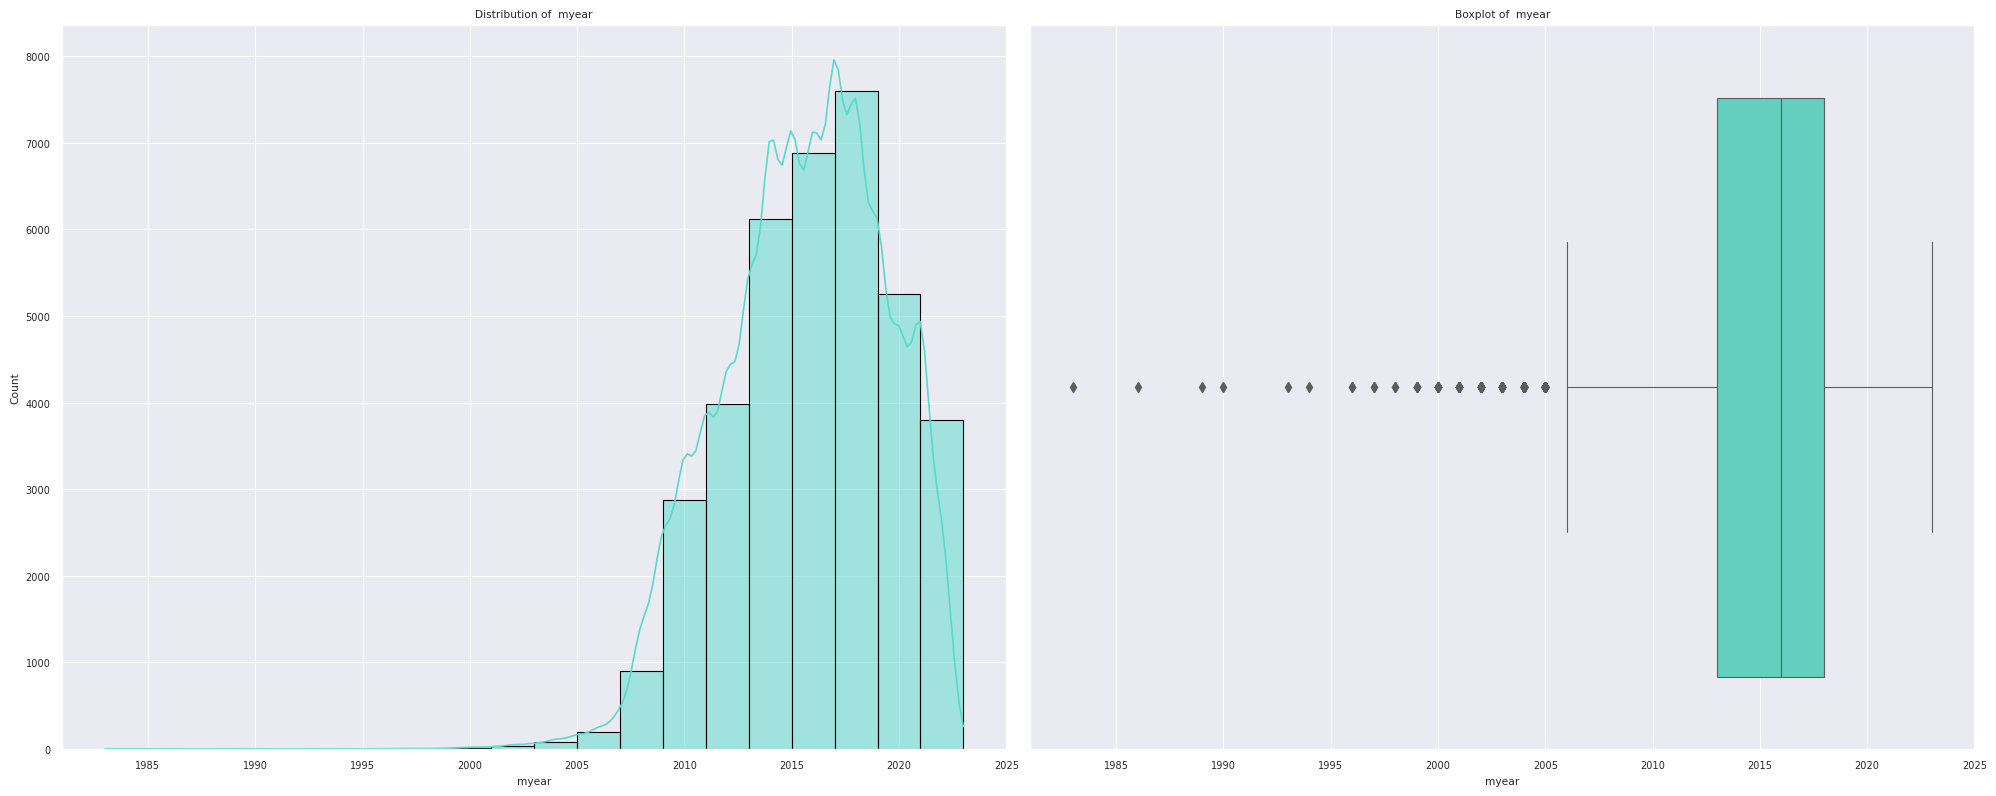

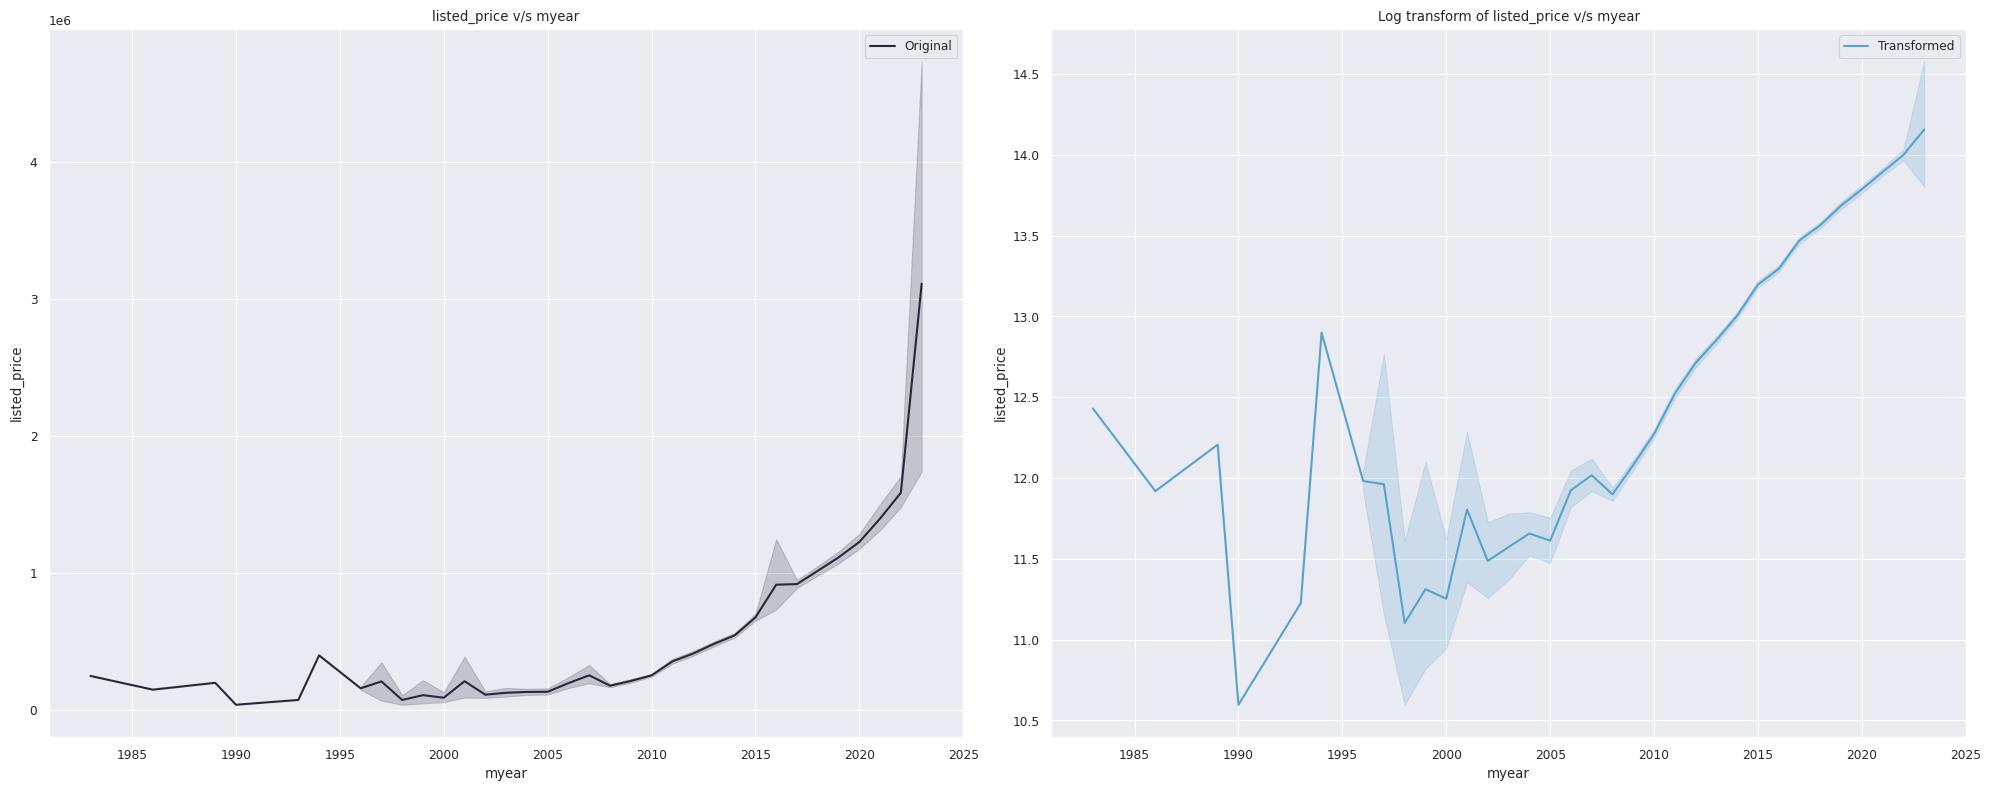

In [11]:
feature_dist_plots(df2, 'myear', linewidth=0.8, sat=0.8);
target_relation_plots(df, col='myear', figsize=(20, 8), linewidth = 1.5, fontscale=1);

The distribution shows that there are not many cars before 2005. Let's see the cumilitive number of cars in ~5 year time periods. Next we would also like to see the mean `listed_price` of the cars of year before 2005.

In [12]:
df2['myear'].value_counts().sort_index().cumsum().iloc[::5]

1983        1
1994        6
2000       26
2005      224
2010     4121
2015    17695
2020    33963
Name: myear, dtype: int64

#### Suggestions for the columns `myear`

1. **Drop the cars that are manufactured before `2005`** which are 224 in number. We can see that the mean price of the cars manufactored before 2005 is very low compared to the rest of the cars. Even factoring in the exponential nature of the variable's relation with price, it can be seen that the pre-2005 data is **very noisy**.

#### Observations for the columns `myear`
1. The price increases exponentially with the year of manufacting 

In [13]:
def myear_transformation(df: pd.DataFrame):
    df = df[df['myear'] > 2005]
    
suggested_transformations.append(myear_transformation)

---


### `body`
*Body type of the car*

In [14]:
dic = analyze_data(df2, 'body', n = 11);

Overview of column "body"
+----------------+----------------------+
|    Measure     |        Value         |
+----------------+----------------------+
| Distinct Count |          11          |
|   Distinct %   | 0.02912981303956358  |
| Missing Count  |          18          |
|   Missing %    | 0.047666966792013134 |
+----------------+----------------------+


Column body is not numeric
Common values for column "body"
+-----------------+-------+----------------------+--------------------+
|      Value      | Count |      Frequency       |   Mean of Target   |
+-----------------+-------+----------------------+--------------------+
|    hatchback    | 15053 |  39.88183552352692   | 386817.0898824155  |
|      sedan      | 10530 |   27.8984739296312   | 805835.2949667616  |
|       suv       |  9793 |  25.94584569732938   | 1266698.3898703156 |
|       muv       |  1815 |  4.808711318355235   | 899833.4683195592  |
|     minivans    |  391  |  1.0359262399321747  | 330608.6854219949  |
|

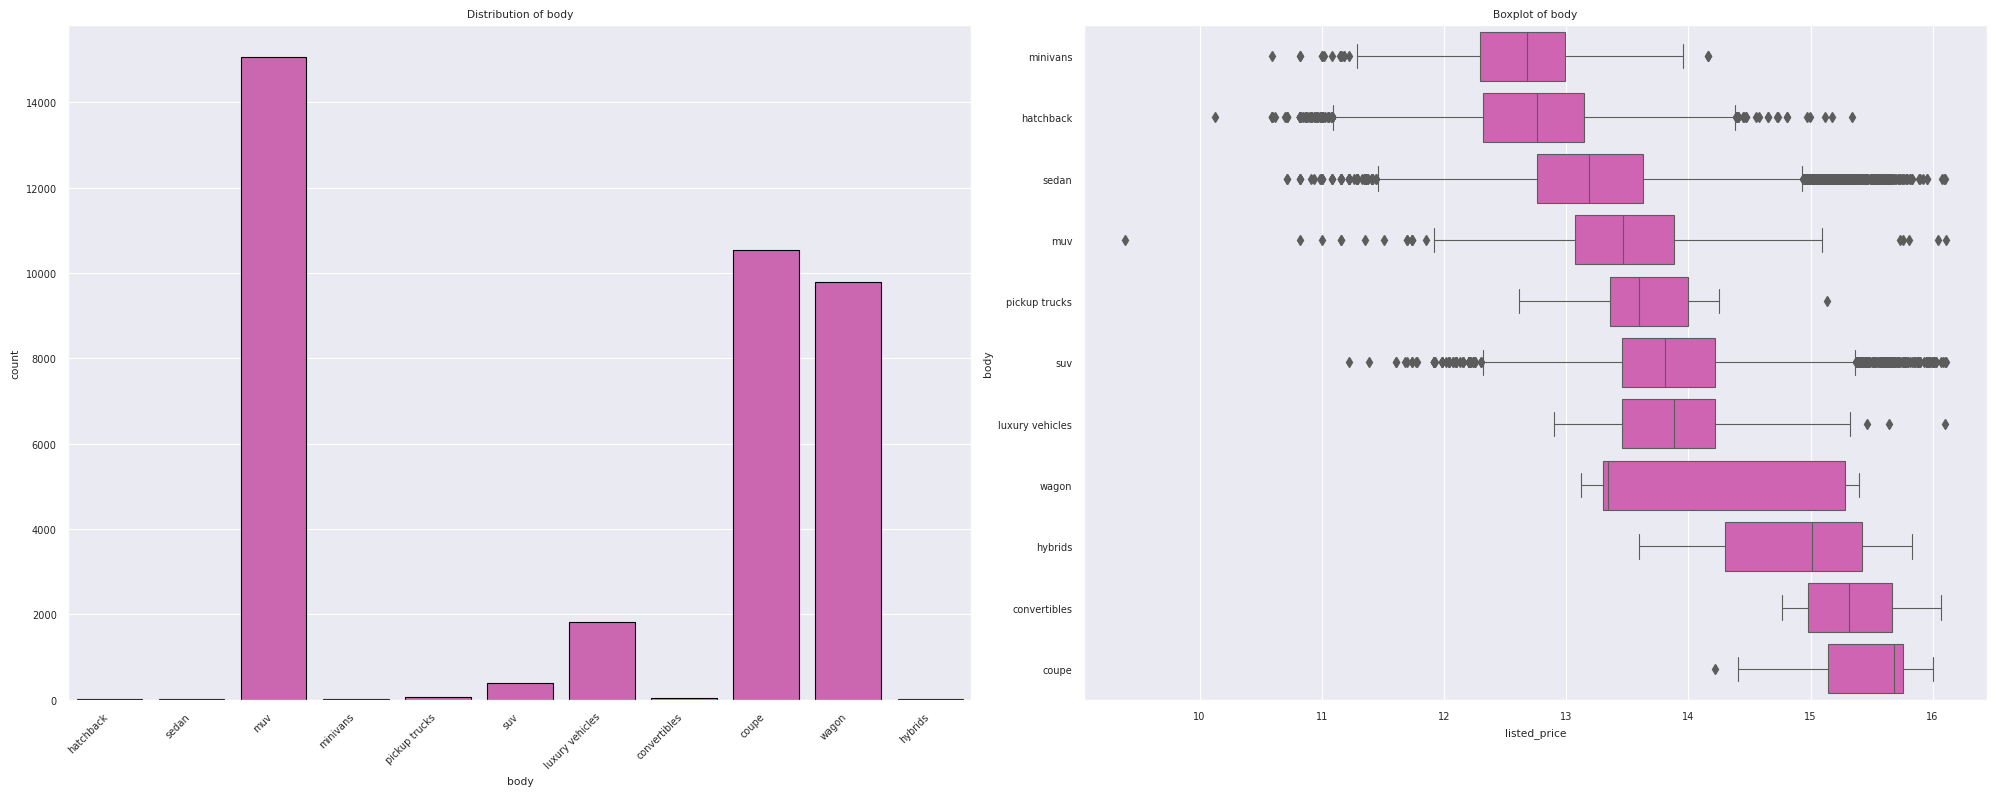

In [15]:
feature_dist_plots(df2, 'body', linewidth=0.8, sat=0.8, transformation=np.log);

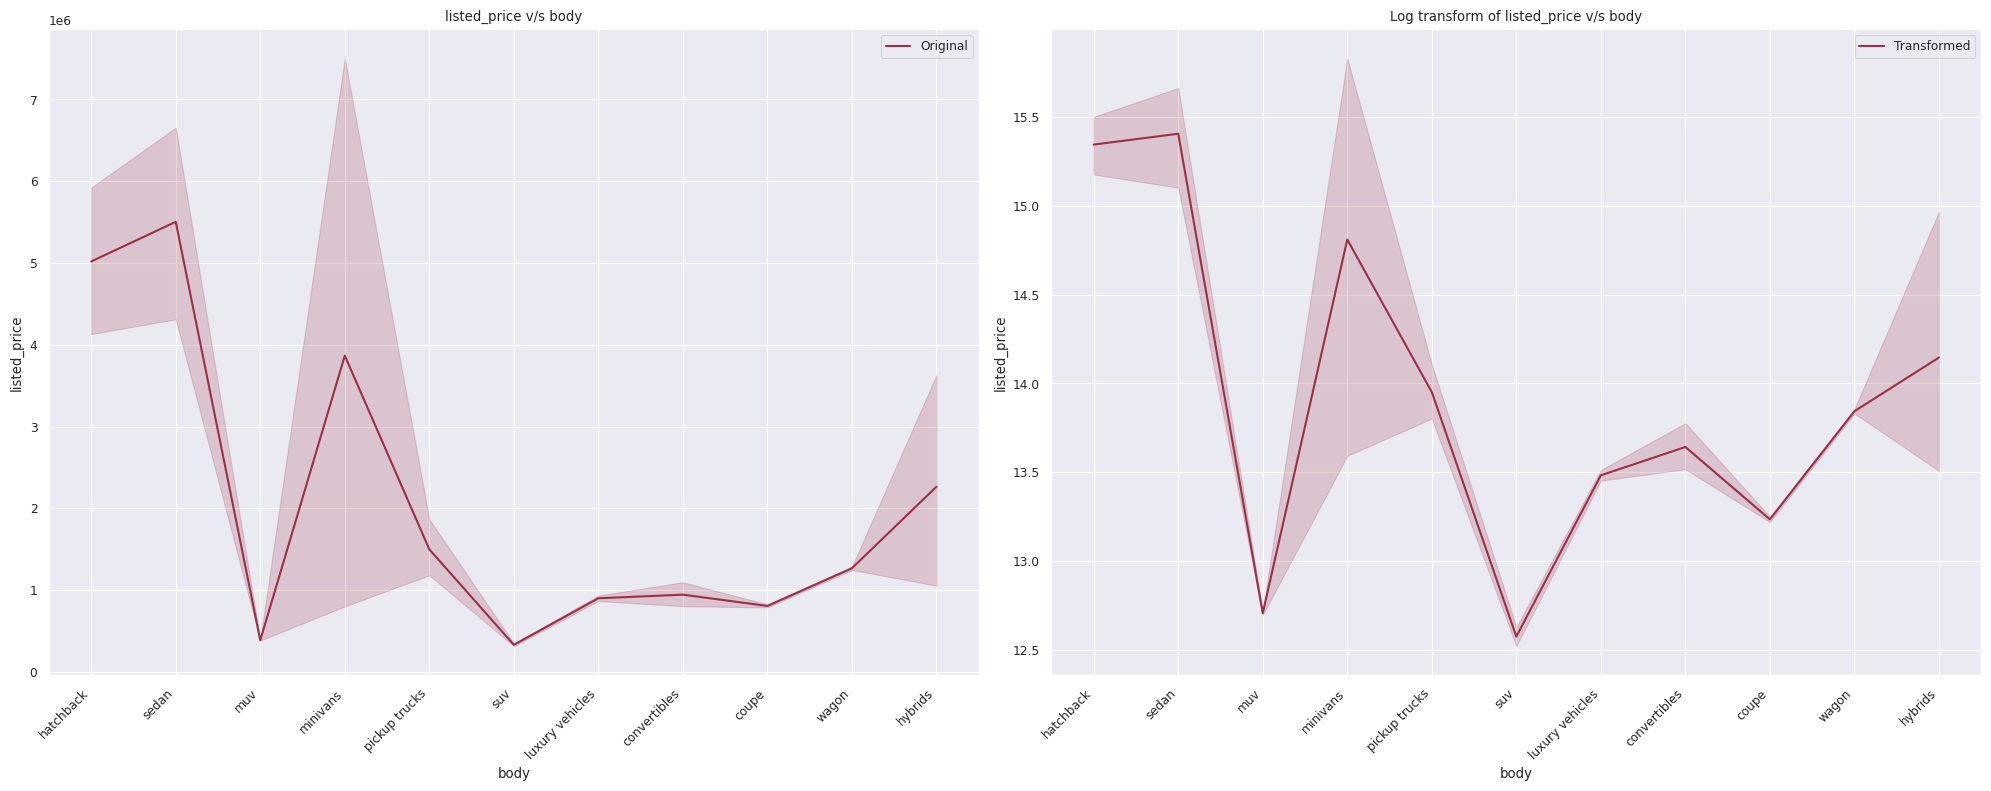

In [16]:
target_relation_plots(df2, col='body', linewidth = 1.5, fontscale=1);

#### Suggestions for the column `body`

Everything seems to be fine here, except 7 of out of the 11 categories have cars which are less than 100 number. Still, it would not be too bad for the model to look at the cars from these categories as well.

#### Observations for the column `body`

Hatchbacks, sedans and SUVs make up for almost 95% of the cars in our dataset!

---

### `transmission`
*Transmission type of the car*

In [17]:
dic = analyze_data(df2, 'transmission');

Overview of column "transmission"
+----------------+----------------------+
|    Measure     |        Value         |
+----------------+----------------------+
| Distinct Count |          2           |
|   Distinct %   | 0.005296329643557015 |
| Missing Count  |          0           |
|   Missing %    |         0.0          |
+----------------+----------------------+


Column transmission is not numeric
Common values for column "transmission"
+-----------+-------+--------------------+--------------------+
|   Value   | Count |     Frequency      |   Mean of Target   |
+-----------+-------+--------------------+--------------------+
|   manual  | 28893 | 76.51342619564642  | 523817.7813657287  |
| automatic |  8869 | 23.486573804353583 | 1546189.9523057842 |
+-----------+-------+--------------------+--------------------+




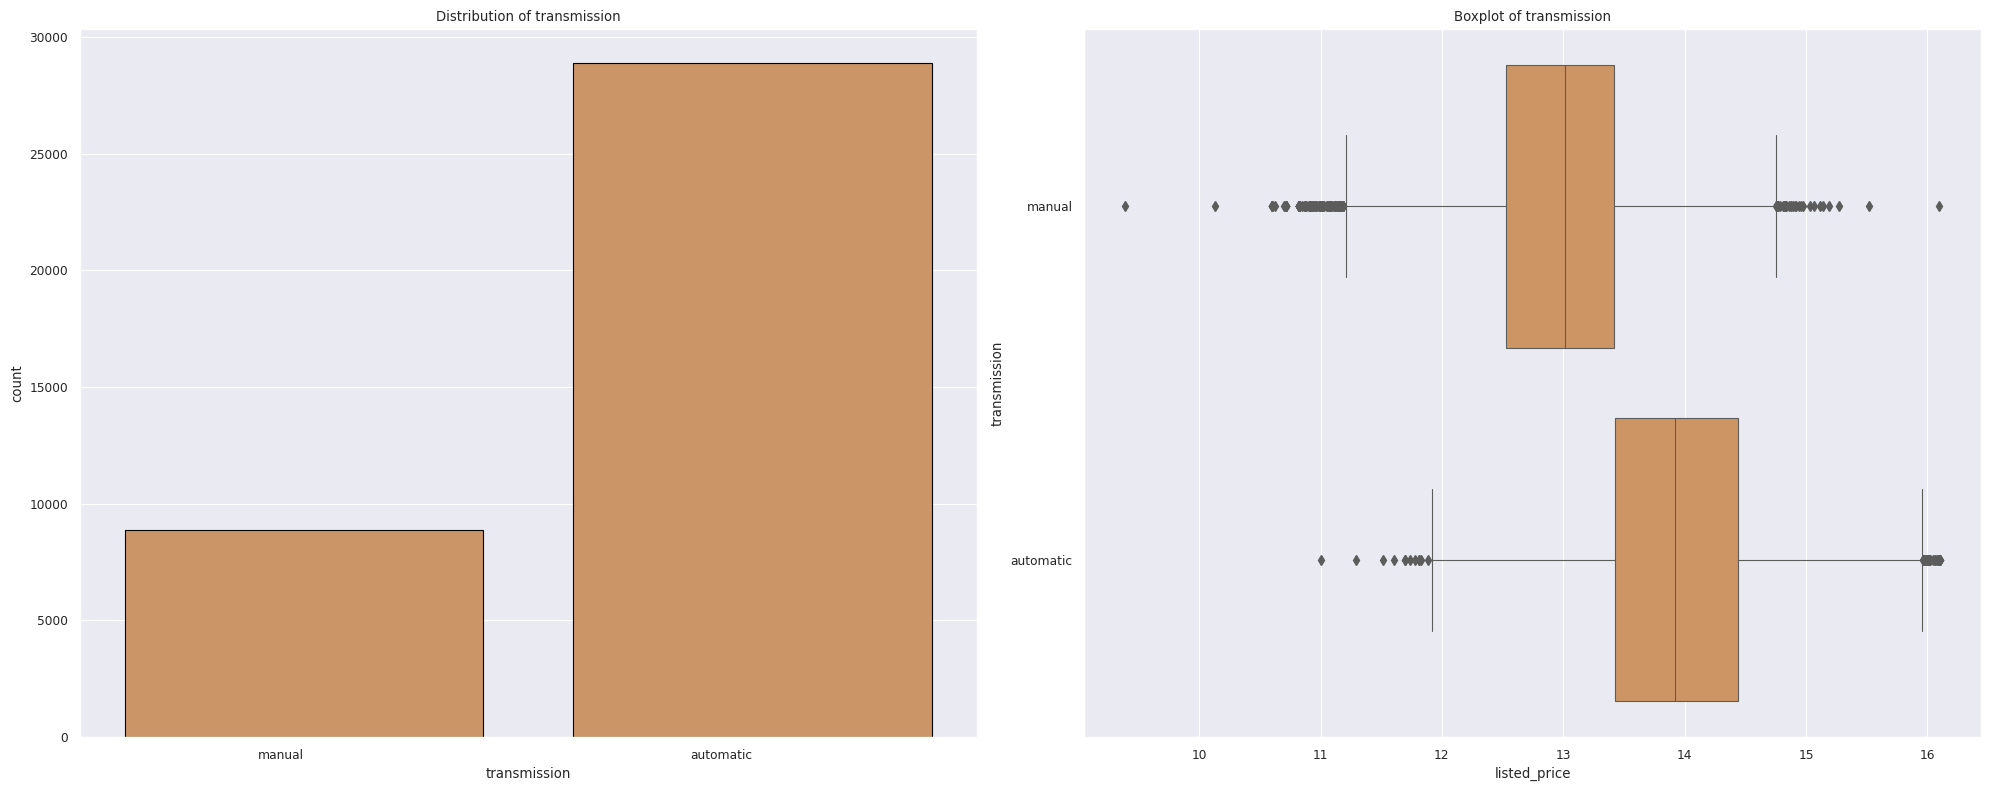

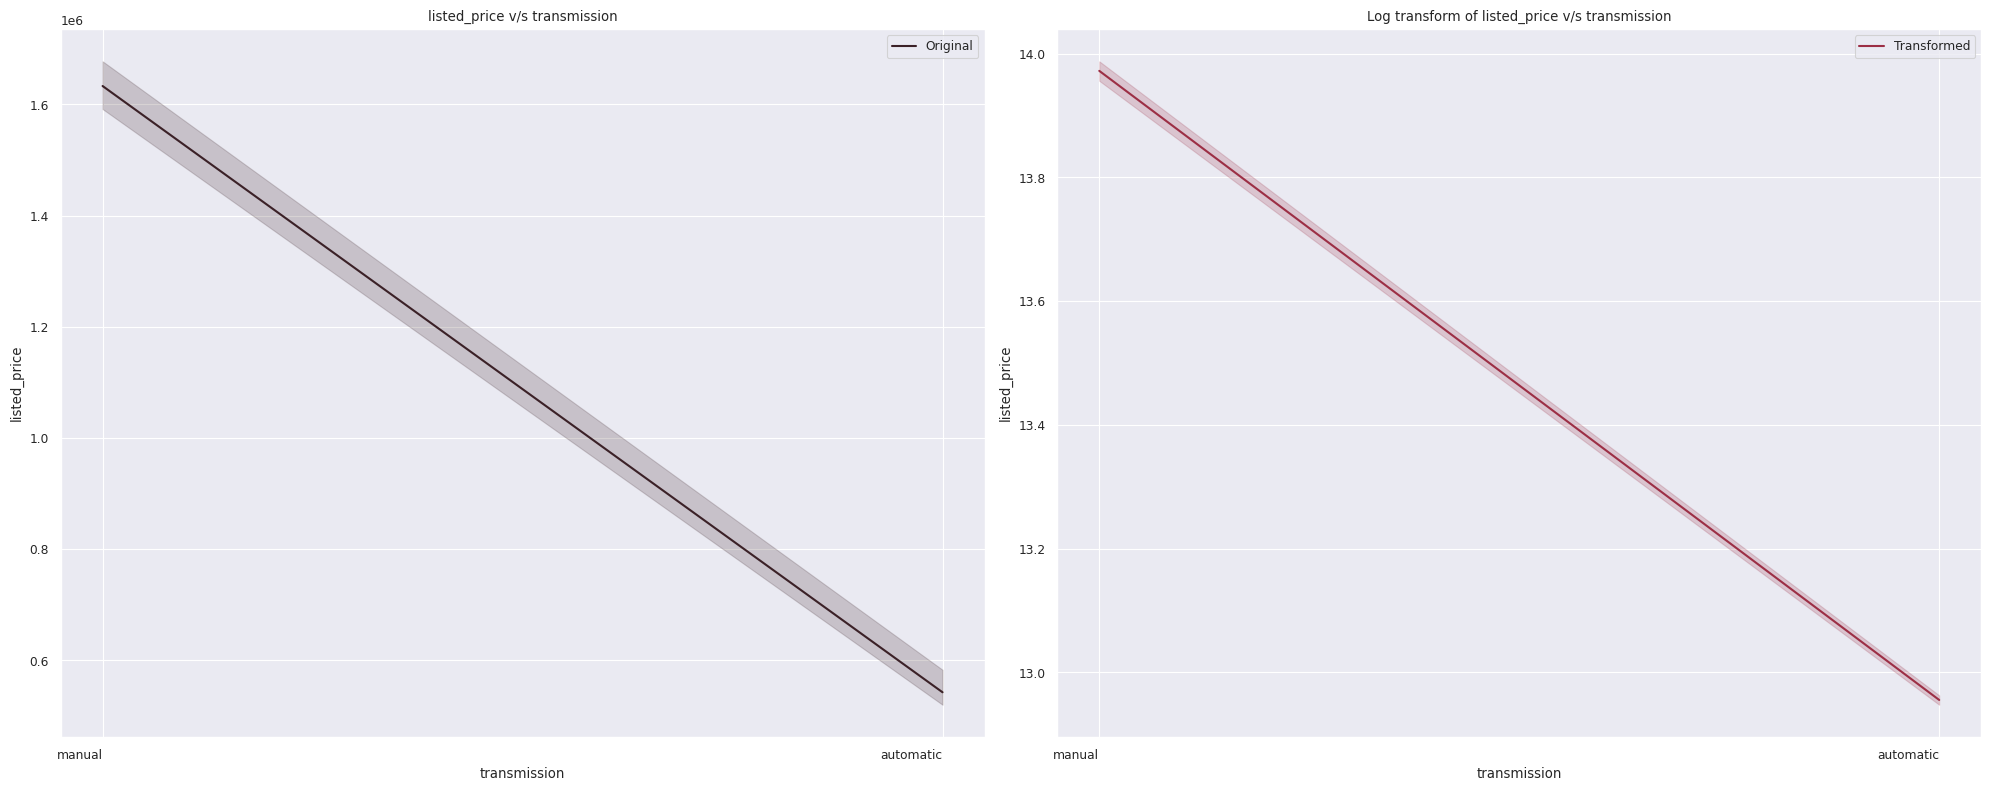

In [18]:
feature_dist_plots(df2, 'transmission', linewidth=0.8, sat=0.8, fontscale=1, transformation=np.log, rotation=0);
target_relation_plots(df, col='transmission', linewidth = 1.5, fontscale=1, rotation=0);

#### Suggestions for the column `transmission`
Everything seems to be fine.

#### Observations for the column `transmission`
There are a lot more manual cars than automatic cars and automatic cars are a lot more expensive.

---

### `fuel`
*The type of fuel used by the car*

In [19]:
analyze_data(df2, 'fuel');

Overview of column "fuel"
+----------------+----------------------+
|    Measure     |        Value         |
+----------------+----------------------+
| Distinct Count |          5           |
|   Distinct %   | 0.013240824108892536 |
| Missing Count  |          0           |
|   Missing %    |         0.0          |
+----------------+----------------------+


Column fuel is not numeric
Common values for column "fuel"
+----------+-------+--------------------+--------------------+
|  Value   | Count |     Frequency      |   Mean of Target   |
+----------+-------+--------------------+--------------------+
|  petrol  | 21744 | 57.581695884751866 | 611019.4505150847  |
|  diesel  | 14607 | 38.68174355171866  | 1015977.5102348189 |
|   cng    |  1076 | 2.849425348233674  |  457297.279739777  |
|   lpg    |  205  | 0.542873788464594  |  177123.643902439  |
| electric |  130  | 0.344261426831206  | 1485178.4615384615 |
+----------+-------+--------------------+--------------------+




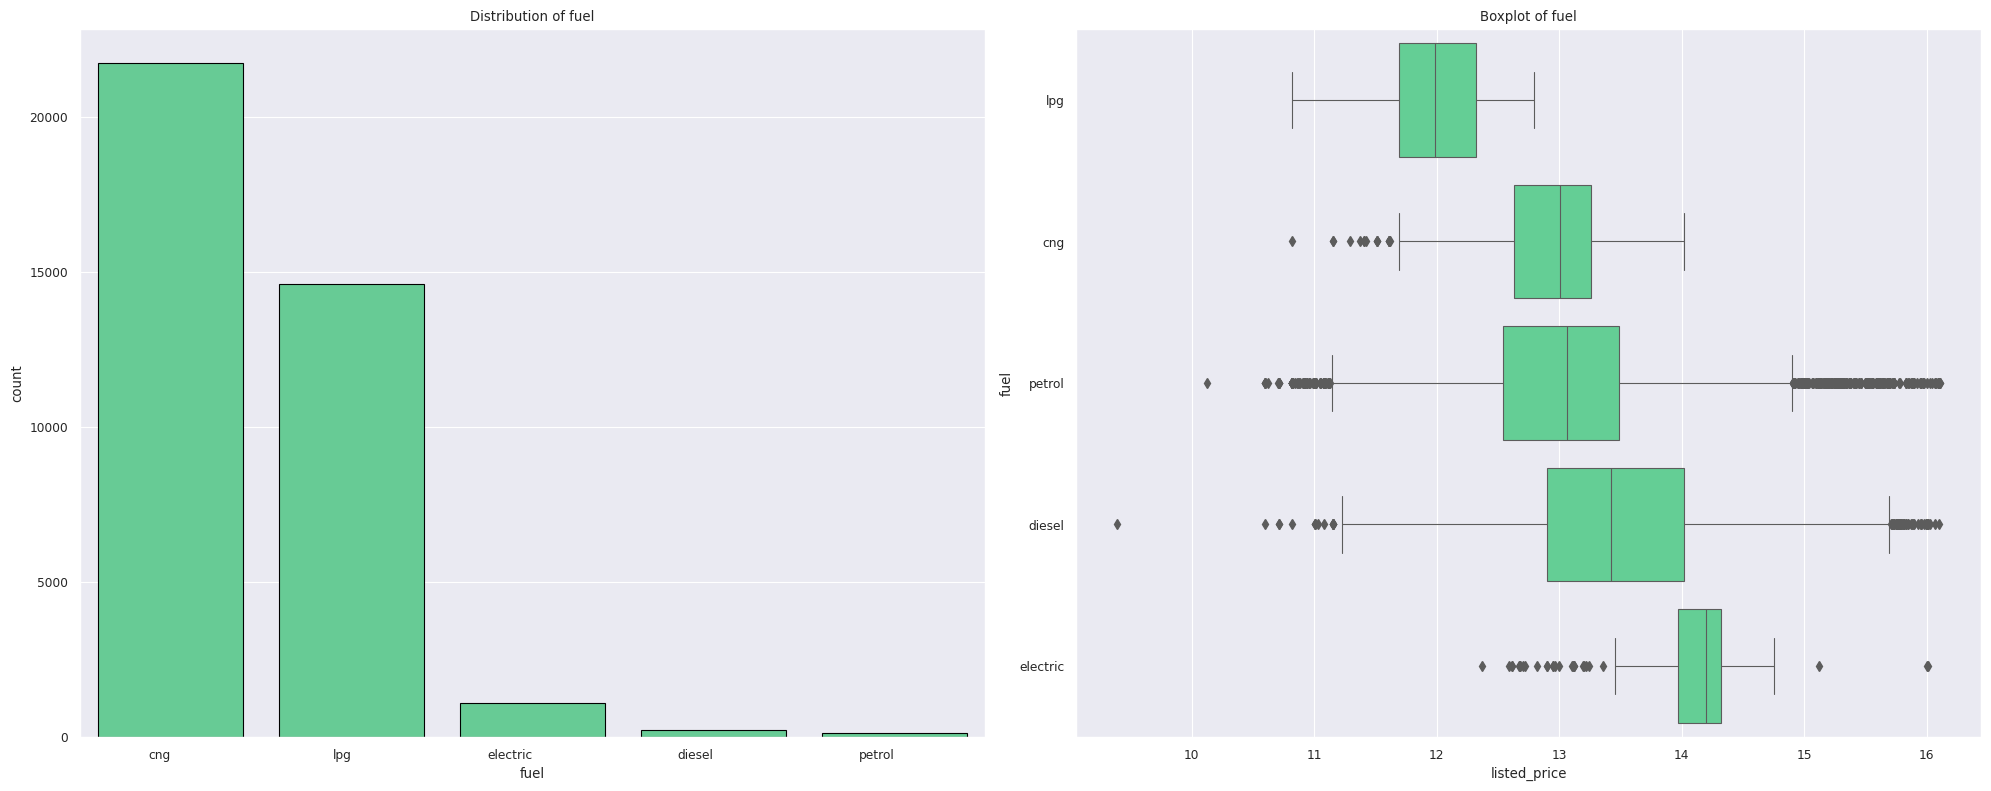

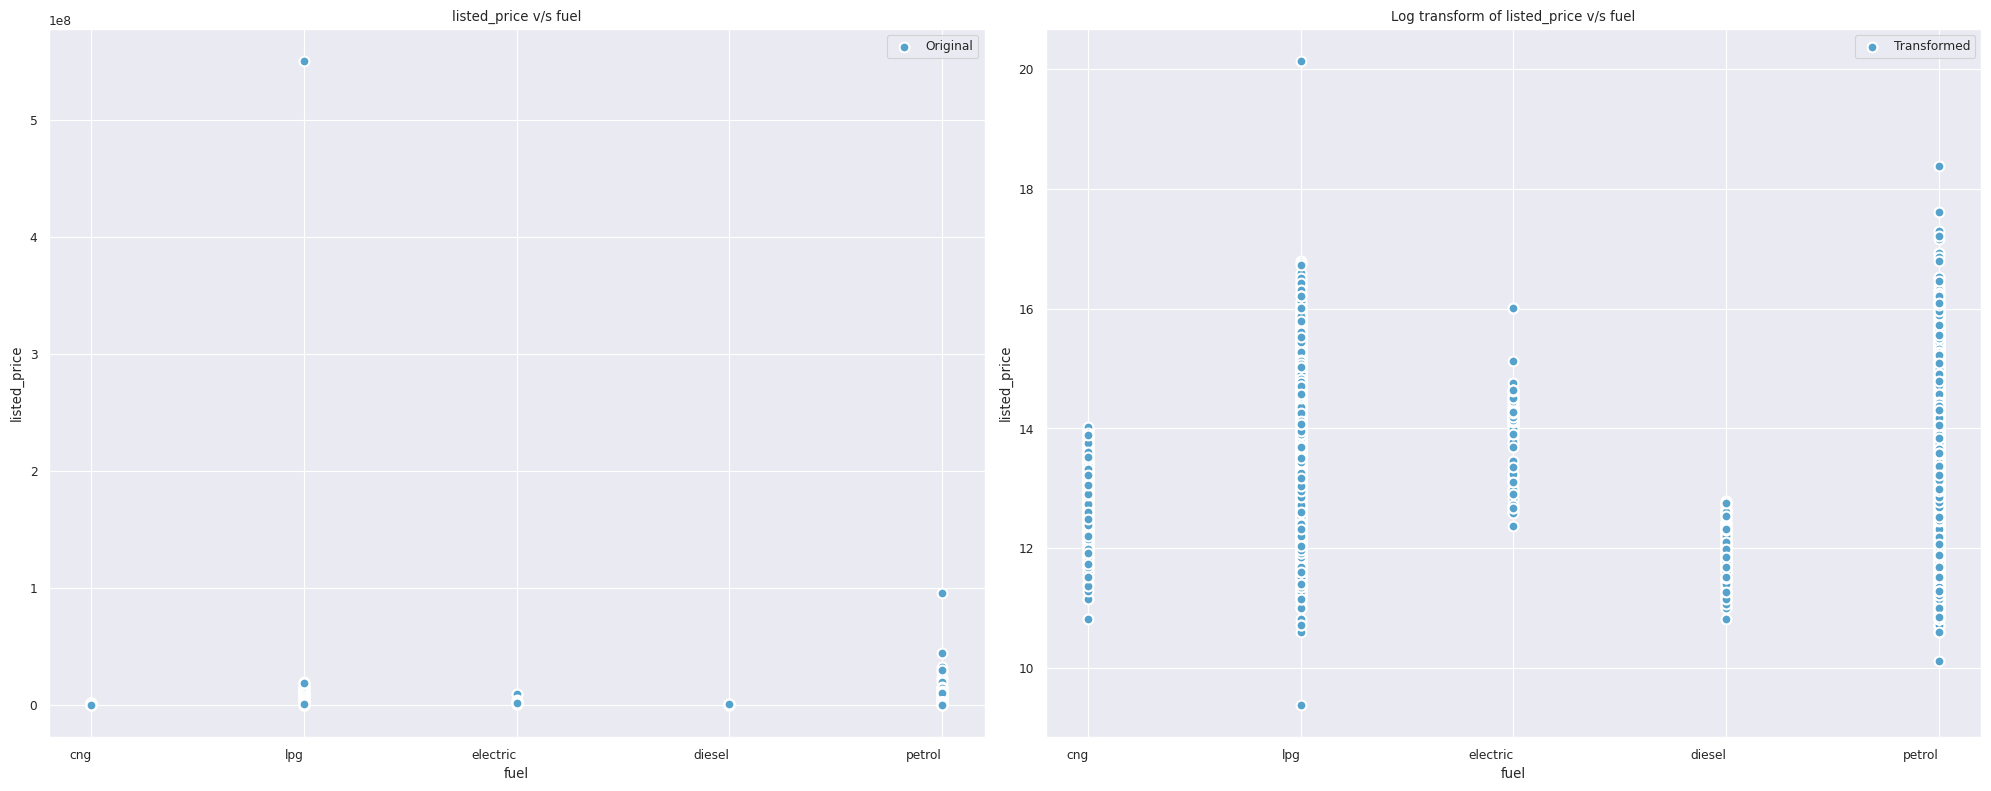

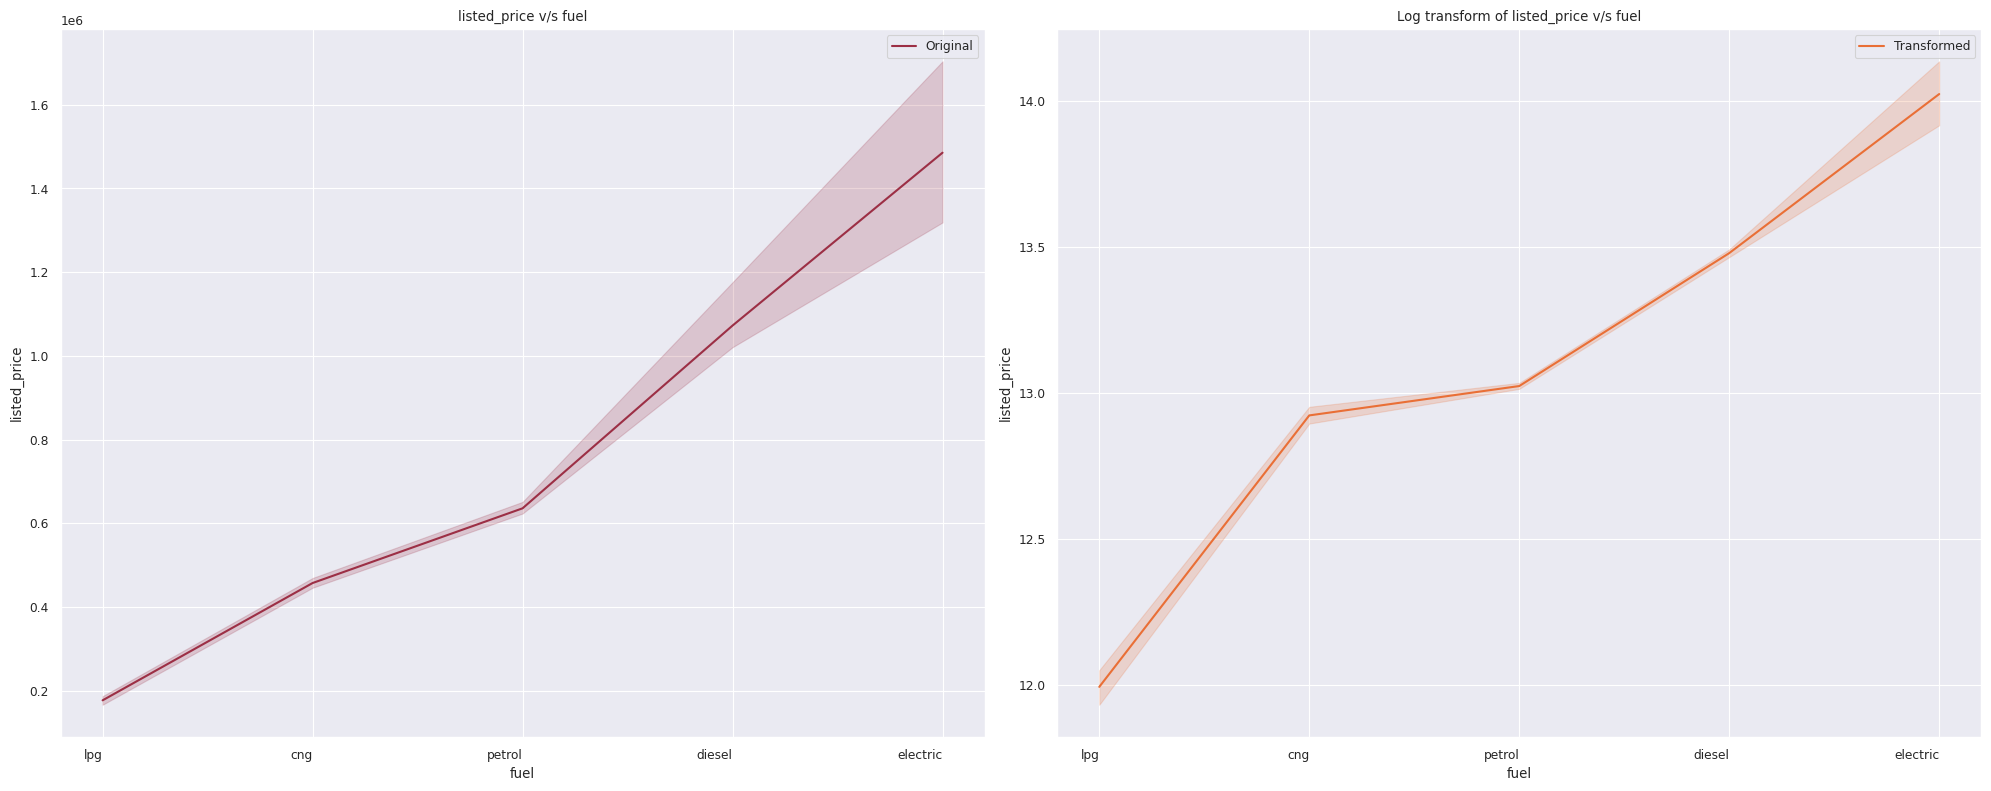

In [20]:
feature_dist_plots(df2, 'fuel', linewidth=0.8, sat=0.8, fontscale=1, transformation=np.log, rotation=0, sorted=True);
target_relation_plots(df, col='fuel', linewidth = 1.5, fontscale=1, rotation=0, plot='scatter', s=50);
target_relation_plots(df, col='fuel', linewidth = 1.5, fontscale=1, rotation=0, sorted=True);

---

### `km`
*The total distance travelled by the car in km*

In [21]:
analyze_data(df2, 'km', descriptive=True);

Overview of column "km"
+----------------+-------------------+
|    Measure     |       Value       |
+----------------+-------------------+
| Distinct Count |       23856       |
|   Distinct %   | 63.17461998834808 |
| Missing Count  |         0         |
|   Missing %    |        0.0        |
|      Mean      | 62464.61596313755 |
|    Minimum     |       101.0       |
|    Maximum     |     6300000.0     |
+----------------+-------------------+


Quantile stats for column "km"
+---------------------+--------------------+
|      Statistic      |       Value        |
+---------------------+--------------------+
|       Minimum       |       101.0        |
|    5th Percentile   |      10000.0       |
|  First Quartile, Q1 |      31817.75      |
|        Median       |      56803.0       |
|  Third Quartile, Q3 |      83362.75      |
|   95th Percentile   | 132491.44999999995 |
|       Maximum       |     6300000.0      |
|        Range        |     6299899.0      |
| Interquartile Ran

In [22]:
df2[df2['km'] > 300000].shape

(46, 66)

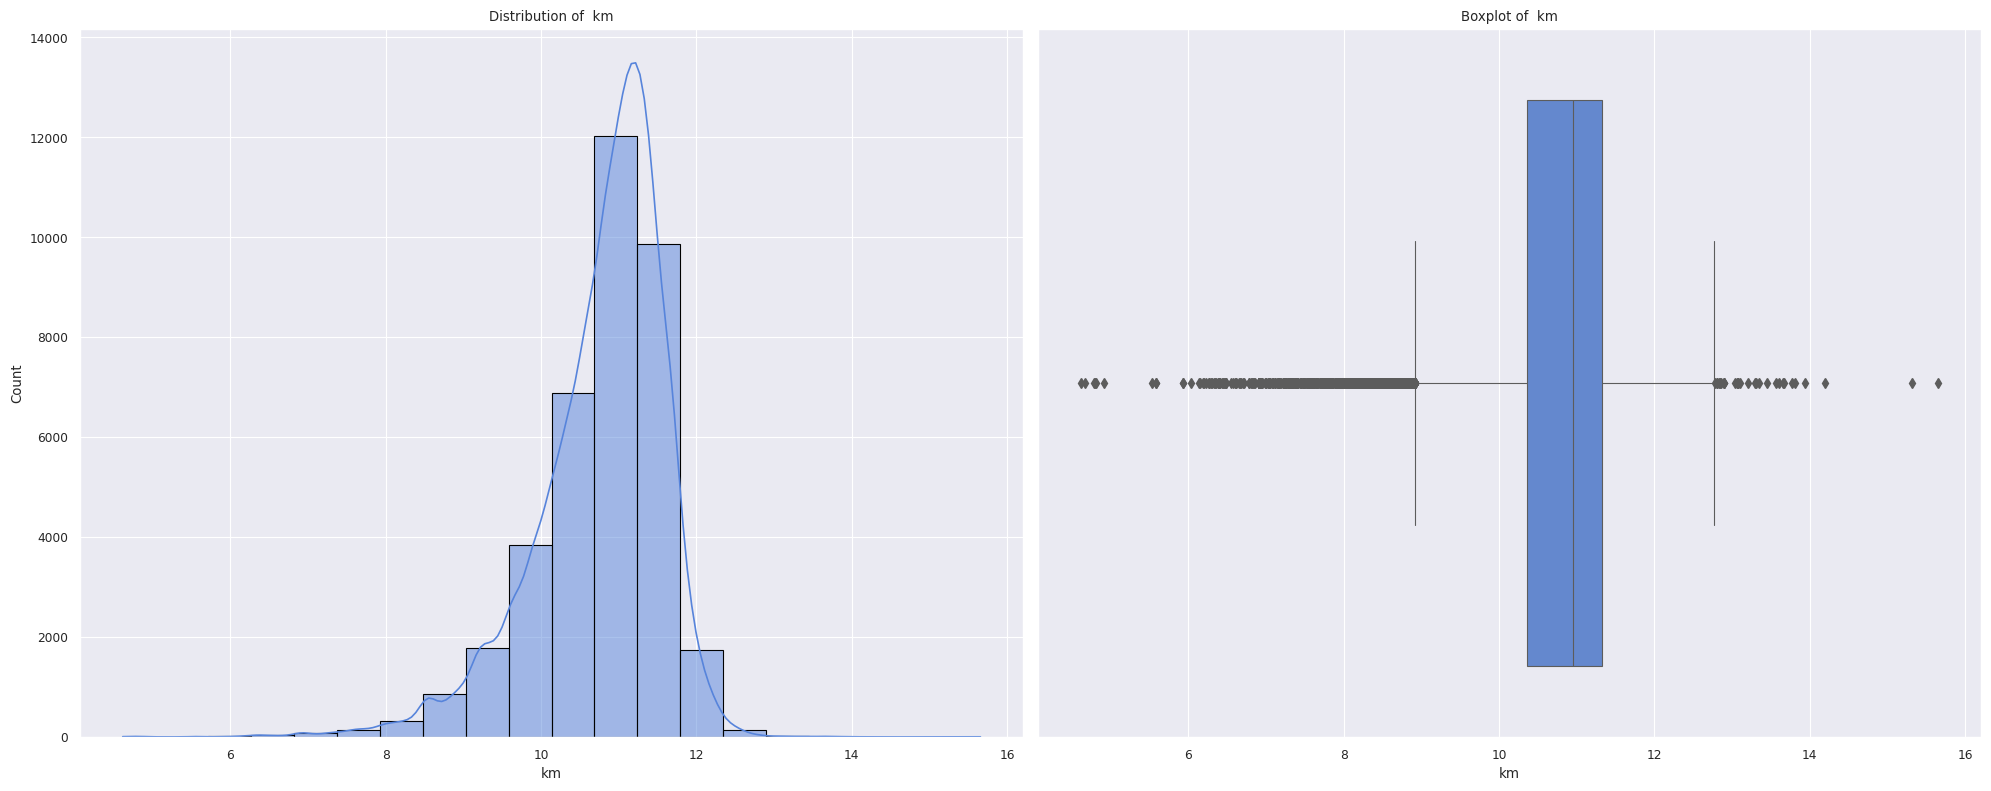

In [23]:
feature_dist_plots(df2, 'km', linewidth=0.8, sat=0.8, fontscale=1, hist_transformation=np.log, rotation=0);

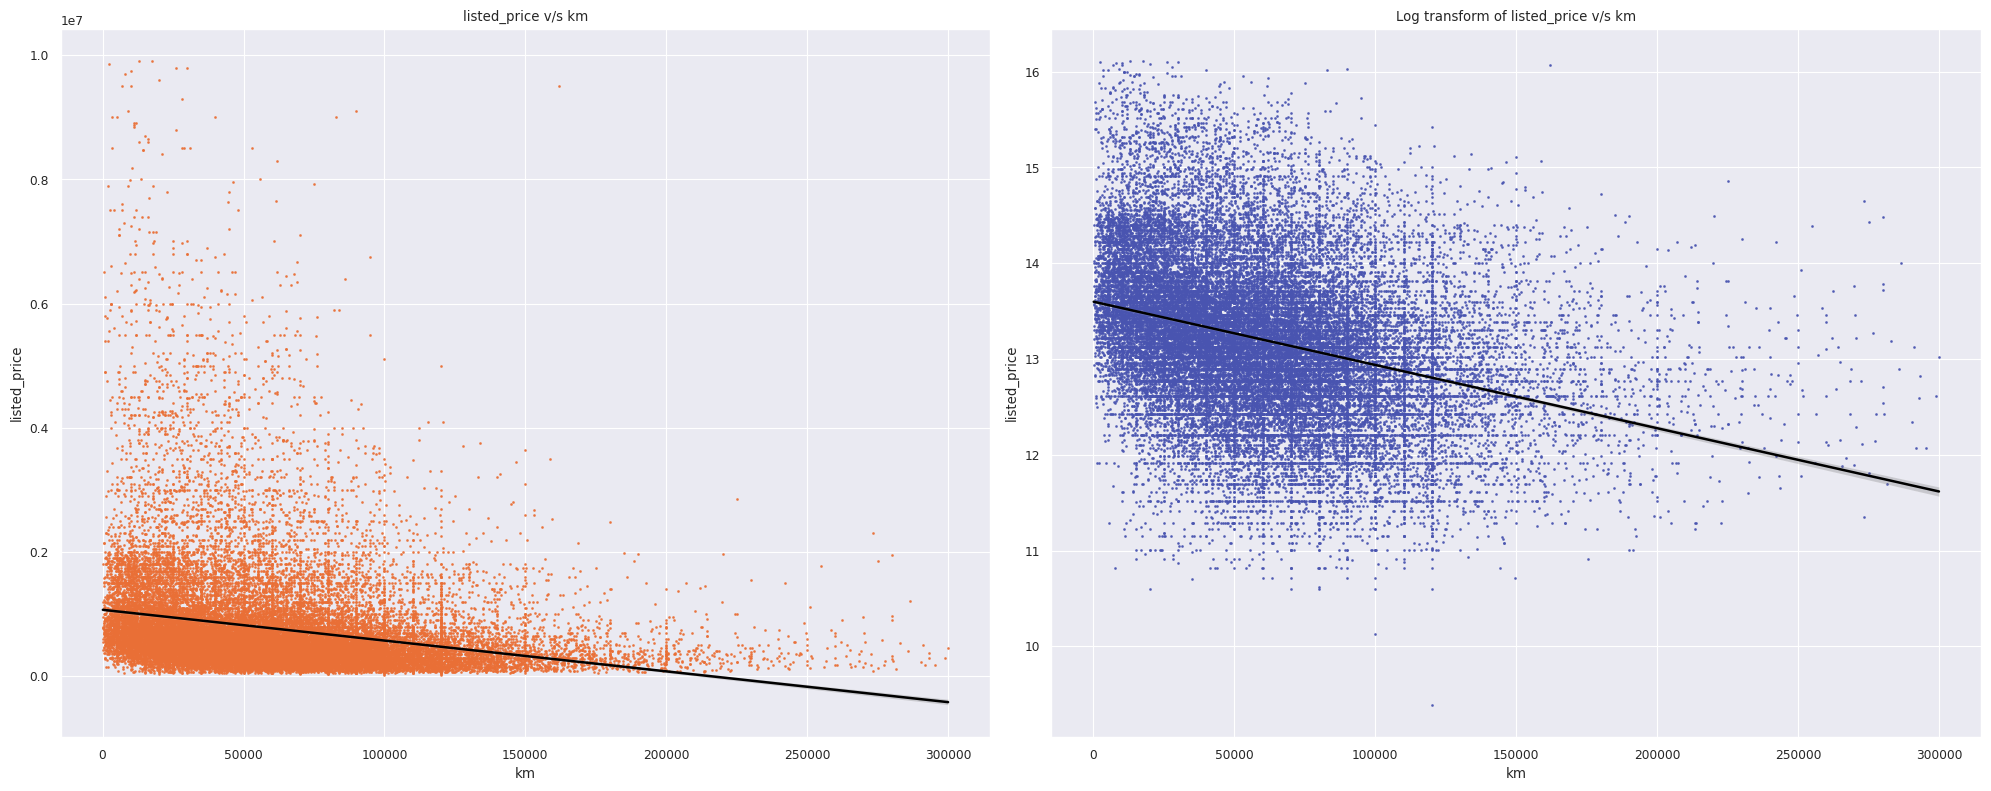

In [24]:
target_relation_plots(df2[df2['km'] < 300000], col='km', fontscale=1, transformation=np.log, plot='reg', scatter_kws={'s':1}, line_kws={'color': 'black'}, order=1);

---

### `ip`

In [25]:
analyze_data(df2, 'ip', categorical = True);

Overview of column "ip"
+----------------+----------------------+
|    Measure     |        Value         |
+----------------+----------------------+
| Distinct Count |          2           |
|   Distinct %   | 0.005296329643557015 |
| Missing Count  |          0           |
|   Missing %    |         0.0          |
+----------------+----------------------+


Quantile stats for column "ip"
+---------------------+-------+
|      Statistic      | Value |
+---------------------+-------+
|       Minimum       |   0   |
|    5th Percentile   |  0.0  |
|  First Quartile, Q1 |  0.0  |
|        Median       |  0.0  |
|  Third Quartile, Q3 |  0.0  |
|   95th Percentile   |  0.0  |
|       Maximum       |   1   |
|        Range        |   1   |
| Interquartile Range |  0.0  |
+---------------------+-------+


Common values for column "ip"
+-------+-------+--------------------+-------------------+
| Value | Count |     Frequency      |   Mean of Target  |
+-------+-------+--------------------+---

In [26]:
annova_test(df2, 'ip');

Null Hypothesis: There is no difference between groups of ip
+----------------------+-------------------+------------------------+------+-----+-------+
|         F(c)         |    F statistic    |         pvalue         |  q   | dfd |  dfn  |
+----------------------+-------------------+------------------------+------+-----+-------+
| 0.051293364060334516 | 174.2392452599122 | 1.0748832219341703e-39 | 0.05 |  2  | 37762 |
+----------------------+-------------------+------------------------+------+-----+-------+


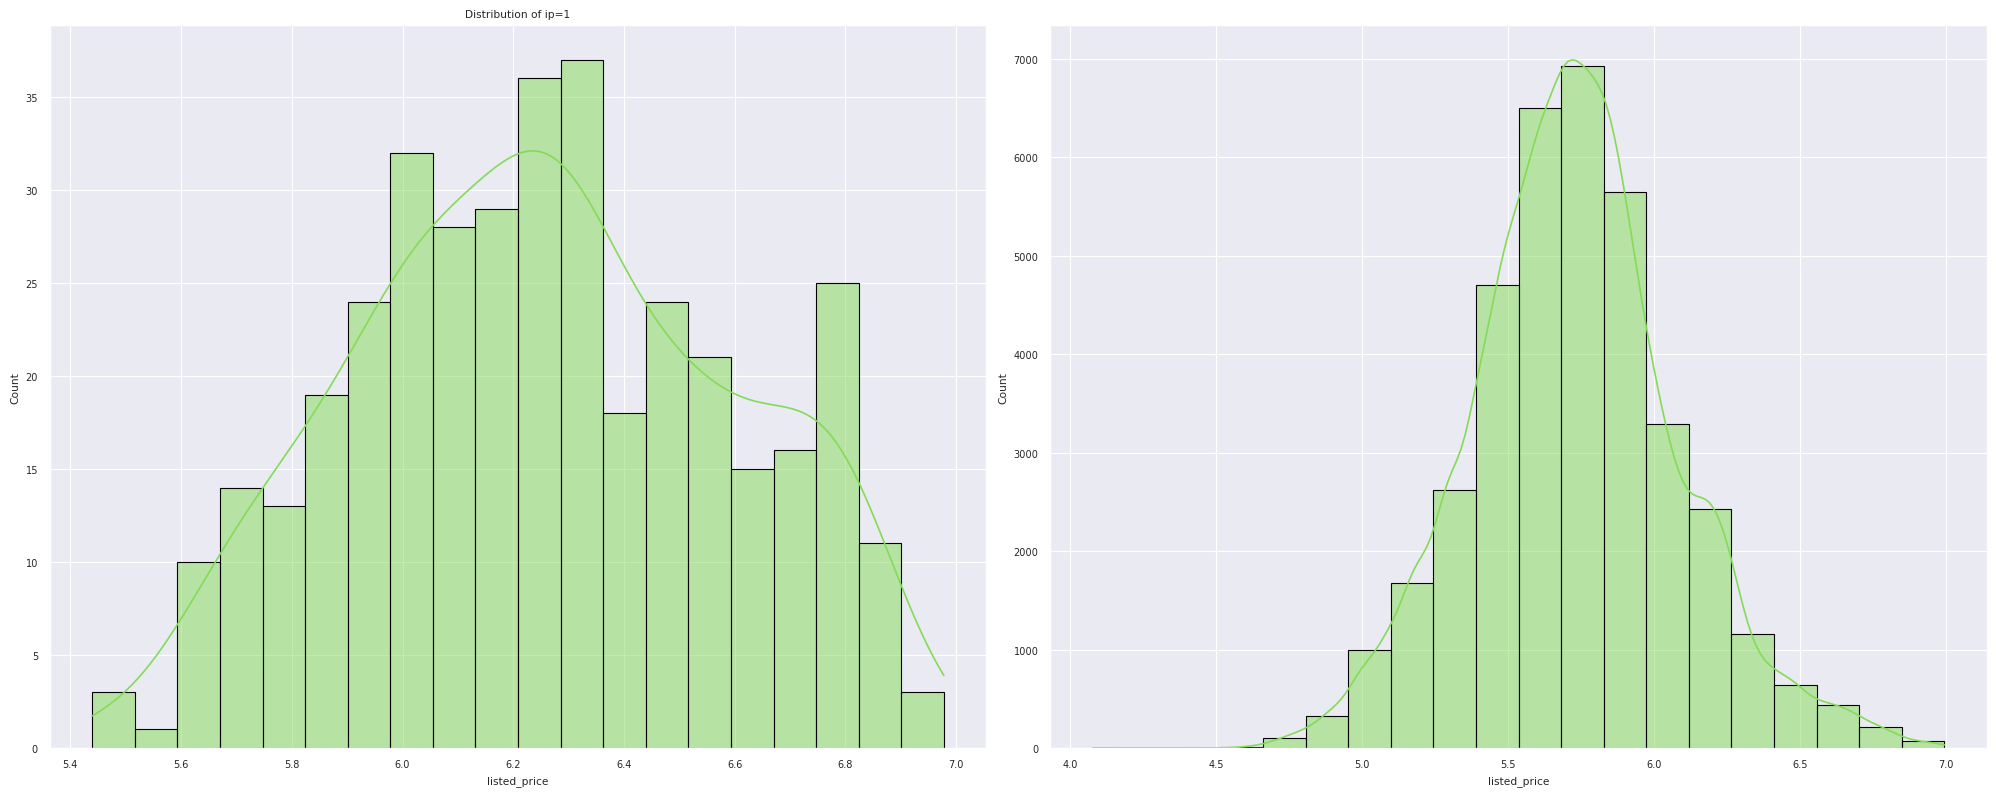

In [27]:
sns.set_style('darkgrid')
sns.set_context('paper', font_scale=0.8)
plt.rcParams['figure.dpi'] = 100

color=random.choice(sns.color_palette("hls", 15))
fig, ax = plt.subplots(1, 2, figsize=(20,8))

sns.histplot(x=df2[df2['ip'] == 1][TARGET].apply(np.log10), kde=True, ax=ax[0], edgecolor='black', color=color, bins=20)
sns.histplot(x=df2[TARGET].apply(np.log10), kde=True, ax=ax[1], edgecolor='black', color=color, bins=20)
ax[0].set_title(f'Distribution of ip=0')
ax[0].set_title(f'Distribution of ip=1')
plt.tight_layout()
plt.show()

#### Suggestions for the column `ip`
1. It is evident that this is important for the model. But actually, *I have no idea what this variable might indicate*.
2. We should decide later if we could keep the column given it's strong relation with the listes price

---

### `images`, `imgCount` and `threesixty`
Has the link to all the images of the car uploaded in the website and the number of images. `threesixty` tells us if the car has a three sixty image

### Suggestion
Since we will not be using images in our machine learning model, we can **drop** these columns

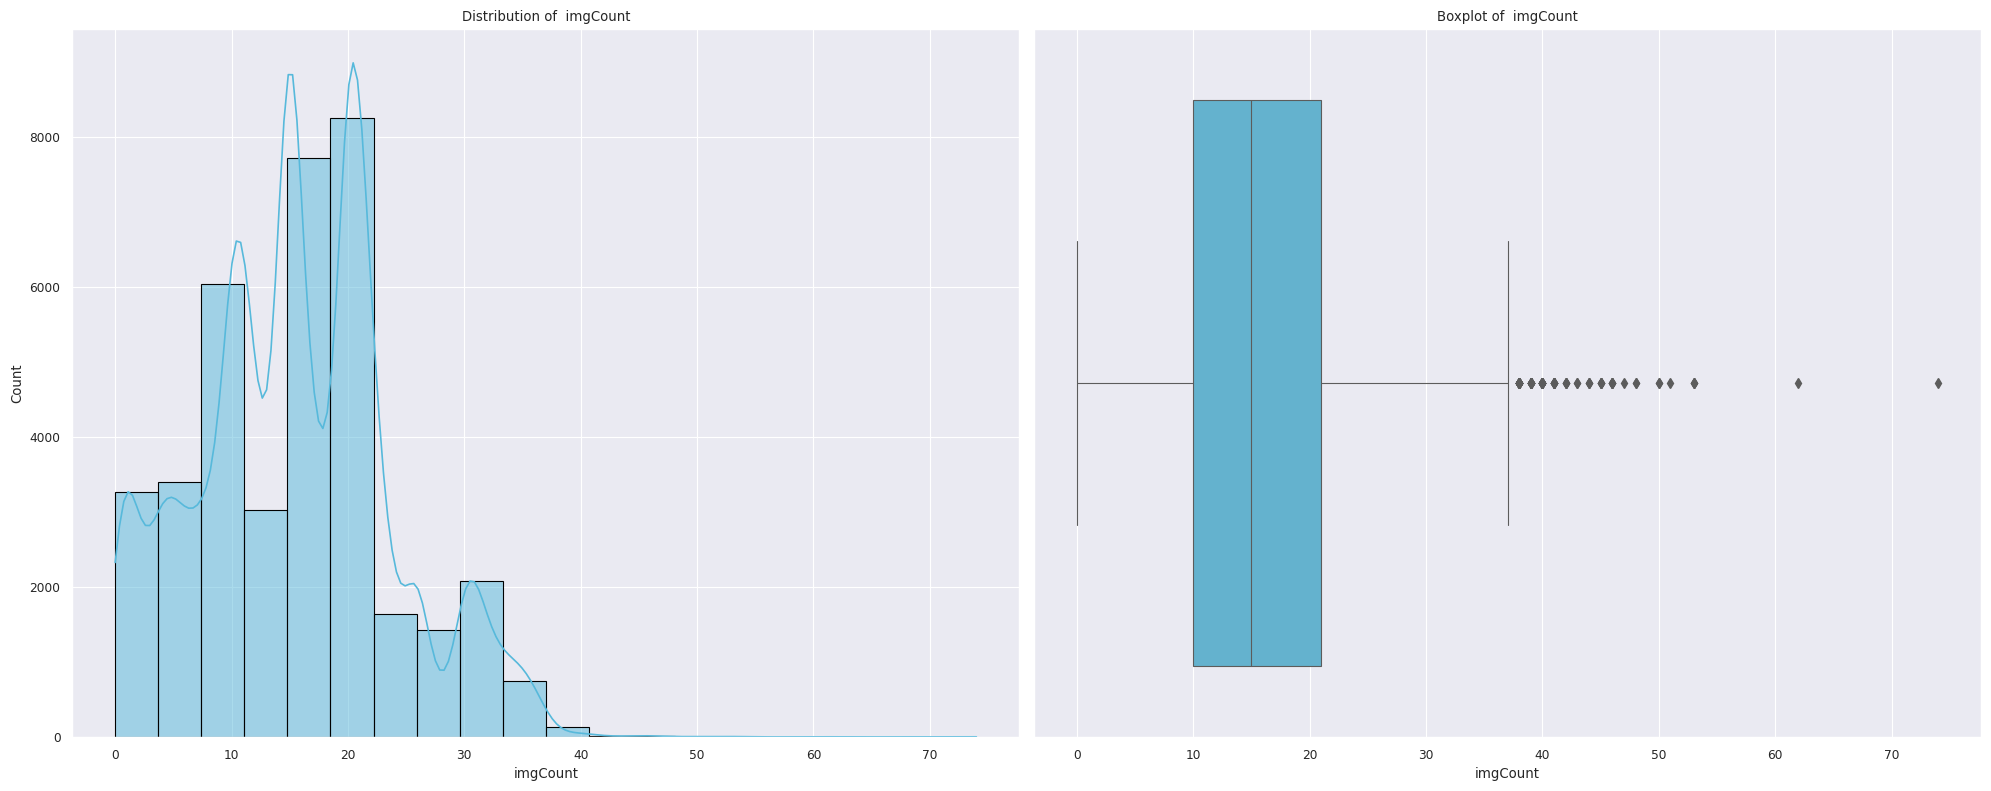

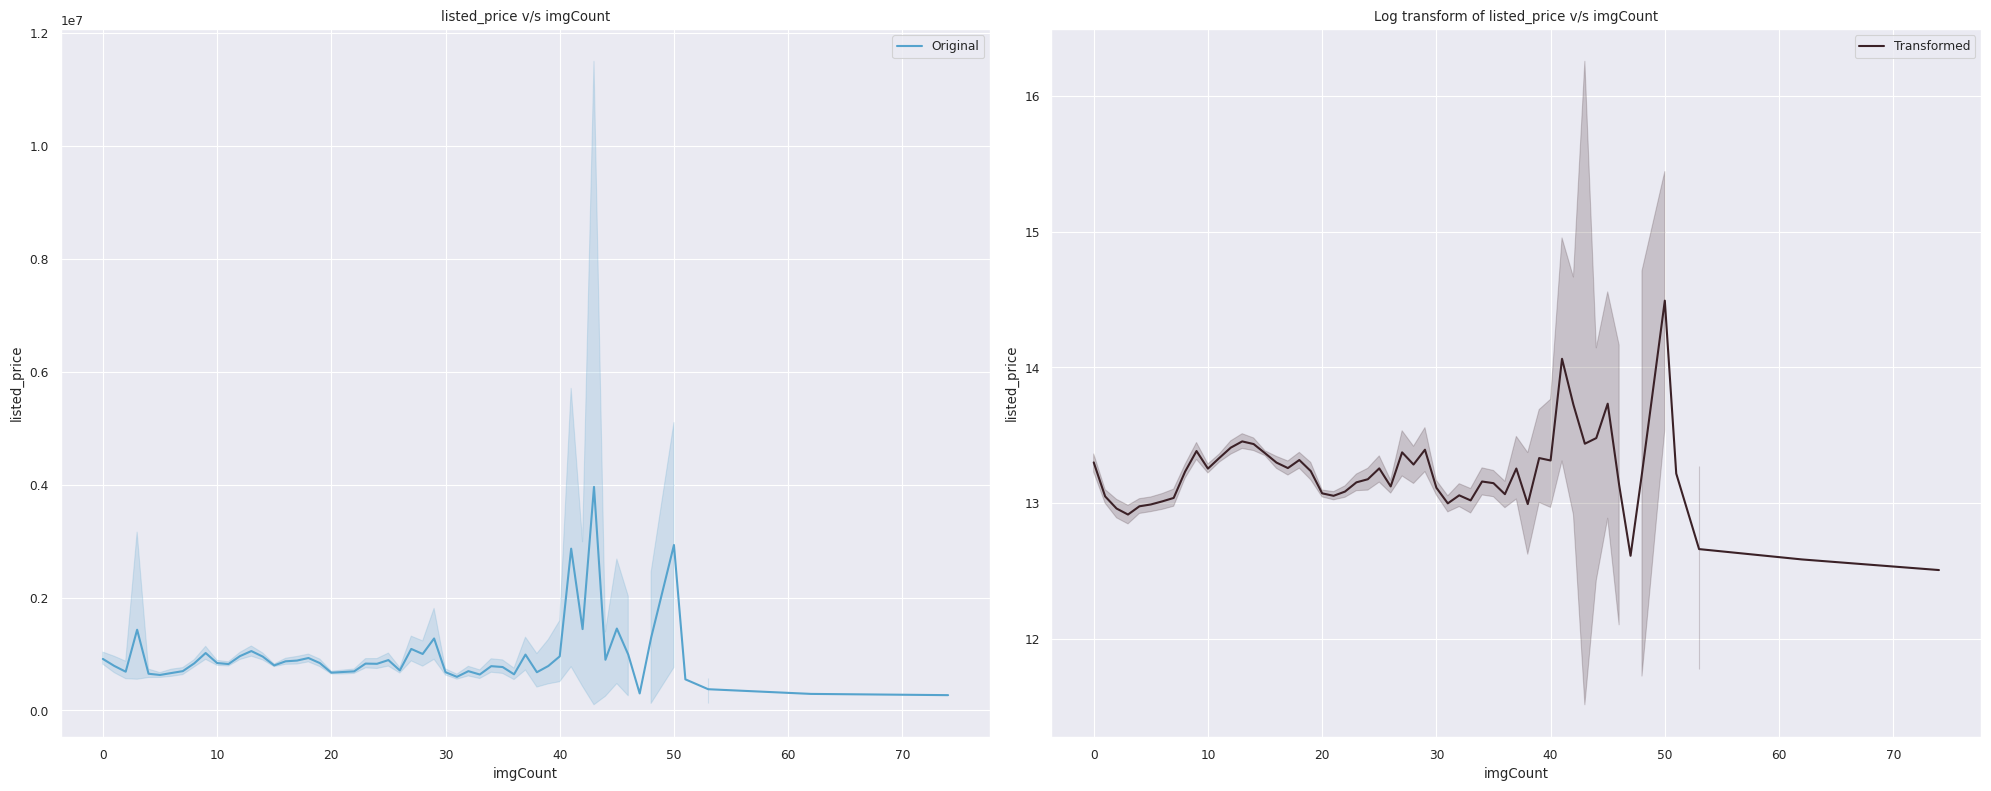

In [28]:
feature_dist_plots(df2, 'imgCount', linewidth=0.8, sat=0.8, fontscale=1, transformation=np.log, rotation=0, sorted=True);
target_relation_plots(df, col='imgCount', linewidth = 1.5, fontscale=1, rotation=0, sorted=True);

In [29]:
def images_transformation(df: pd.DataFrame):
    """
    Drop the column 'images' from the dataframe
    """
    df.drop('images', axis=0, inplace=True)
    return


def imgCount_transformation(df: pd.DataFrame):
    """
    Drop the column 'imgCount' from the dataframe
    """
    df.drop('imgCount', axis=0, inplace=True)
    return


def threesixty_transformation(df: pd.DataFrame):
    """
    Drop the column 'threesixty' from the dataframe
    """
    df.drop('threesixty', axis=0, inplace=True)
    return

suggested_transformations.extend([images_transformation, imgCount_transformation, threesixty_transformation])

---

### `dvn`
The complete name of the car (`oem`, `model`, and `variantName`)

### Issues
The column has a **very HIGH CARDINALITY**. We also know that this column essentially contains the same information as oem, model and variantName combined. Let's do some statistical tests to figure out if we should keep this column.

In [30]:
analyze_data(df2, 'dvn');

Overview of column "dvn"
+----------------+--------------------+
|    Measure     |       Value        |
+----------------+--------------------+
| Distinct Count |        4102        |
|   Distinct %   | 10.862772098935437 |
| Missing Count  |         0          |
|   Missing %    |        0.0         |
+----------------+--------------------+


Column dvn is not numeric
Common values for column "dvn"
+--------------------------+-------+--------------------+--------------------+
|          Value           | Count |     Frequency      |   Mean of Target   |
+--------------------------+-------+--------------------+--------------------+
|     maruti swift vxi     |  347  | 0.9189131931571421 | 506867.0172910663  |
|   maruti alto 800 lxi    |  343  | 0.9083205338700281 | 277069.46064139943 |
|  maruti wagon r lxi cng  |  295  | 0.7812086224246597 | 333173.1627118644  |
| maruti wagon r vxi bs iv |  286  | 0.7573751390286532 | 321161.5979020979  |
|  maruti swift dzire vxi  |  276  | 0.7308

#### ANOVA Test

Since the feature is a *multi-category nominal* variable, Analysis of Variance (ANOVA) would be give us some idea about the importance of the variable.

**$ H_0 $ (null hypothesis)** - There is no difference between groups (i.e. the feature is not very important)

**$ p $ (confidence level)** - 0.05

In [31]:
annova_test(df2, 'dvn');

Null Hypothesis: There is no difference between groups of dvn
+--------------------+--------------------+--------+------+------+-------+
|        F(c)        |    F statistic     | pvalue |  q   | dfd  |  dfn  |
+--------------------+--------------------+--------+------+------+-------+
| 0.9621486507272187 | 21.530499465348345 |  0.0   | 0.05 | 4102 | 37762 |
+--------------------+--------------------+--------+------+------+-------+


Since the $F$ value is so high (much higher than 1 and the ciritcal value) and $p \approx 0$, we can reject the null hypothesis, i.e. the groups are not similar and the feature is **important**.

### Suggestions for `dvn`

Since we know that this column is just a concatenation of the other columns from the dataset, even though it's important we can safely **drop the column**.

In [32]:
def dvn_transformation(df: pd.DataFrame):
    """
    Drop the column 'dvn' from the dataframe
    """
    df.drop('dvn', axis=0, inplace=True)
    return

suggested_transformations.append(dvn_transformation)

---

### `oem`
The manufacturing comoany of the car

In [33]:
analyze_data(df2, 'oem', n=10);

Overview of column "oem"
+----------------+--------------------+
|    Measure     |       Value        |
+----------------+--------------------+
| Distinct Count |         42         |
|   Distinct %   | 0.1112229225146973 |
| Missing Count  |         0          |
|   Missing %    |        0.0         |
+----------------+--------------------+


Column oem is not numeric
Common values for column "oem"
+------------+-------+--------------------+--------------------+
|   Value    | Count |     Frequency      |   Mean of Target   |
+------------+-------+--------------------+--------------------+
|   maruti   |  9950 | 26.34923997669615  | 468981.9548743719  |
|  hyundai   |  7418 | 19.644086647952967 | 550358.1931787544  |
|   honda    |  3908 | 10.349028123510408 | 551906.4989764586  |
|  mahindra  |  2135 | 5.653831894497113  | 874399.6880562061  |
|    tata    |  2026 | 5.365181928923256  | 746790.2537018756  |
|   toyota   |  1238 | 3.2784280493617923 | 1178449.2027463652 |
|    ford  

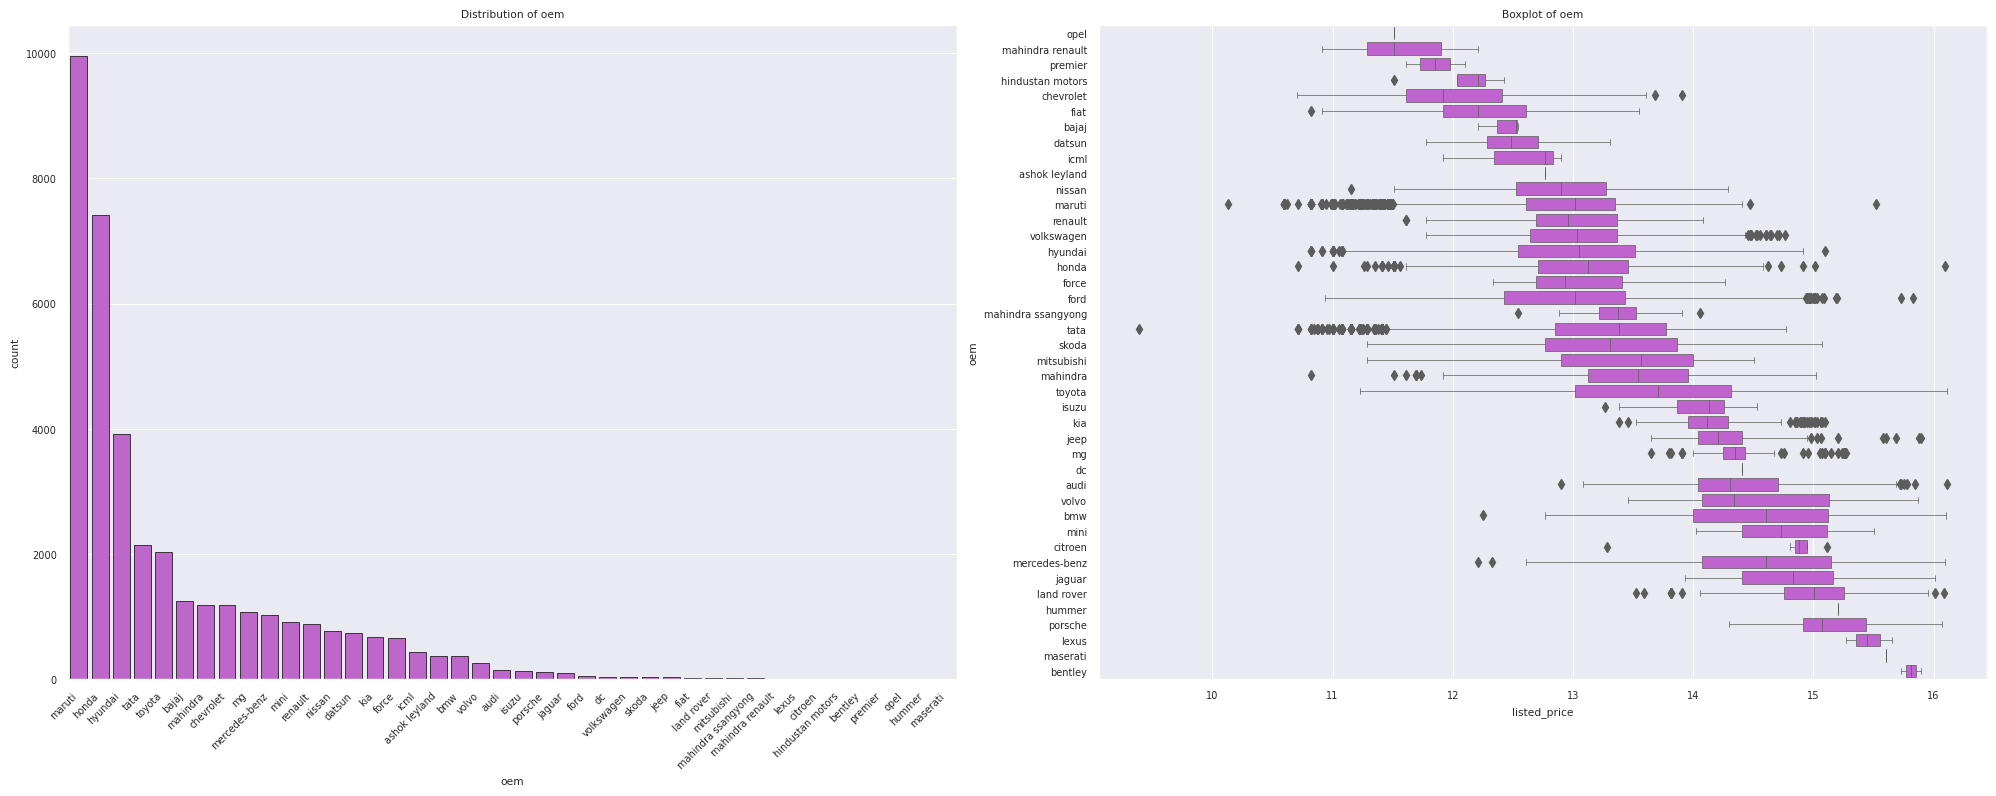

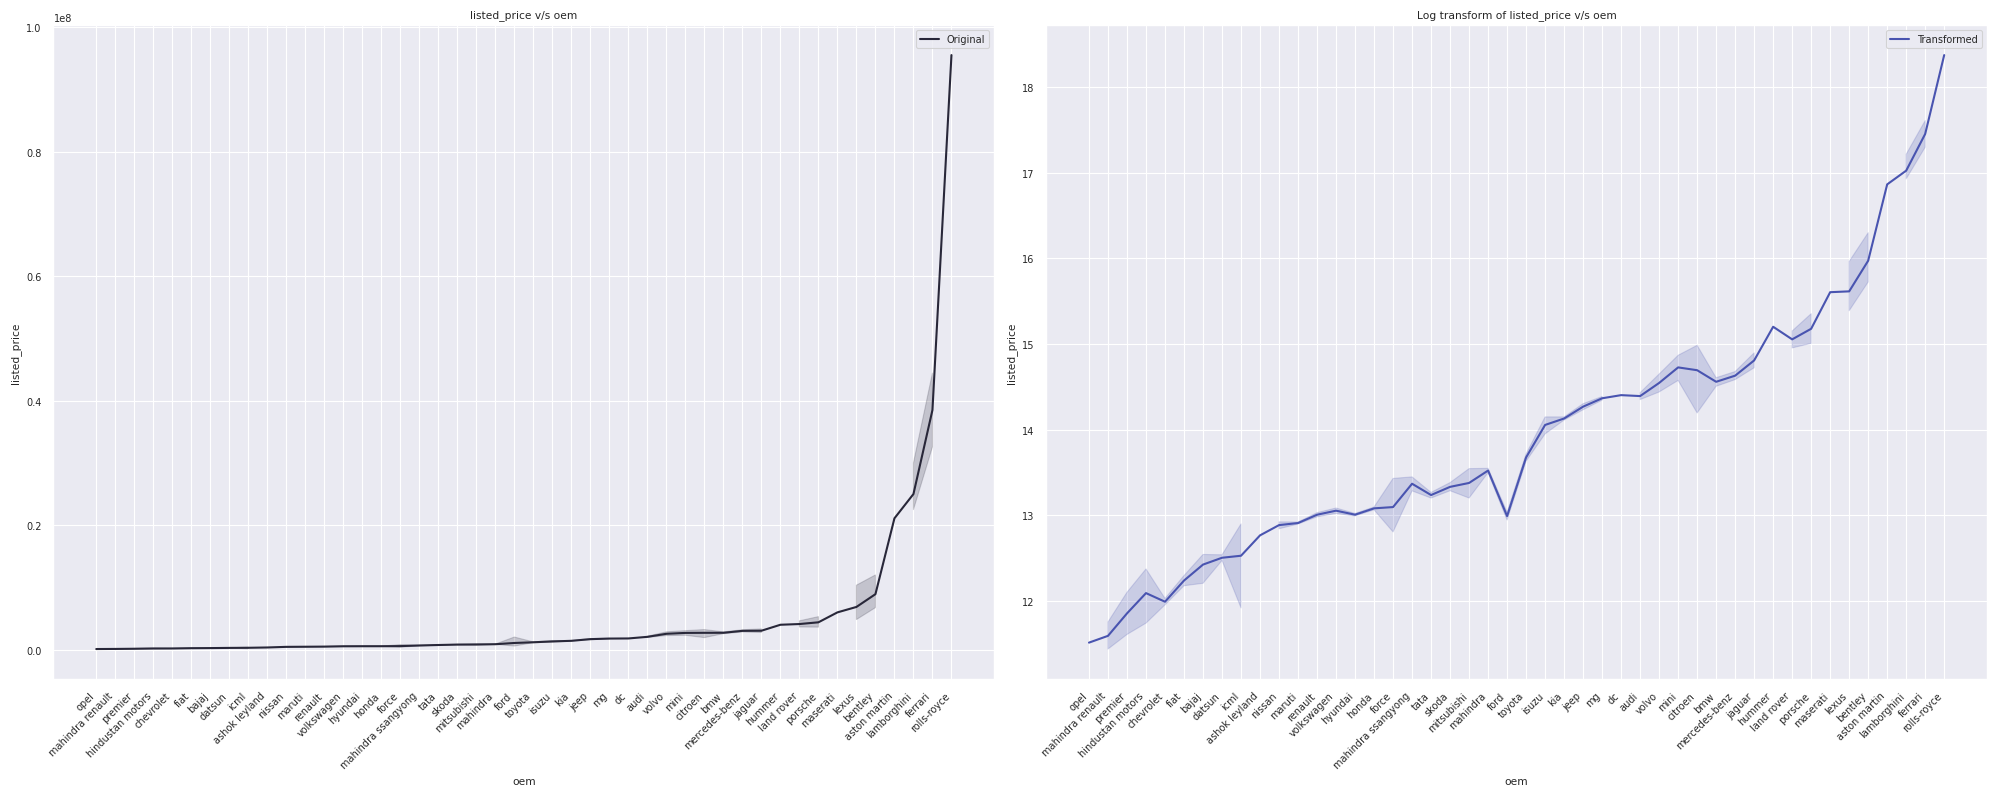

In [34]:
feature_dist_plots(df2, 'oem', linewidth=0.5, sat=0.8, fontscale=0.8, transformation=np.log, sorted=True);
target_relation_plots(df, col='oem', linewidth = 1.5, fontscale=0.8, sorted=True);

### Sugestions for the column `oem`

We could drop some of the luxury car brands for better homogeniztion of the data, but we decided to keep them for generalization. If it adversely affects the model's performance, we could get rid of them later.

---

### `model`
*The model of the car*

In [35]:
analyze_data(df2, 'model');

Overview of column "model"
+----------------+--------------------+
|    Measure     |       Value        |
+----------------+--------------------+
| Distinct Count |        371         |
|   Distinct %   | 0.9824691488798263 |
| Missing Count  |         0          |
|   Missing %    |        0.0         |
+----------------+--------------------+


Column model is not numeric
Common values for column "model"
+--------------------+-------+--------------------+--------------------+
|       Value        | Count |     Frequency      |   Mean of Target   |
+--------------------+-------+--------------------+--------------------+
|     honda city     |  1911 | 5.060642974418728  | 589490.4871794871  |
|    hyundai i20     |  1501 | 3.9748953974895396 | 491160.1085942705  |
|    maruti swift    |  1439 | 3.8107091785392724 | 437266.2703266157  |
|   maruti wagon r   |  1415 | 3.7471532228165882 | 329375.52508833923 |
| maruti swift dzire |  1185 | 3.1380753138075312 | 454591.77383966243 |
+-----

In [36]:
annova_test(df2, 'model');

Null Hypothesis: There is no difference between groups of model
+--------------------+-------------------+--------+------+-----+-------+
|        F(c)        |    F statistic    | pvalue |  q   | dfd |  dfn  |
+--------------------+-------------------+--------+------+-----+-------+
| 0.8818874609301033 | 147.6469299780087 |  0.0   | 0.05 | 371 | 37762 |
+--------------------+-------------------+--------+------+-----+-------+


---

### `variantName`
The variant of the model of the car.

In [37]:
dic = analyze_data(df2, 'variant', n=10);

Overview of column "variant"
+----------------+-------------------+
|    Measure     |       Value       |
+----------------+-------------------+
| Distinct Count |        3408       |
|   Distinct %   | 9.024945712621154 |
| Missing Count  |         0         |
|   Missing %    |        0.0        |
+----------------+-------------------+


Column variant is not numeric
Common values for column "variant"
+-----------+-------+--------------------+--------------------+
|   Value   | Count |     Frequency      |   Mean of Target   |
+-----------+-------+--------------------+--------------------+
|    vxi    |  1233 |  3.2651872252529   | 423101.8694241687  |
|    lxi    |  744  | 1.9702346274032096 | 289801.3252688172  |
|    vdi    |  646  | 1.7107144748689158 | 466165.41950464394 |
|   sportz  |  457  | 1.2102113235527778 | 401023.48796498904 |
|   magna   |  392  | 1.038080610137175  | 299286.4566326531  |
|  lxi cng  |  325  | 0.8606535670780149 | 334190.48307692306 |
| vxi bs iv |  2

`variantName` has a very high cardinality. Let's do a **ANOVA** test to find out if it is important.

**$ H_0 $ (null hypothesis)** - There is no difference between groups (i.e. the feature is not very important)

**$ p $ (confidence level)** - 0.05

In [38]:
annova_test(df2, 'model');

Null Hypothesis: There is no difference between groups of model
+--------------------+-------------------+--------+------+-----+-------+
|        F(c)        |    F statistic    | pvalue |  q   | dfd |  dfn  |
+--------------------+-------------------+--------+------+-----+-------+
| 0.8818874609301033 | 147.6469299780087 |  0.0   | 0.05 | 371 | 37762 |
+--------------------+-------------------+--------+------+-----+-------+


Since the $F$ value is 143 and $p = 0$, we can reject the null hypothesis and conclude that the feature is important. 

Even though it has such a high cardinality, it is also highly informative as suggested by the f-statistic. So it's better to keep this column and perhaps encode it using a target encoder or some encoding technique which preservs / reduces the number of dimensions.

---

### `City`

*The city in which the car was located*

In [39]:
analyze_data(df2, 'City');

Overview of column "City"
+----------------+-------------------+
|    Measure     |       Value       |
+----------------+-------------------+
| Distinct Count |        617        |
|   Distinct %   | 1.633917695037339 |
| Missing Count  |         0         |
|   Missing %    |        0.0        |
+----------------+-------------------+


Column City is not numeric
Common values for column "City"
+-----------+-------+--------------------+--------------------+
|   Value   | Count |     Frequency      |   Mean of Target   |
+-----------+-------+--------------------+--------------------+
| new delhi |  4940 | 13.081934219585827 | 1002013.3712550608 |
| bangalore |  4877 | 12.91509983581378  | 831078.9356161575  |
|    pune   |  4817 | 12.75620994650707  |  646097.108366203  |
|  gurgaon  |  3235 | 8.566813198453472  | 639090.2998454405  |
|   mumbai  |  2851 | 7.549917906890525  | 1110328.3977551737 |
+-----------+-------+--------------------+--------------------+




In [40]:
annova_test(df2, 'City')

Null Hypothesis: There is no difference between groups of City
+--------------------+-------------------+--------+------+-----+-------+
|        F(c)        |    F statistic    | pvalue |  q   | dfd |  dfn  |
+--------------------+-------------------+--------+------+-----+-------+
| 0.9075766284867426 | 19.88376561232364 |  0.0   | 0.05 | 617 | 37762 |
+--------------------+-------------------+--------+------+-----+-------+


F_onewayResult(statistic=19.88376561232364, pvalue=0.0)

---

### `listed_price`
*The asking price for the car*

In [41]:
analyze_data(df2, 'listed_price', descriptive=True);

Overview of column "listed_price"
+----------------+--------------------+
|    Measure     |       Value        |
+----------------+--------------------+
| Distinct Count |        6829        |
|   Distinct %   | 18.084317567925428 |
| Missing Count  |         0          |
|   Missing %    |        0.0         |
|      Mean      | 763937.9758487368  |
|    Minimum     |      11963.0       |
|    Maximum     |     9900000.0      |
+----------------+--------------------+


Quantile stats for column "listed_price"
+---------------------+-----------+
|      Statistic      |   Value   |
+---------------------+-----------+
|       Minimum       |  11963.0  |
|    5th Percentile   |  145000.0 |
|  First Quartile, Q1 |  320000.0 |
|        Median       |  525000.0 |
|  Third Quartile, Q3 | 850680.25 |
|   95th Percentile   | 2100000.0 |
|       Maximum       | 9900000.0 |
|        Range        | 9888037.0 |
| Interquartile Range | 530680.25 |
+---------------------+-----------+


Descriptive s

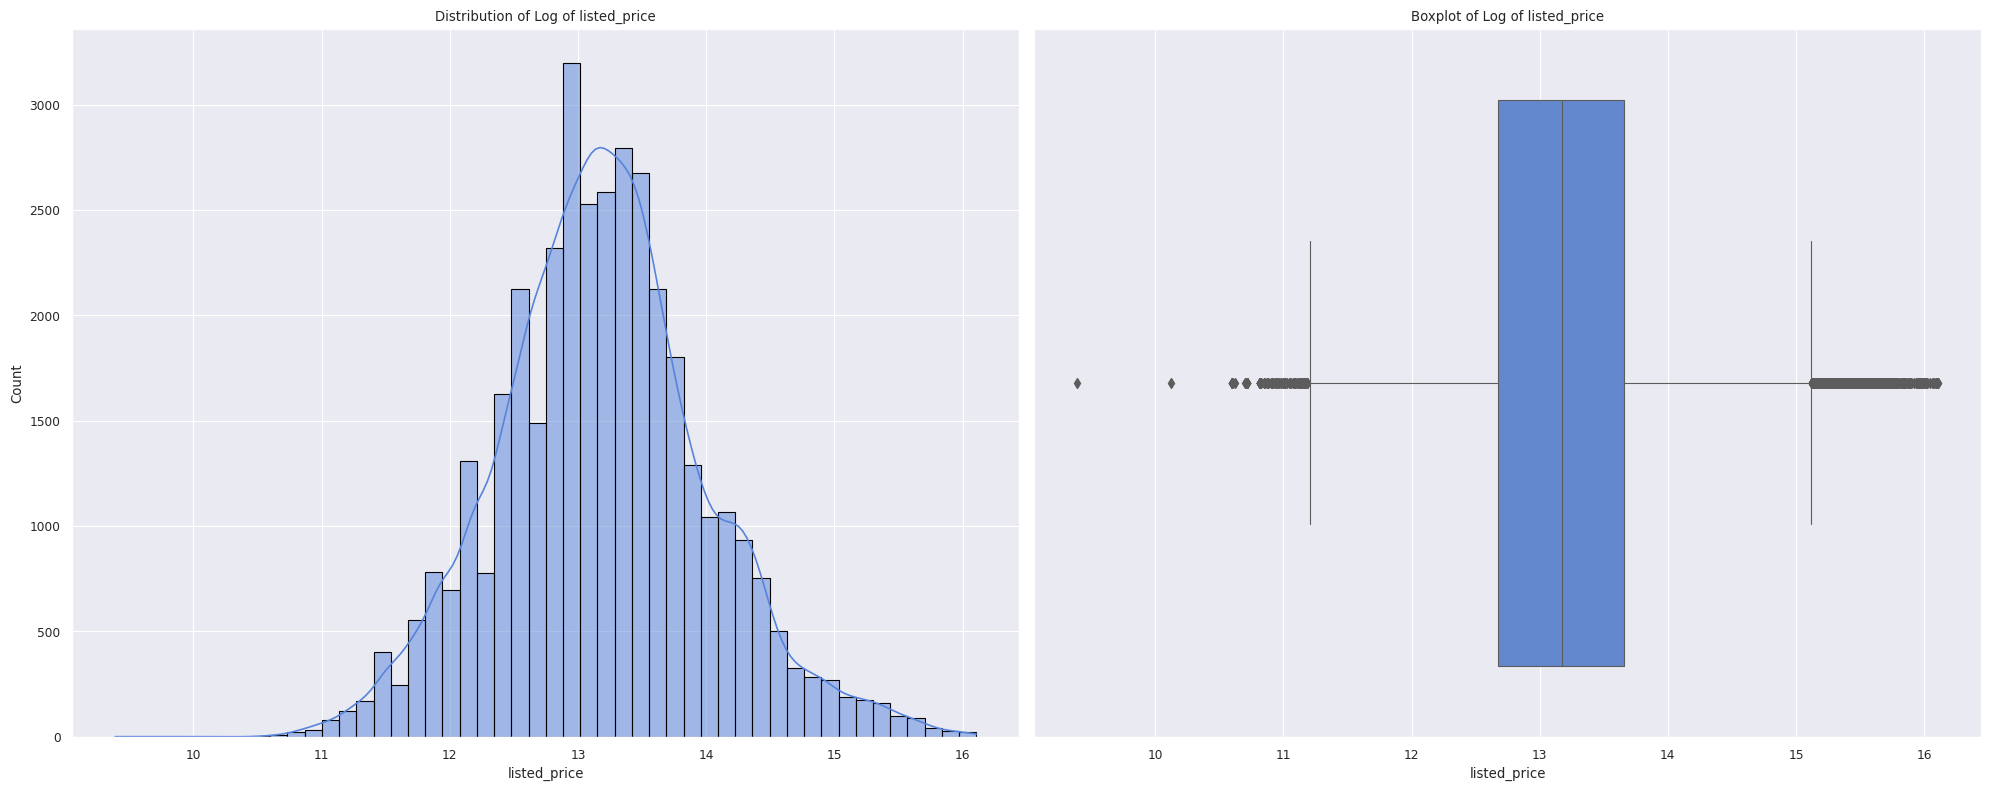

In [42]:
feature_dist_plots(df2, 'listed_price', linewidth=0.8, sat=0.8, fontscale=1, bins=50, rotation=0, hist_transformation=np.log, tname='Log');

### Observations and Sugestions

1. The target variable is highly skewed as indicated by the *kurtosis coefficient* and *skewness*.
2. If the model used for prediction is a liner model, a log transformed target to make it more normal like could help (use `sklearn.compose.TransformedTargetRegressor`)

---

### `discountValue`

In [43]:
analyze_data(df2, 'discountValue');

Overview of column "discountValue"
+----------------+---------------------+
|    Measure     |        Value        |
+----------------+---------------------+
| Distinct Count |          30         |
|   Distinct %   | 0.07944494465335522 |
| Missing Count  |          0          |
|   Missing %    |         0.0         |
|      Mean      |  73.38067369313066  |
|    Minimum     |          0          |
|    Maximum     |        200000       |
+----------------+---------------------+


Quantile stats for column "discountValue"
+---------------------+--------+
|      Statistic      | Value  |
+---------------------+--------+
|       Minimum       |   0    |
|    5th Percentile   |  0.0   |
|  First Quartile, Q1 |  0.0   |
|        Median       |  0.0   |
|  Third Quartile, Q3 |  0.0   |
|   95th Percentile   |  0.0   |
|       Maximum       | 200000 |
|        Range        | 200000 |
| Interquartile Range |  0.0   |
+---------------------+--------+


Extremums for column "discountValue"
Ma

/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


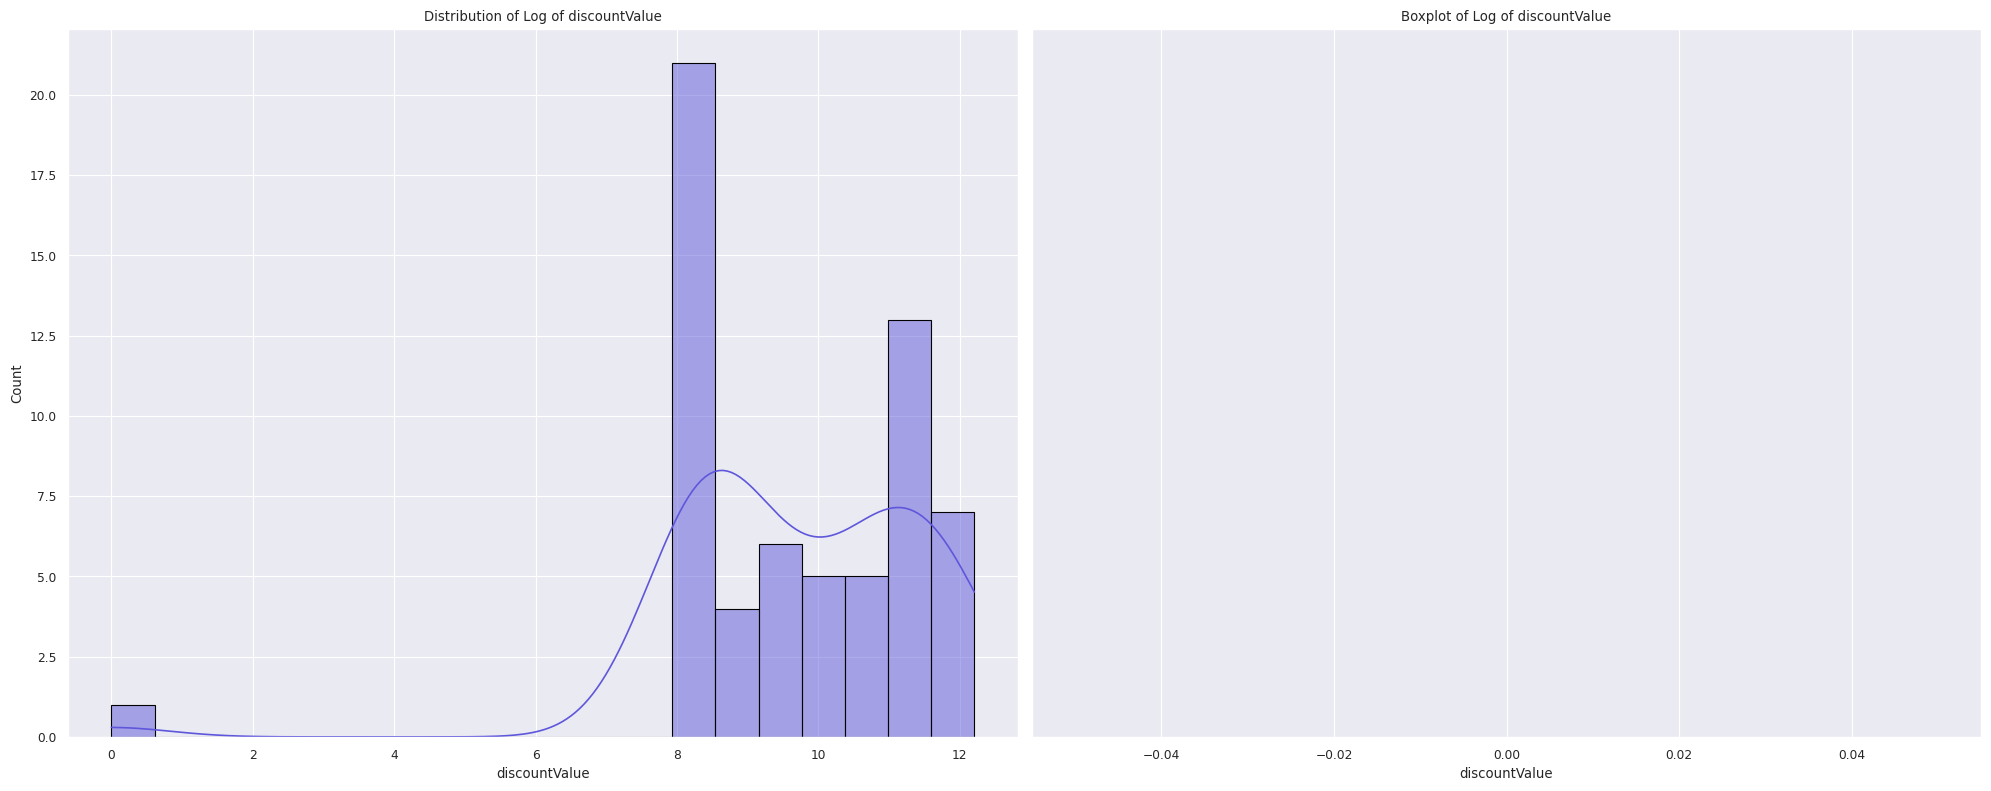

In [44]:
feature_dist_plots(df2, 'discountValue', linewidth=0.8, sat=0.8, fontscale=1, rotation=45, hist_transformation=np.log, tname='Log');

### Suggestions

Since this column lists down the discounts that may be applicable of certain cars and there is no discount value for ~99.84% of the cars, we would be dropping this column

In [45]:
def discountValue_transformation(df: pd.DataFrame):
    """
    Drop the column 'discountValue' from the dataframe
    """
    df.drop('discountValue', axis=0, inplace=True)
    return

suggested_transformations.append(discountValue_transformation)

---

### `utype`
*The type of seller; who is selling the car*

In [46]:
analyze_data(df2, 'utype');

Overview of column "utype"
+----------------+----------------------+
|    Measure     |        Value         |
+----------------+----------------------+
| Distinct Count |          2           |
|   Distinct %   | 0.005296329643557015 |
| Missing Count  |          0           |
|   Missing %    |         0.0          |
+----------------+----------------------+


Column utype is not numeric
Common values for column "utype"
+------------+-------+--------------------+-------------------+
|   Value    | Count |     Frequency      |   Mean of Target  |
+------------+-------+--------------------+-------------------+
|   dealer   | 31918 |  84.5241247815264  | 800146.6513879315 |
| individual |  5844 | 15.475875218473599 | 566178.1356947296 |
+------------+-------+--------------------+-------------------+




In [47]:
annova_test(df2, 'utype');

Null Hypothesis: There is no difference between groups of utype
+----------------------+-------------------+--------+------+-----+-------+
|         F(c)         |    F statistic    | pvalue |  q   | dfd |  dfn  |
+----------------------+-------------------+--------+------+-----+-------+
| 0.051293364060334516 | 2666.392906568764 |  0.0   | 0.05 |  2  | 37762 |
+----------------------+-------------------+--------+------+-----+-------+


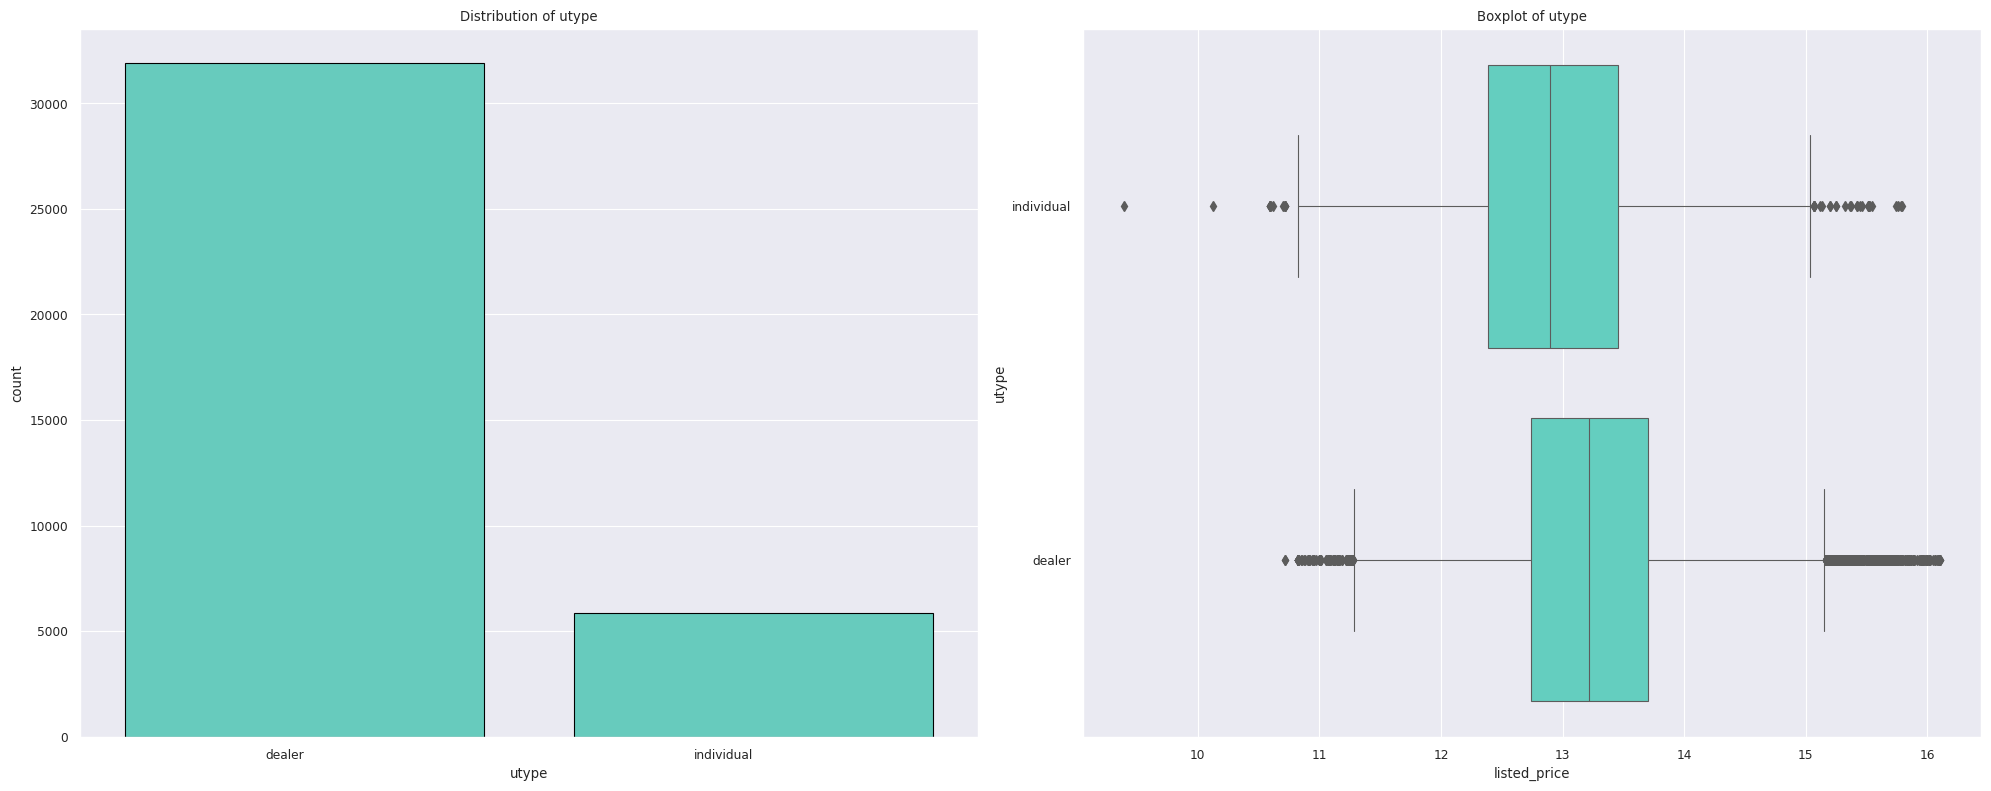

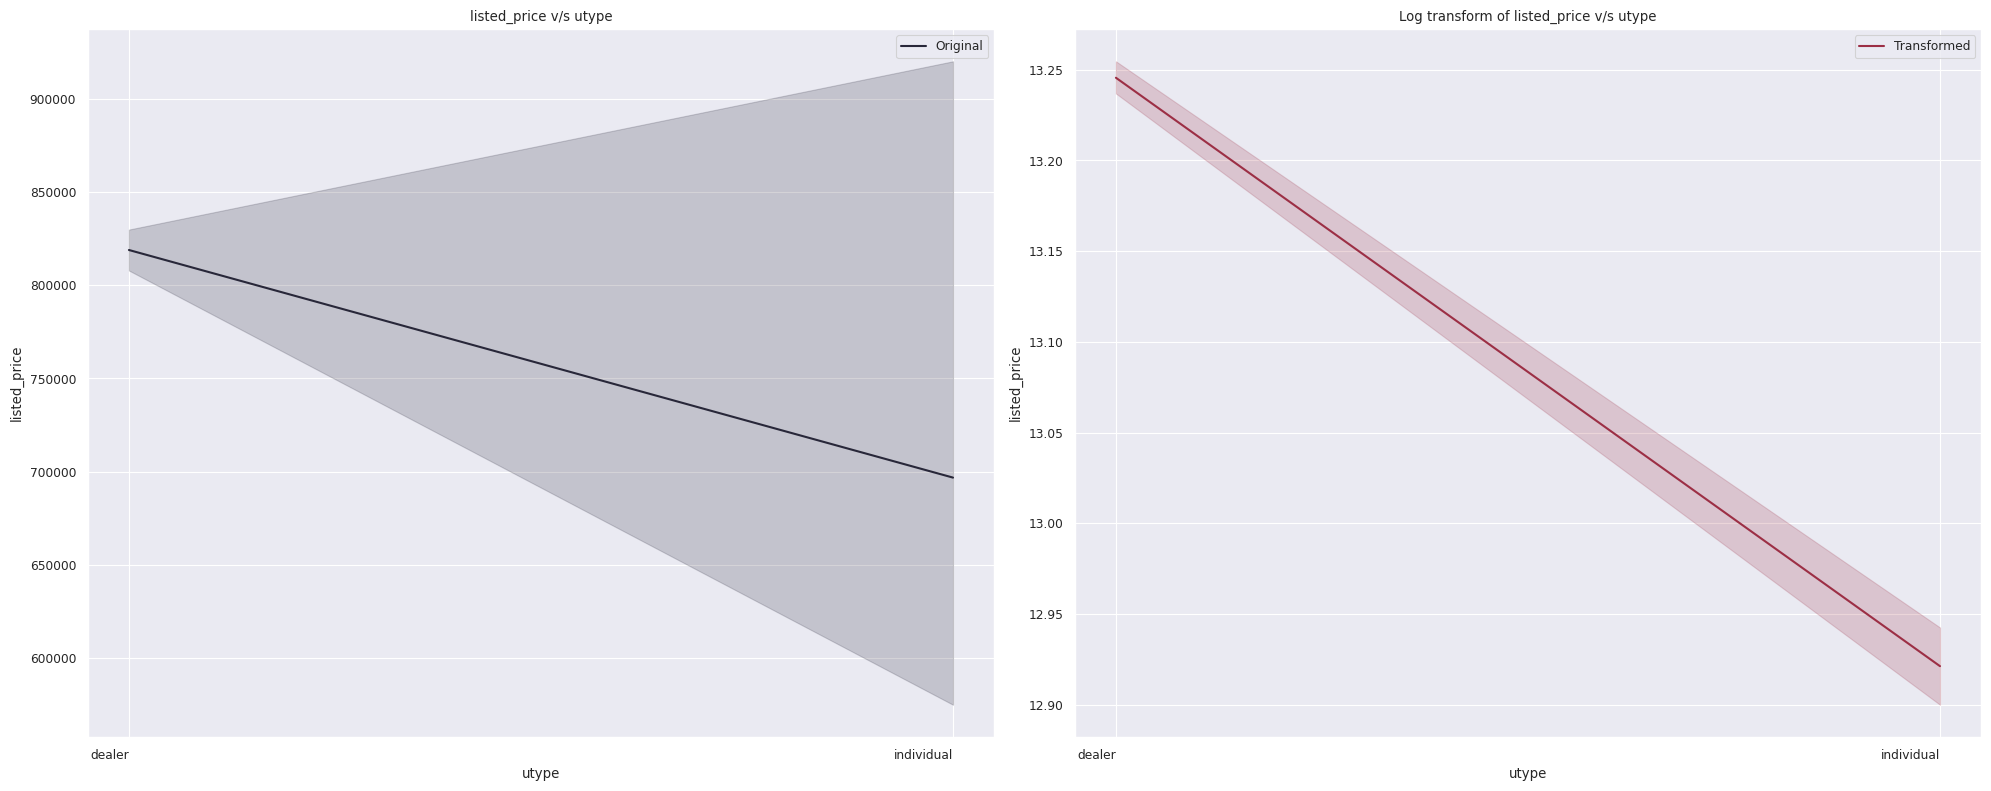

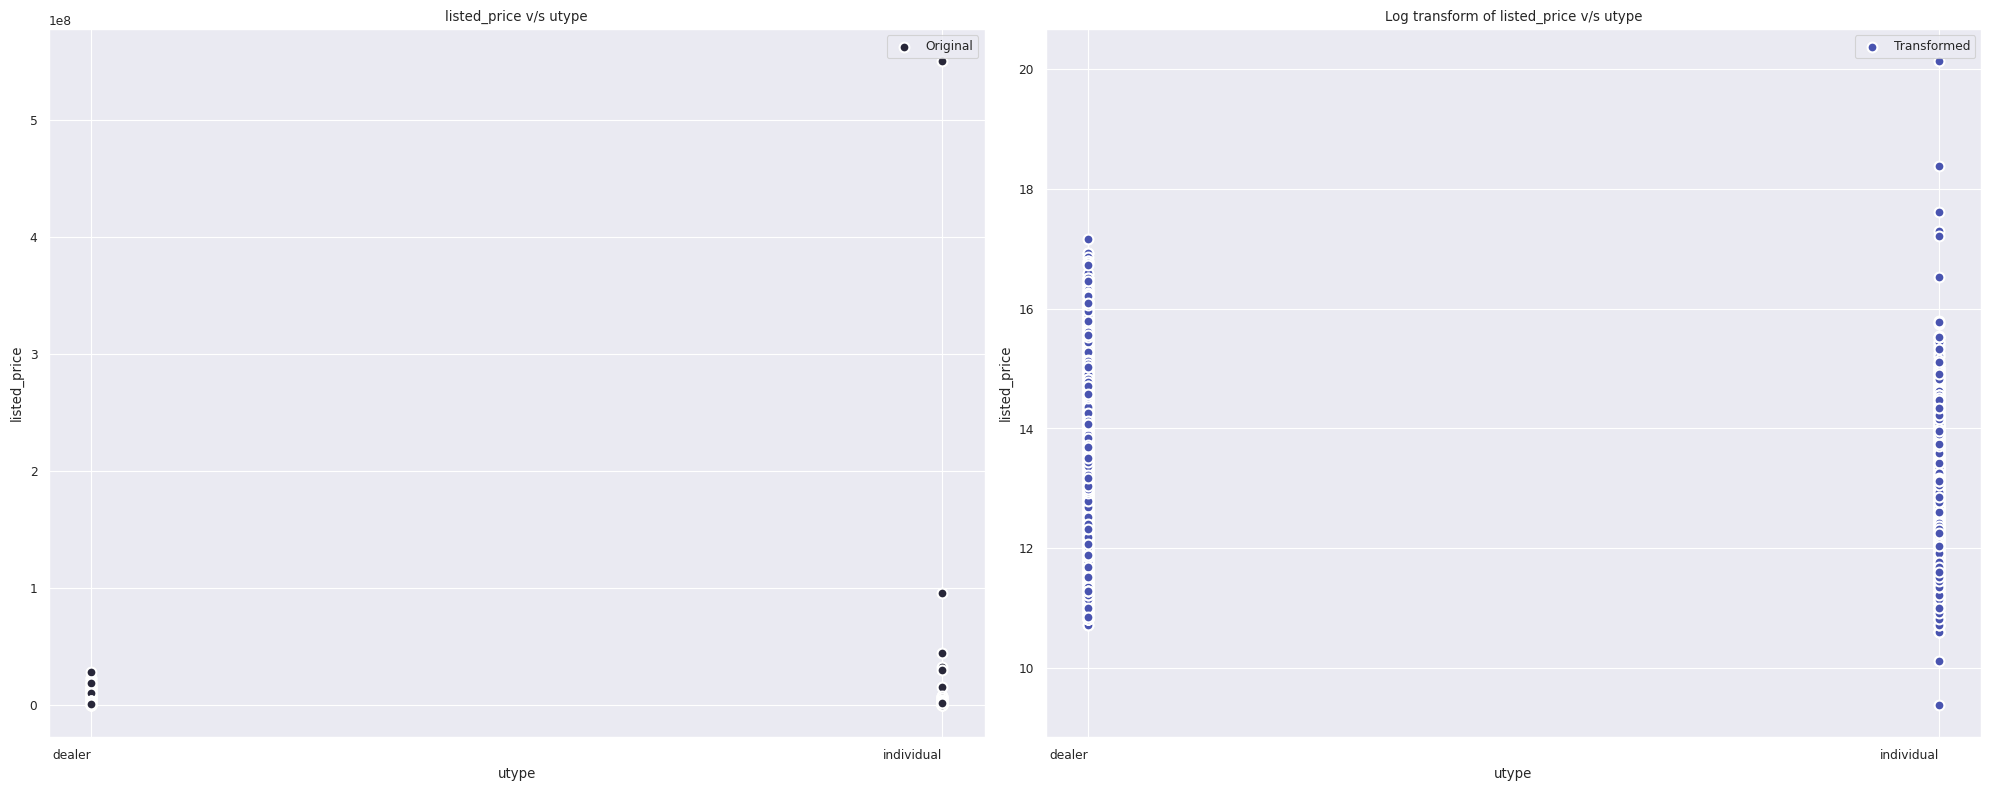

In [48]:
feature_dist_plots(df2, 'utype', linewidth=0.8, sat=0.8, fontscale=1, transformation=np.log, rotation=0);
target_relation_plots(df, col='utype', linewidth = 1.5, fontscale=1, rotation=0);
target_relation_plots(df, col='utype', linewidth = 1.5, fontscale=1, rotation=0, plot='scatter', s=50);

---

### `carType`
*The type of car*

In [49]:
analyze_data(df2, 'carType');

Overview of column "carType"
+----------------+----------------------+
|    Measure     |        Value         |
+----------------+----------------------+
| Distinct Count |          3           |
|   Distinct %   | 0.007944494465335522 |
| Missing Count  |          0           |
|   Missing %    |         0.0          |
+----------------+----------------------+


Column carType is not numeric
Common values for column "carType"
+-----------+-------+---------------------+-------------------+
|   Value   | Count |      Frequency      |   Mean of Target  |
+-----------+-------+---------------------+-------------------+
|  partner  | 32461 |  85.96207827975213  | 773055.6542620375 |
| corporate |  5278 |  13.977013929346963 | 708448.5128836681 |
|  assured  |   23  | 0.06090779090090567 | 629347.8260869565 |
+-----------+-------+---------------------+-------------------+




In [50]:
annova_test(df, 'carType');

Null Hypothesis: There is no difference between groups of carType
+--------------------+--------------------+------------------------+------+-----+-------+
|        F(c)        |    F statistic     |         pvalue         |  q   | dfd |  dfn  |
+--------------------+--------------------+------------------------+------+-----+-------+
| 0.1172811007738156 | 43.172113390225704 | 1.8705324538654156e-19 | 0.05 |  3  | 37813 |
+--------------------+--------------------+------------------------+------+-----+-------+


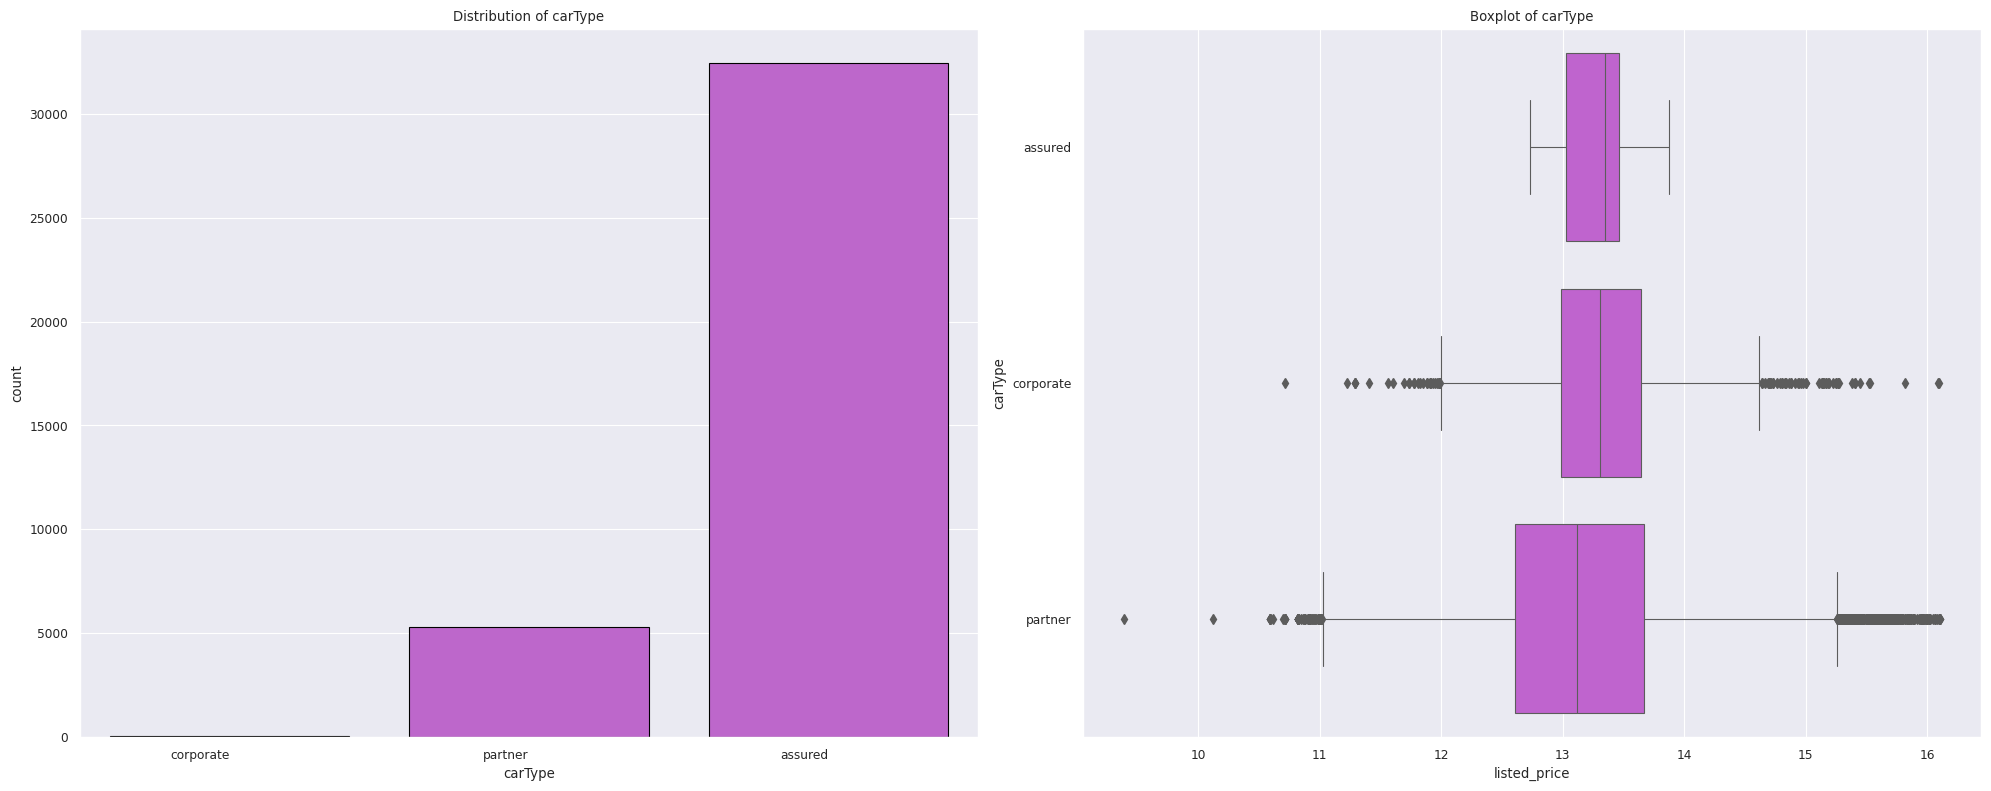

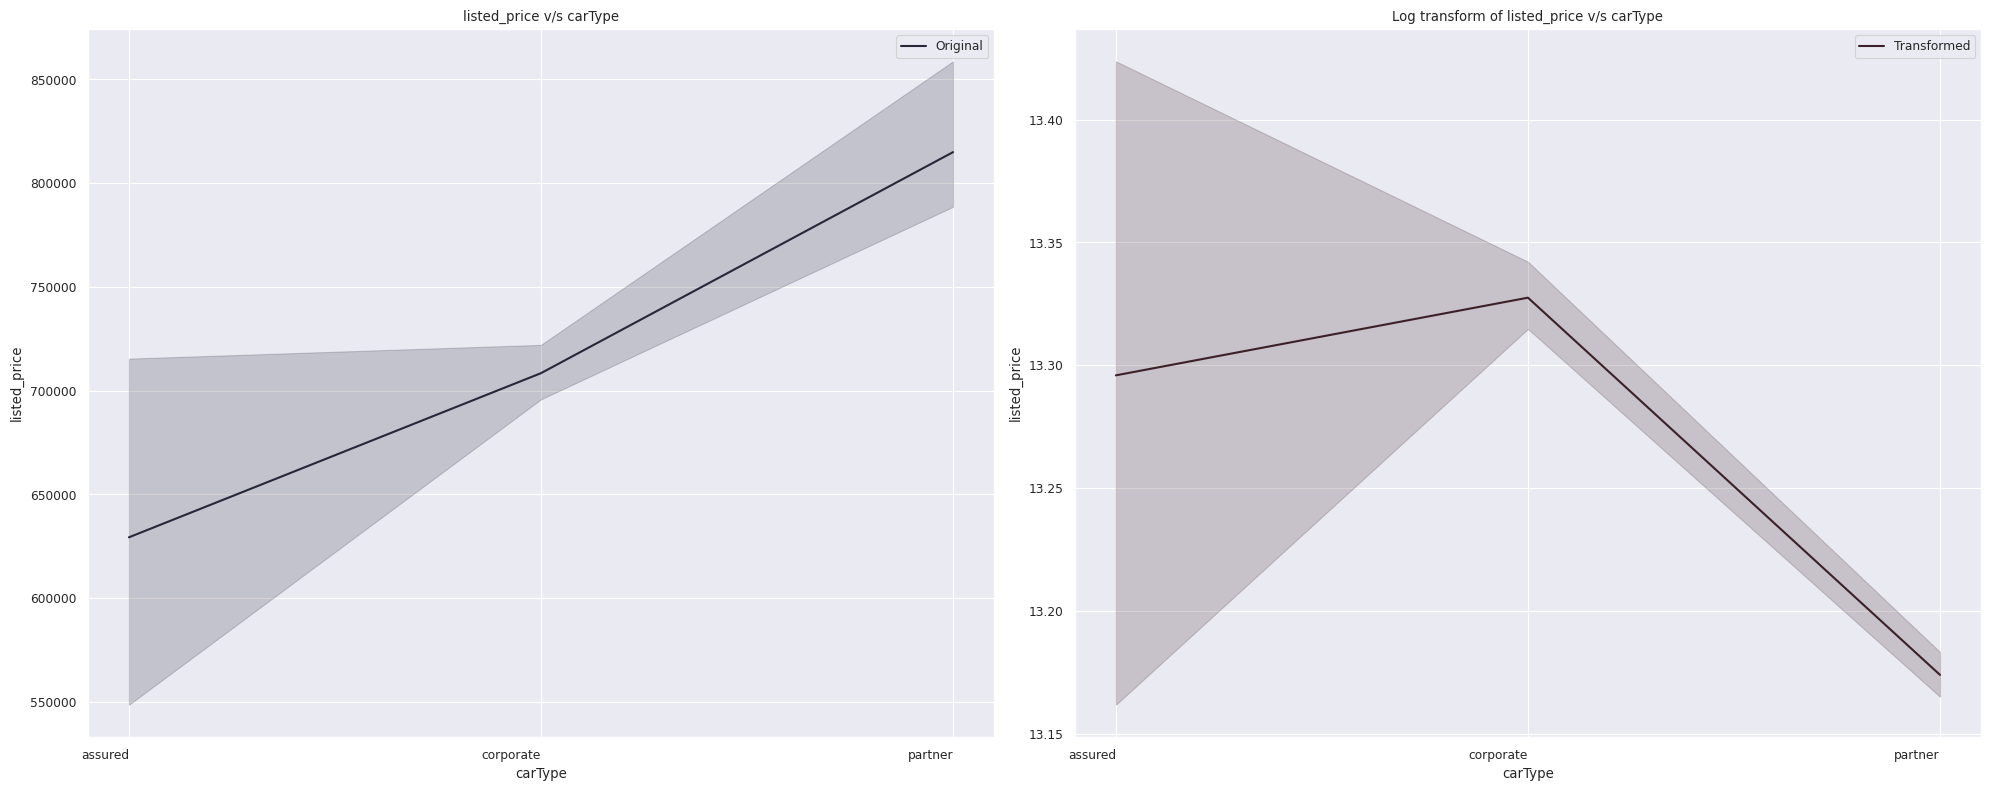

In [51]:
feature_dist_plots(df2, 'carType', linewidth=0.8, sat=0.8, fontscale=1, transformation=np.log, rotation=0);
target_relation_plots(df, col='carType', linewidth = 1.5, fontscale=1, rotation=0, sorted=True);

### Suggestions

This column is important, but it is very specific to the Cardekho product, since this column is marked by people at Cardekho for their internal tracking and testing. We cannot keep this column if we want our service to be available to everyone on the internet. Therefore, we decided to **drop this column**

In [52]:
def carType_transformation(df: pd.DataFrame):
    """
    Drop the column 'carType' from the dataframe
    """
    df.drop('carType', axis=0, inplace=True)
    return

suggested_transformations.append(carType_transformation)

---

### `top_features`
*A list of the top features of the car*

In [53]:
dic = analyze_data(df2, 'top_features');

Overview of column "top_features"
+----------------+--------------------+
|    Measure     |       Value        |
+----------------+--------------------+
| Distinct Count |        397         |
|   Distinct %   | 1.0513214342460675 |
| Missing Count  |         0          |
|   Missing %    |        0.0         |
+----------------+--------------------+


Column top_features is not numeric
Common values for column "top_features"
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+--------------------+--------------------+
|                                                                                                  Value                                                                                                  | Count |     Frequency      |   Mean of Target   |
+------------------------------------------------------------

### Suggestions

We can leave this column to be handled during feature engineering. *(Eg, we could make seperate features for the every feature string in the object top features)*

Here is some example code about how we might go about it:-

In [54]:
from ast import literal_eval

def example_features_handler():
    df3 = df.copy()

    # create an empty set to store unique features
    unique_features = set()

    for col in ['top_features', 'comfort_features', 'interior_features', 'exterior_features', 'safety_features']:
        # convert the string of features to a list of objects
        df3[col] = df3[col].apply(lambda x: literal_eval(x))

        # iterate over each row in the dataframe
        for index, row in df3.iterrows():
            # iterate over each feature in the list of features for that row
            for feature in row[col]:
                # add the feature to the set of unique features
                unique_features.add(feature)

    print(len(unique_features))

In [55]:
example_features_handler()

165


### `comfort_features`, `interior_features`, `exterior_features`, `safety_features`
These will also be handled in a manner similar to `top_features`

---

### `Color`
*The color of the car*

In [56]:
analyze_data(df2, 'Color', n=5);

Overview of column "Color"
+----------------+---------------------+
|    Measure     |        Value        |
+----------------+---------------------+
| Distinct Count |         747         |
|   Distinct %   |  1.9781791218685452 |
| Missing Count  |         159         |
|   Missing %    | 0.42105820666278265 |
+----------------+---------------------+


Column Color is not numeric
Common values for column "Color"
+--------+-------+--------------------+--------------------+
| Value  | Count |     Frequency      |   Mean of Target   |
+--------+-------+--------------------+--------------------+
| white  | 10038 | 26.69467861606787  | 852164.0923490735  |
| silver |  4432 | 11.786293646783502 | 615835.8716155235  |
|  grey  |  3284 | 8.733345743690663  | 724972.7335566382  |
|  red   |  2807 | 7.464829933781879  | 696394.7858924118  |
|  blue  |  2005 | 5.332021381272771  | 1091167.5441396509 |
+--------+-------+--------------------+--------------------+




In [57]:
annova_test(df2.sample(500), 'Color');

Null Hypothesis: There is no difference between groups of Color
+--------------------+-------------------+---------------------+------+-----+-----+
|        F(c)        |    F statistic    |        pvalue       |  q   | dfd | dfn |
+--------------------+-------------------+---------------------+------+-----+-----+
| 0.7673553991859886 | 1.414002918004533 | 0.01050144092694599 | 0.05 | 103 | 500 |
+--------------------+-------------------+---------------------+------+-----+-----+


---

### `Engine Type`

In [58]:
analyze_data(df2, 'Engine Type');

Overview of column "Engine Type"
+----------------+--------------------+
|    Measure     |       Value        |
+----------------+--------------------+
| Distinct Count |        554         |
|   Distinct %   | 1.4670833112652932 |
| Missing Count  |        864         |
|   Missing %    | 2.2880144060166305 |
+----------------+--------------------+


Column Engine Type is not numeric
Common values for column "Engine Type"
+--------------------------+-------+--------------------+--------------------+
|          Value           | Count |     Frequency      |   Mean of Target   |
+--------------------------+-------+--------------------+--------------------+
|      in-line engine      |  3370 | 9.133286356984119  | 366252.94362017803 |
| kappa vtvt petrol engine |  1658 | 4.4934684806764595 | 504286.95355850423 |
|      petrol engine       |  1620 | 4.390481868935986  | 435313.4919753086  |
|    ddis diesel engine    |  1213 | 3.2874410537156487 | 444628.4410552349  |
|  k series petrol 

In [59]:
annova_test(df2.sample(1000), 'Engine Type');

Null Hypothesis: There is no difference between groups of Engine Type
+--------------------+-------------------+-----------------------+------+-----+------+
|        F(c)        |    F statistic    |         pvalue        |  q   | dfd | dfn  |
+--------------------+-------------------+-----------------------+------+-----+------+
| 0.8335611622347249 | 4.997850145573032 | 8.235033247192831e-61 | 0.05 | 212 | 1000 |
+--------------------+-------------------+-----------------------+------+-----+------+


---

### `No of Cylinder`

In [60]:
analyze_data(df2, 'No of Cylinder');

Overview of column "No of Cylinder"
+----------------+---------------------+
|    Measure     |        Value        |
+----------------+---------------------+
| Distinct Count |          10         |
|   Distinct %   | 0.02648164821778507 |
| Missing Count  |         143         |
|   Missing %    |  0.3786875695143266 |
|      Mean      |  3.8158377415667615 |
|    Minimum     |         1.0         |
|    Maximum     |         16.0        |
+----------------+---------------------+


Quantile stats for column "No of Cylinder"
+---------------------+-------+
|      Statistic      | Value |
+---------------------+-------+
|       Minimum       |  1.0  |
|    5th Percentile   |  3.0  |
|  First Quartile, Q1 |  4.0  |
|        Median       |  4.0  |
|  Third Quartile, Q3 |  4.0  |
|   95th Percentile   |  4.0  |
|       Maximum       |  16.0 |
|        Range        |  15.0 |
| Interquartile Range |  0.0  |
+---------------------+-------+


Extremums for column "No of Cylinder"
Maximum 5 va

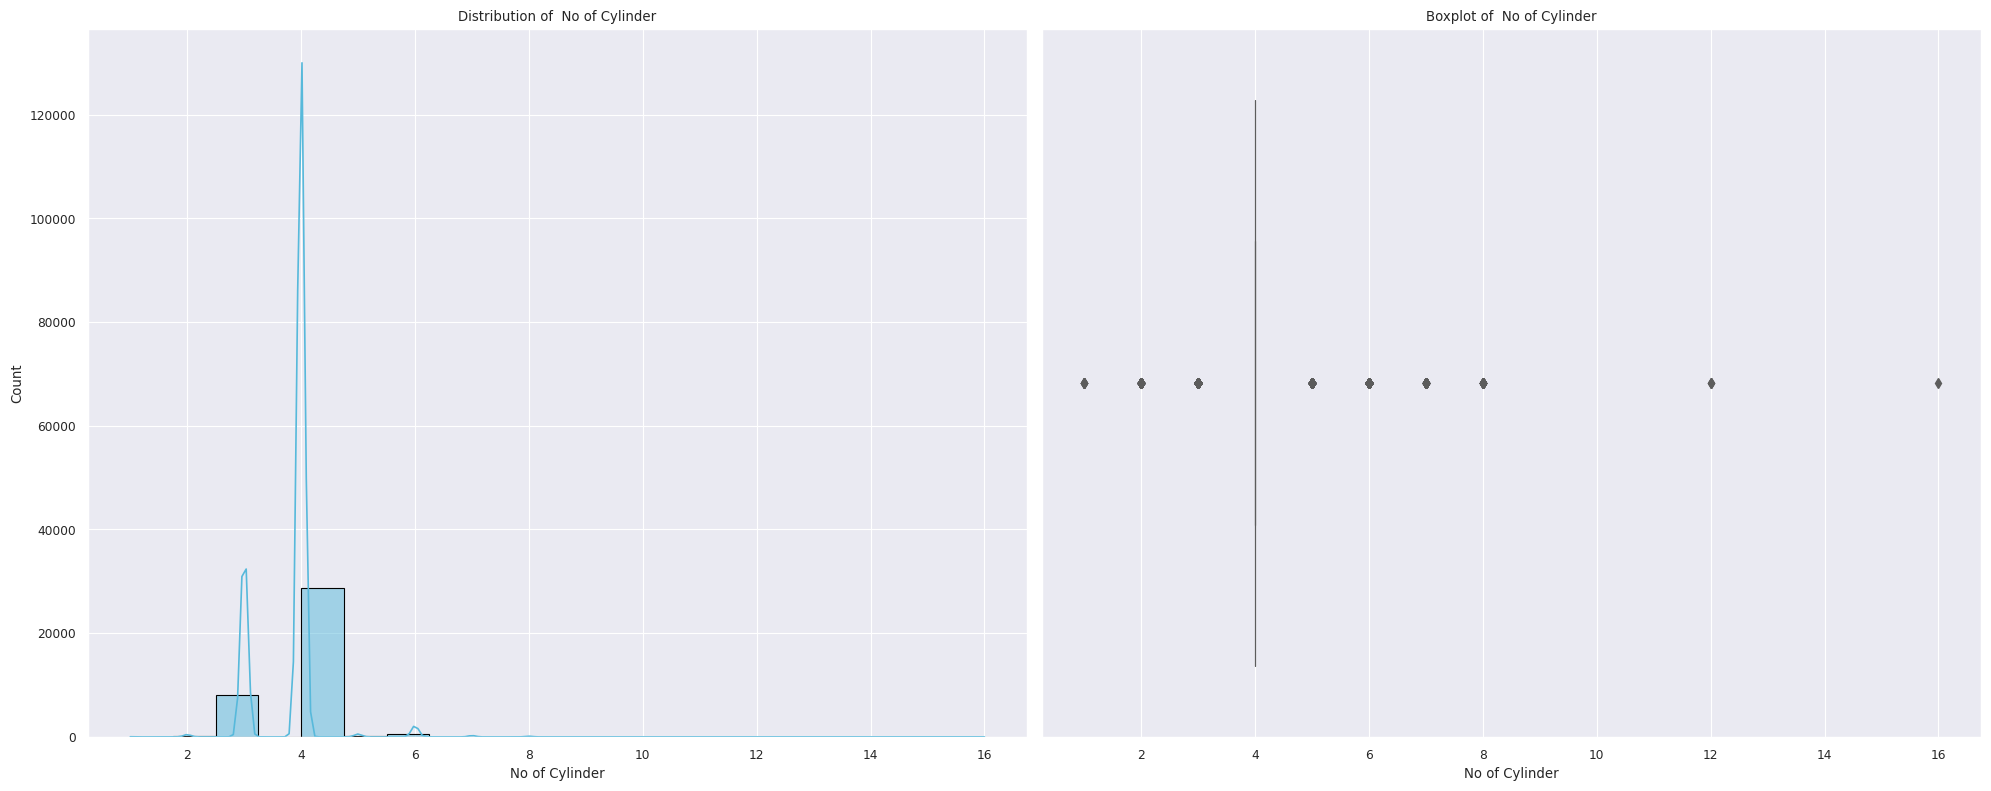

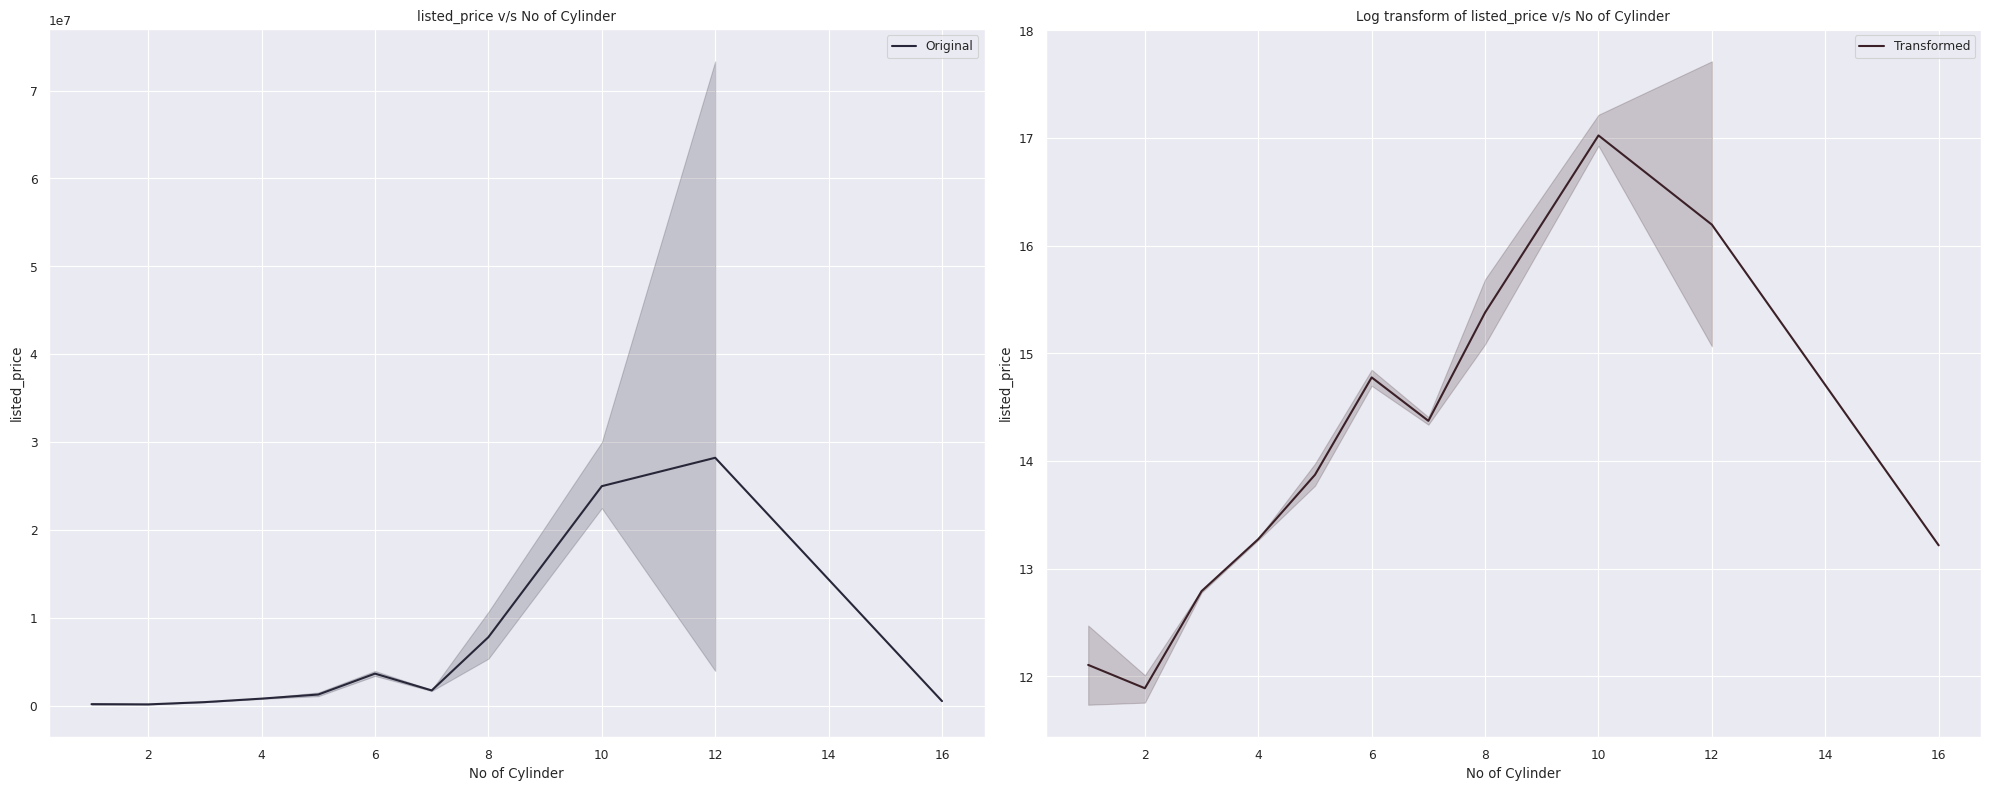

In [61]:
feature_dist_plots(df2, 'No of Cylinder', linewidth=0.8, sat=0.8, fontscale=1, rotation=0, sorted=True);
target_relation_plots(df, col='No of Cylinder', linewidth = 1.5, fontscale=1, rotation=0, sorted=True);

In [62]:
df2[df2['No of Cylinder'] == 16]

usedCarSkuId             loc  myear       body  \
1300  4e24878f-a8d4-4647-9afb-83d8c11dfa92  bangalore city   2018  hatchback   

     transmission      fuel        km  ip  \
1300    automatic  electric 33572.000   0   

                                                 images  imgCount  ...  \
1300  [{'img': 'https://images10.gaadi.com/usedcar_i...        10  ...   

                    Fuel Suppy System Compression Ratio Alloy Wheel Size  \
1300  Three-Phase AC Induction Motors               NaN              NaN   

     Ground Clearance Unladen Max Power Delivered Max Power At  \
1300                      NaN              25.400     3500.000   

      Max Torque Delivered  Max Torque At Bore Stroke  
1300                70.000       1050.000  NaN    NaN  

[1 rows x 66 columns]

OMG! We have an electric car claiming it has 16 cylinders! Let's see if it happens often in the dataset

In [63]:
df2[(df2['No of Cylinder'].notnull()) & (df2['fuel'] == 'electric')].shape

(28, 66)

### Suggestions for `No of Cylinders`

There are 28 cars which are electric but have No of Cylinder value. We should replace these values with nan

In [64]:
def NumOfCylinder_transformation(df: pd.DataFrame):
    """
    Replace the value of No of Cylinder with null if the car is electric
    """
    df.loc[(df['Fuel'] == 'Electric') & (df['No of Cylinder'].notnull()), 'No of Cylinder'] = np.NaN
    return

suggested_transformations.append(NumOfCylinder_transformation)

---

### `Valve Configuration`

In [65]:
analyze_data(df2, 'Valve Configuration');

Overview of column "Valve Configuration"
+----------------+----------------------+
|    Measure     |        Value         |
+----------------+----------------------+
| Distinct Count |          5           |
|   Distinct %   | 0.013240824108892536 |
| Missing Count  |         7941         |
|   Missing %    |  21.029076849743127  |
+----------------+----------------------+


Column Valve Configuration is not numeric
Common values for column "Valve Configuration"
+---------------------+-------+----------------------+--------------------+
|        Value        | Count |      Frequency       |   Mean of Target   |
+---------------------+-------+----------------------+--------------------+
|         dohc        | 23544 |  78.95107474598437   |  784267.208120965  |
|         sohc        |  6197 |  20.780657925622883  | 415783.27142165566 |
|         idsi        |   66  |  0.2213205459240133  | 211488.9393939394  |
| 16 modules 48 cells |   11  | 0.03688675765400221  | 439076.45454545453 |


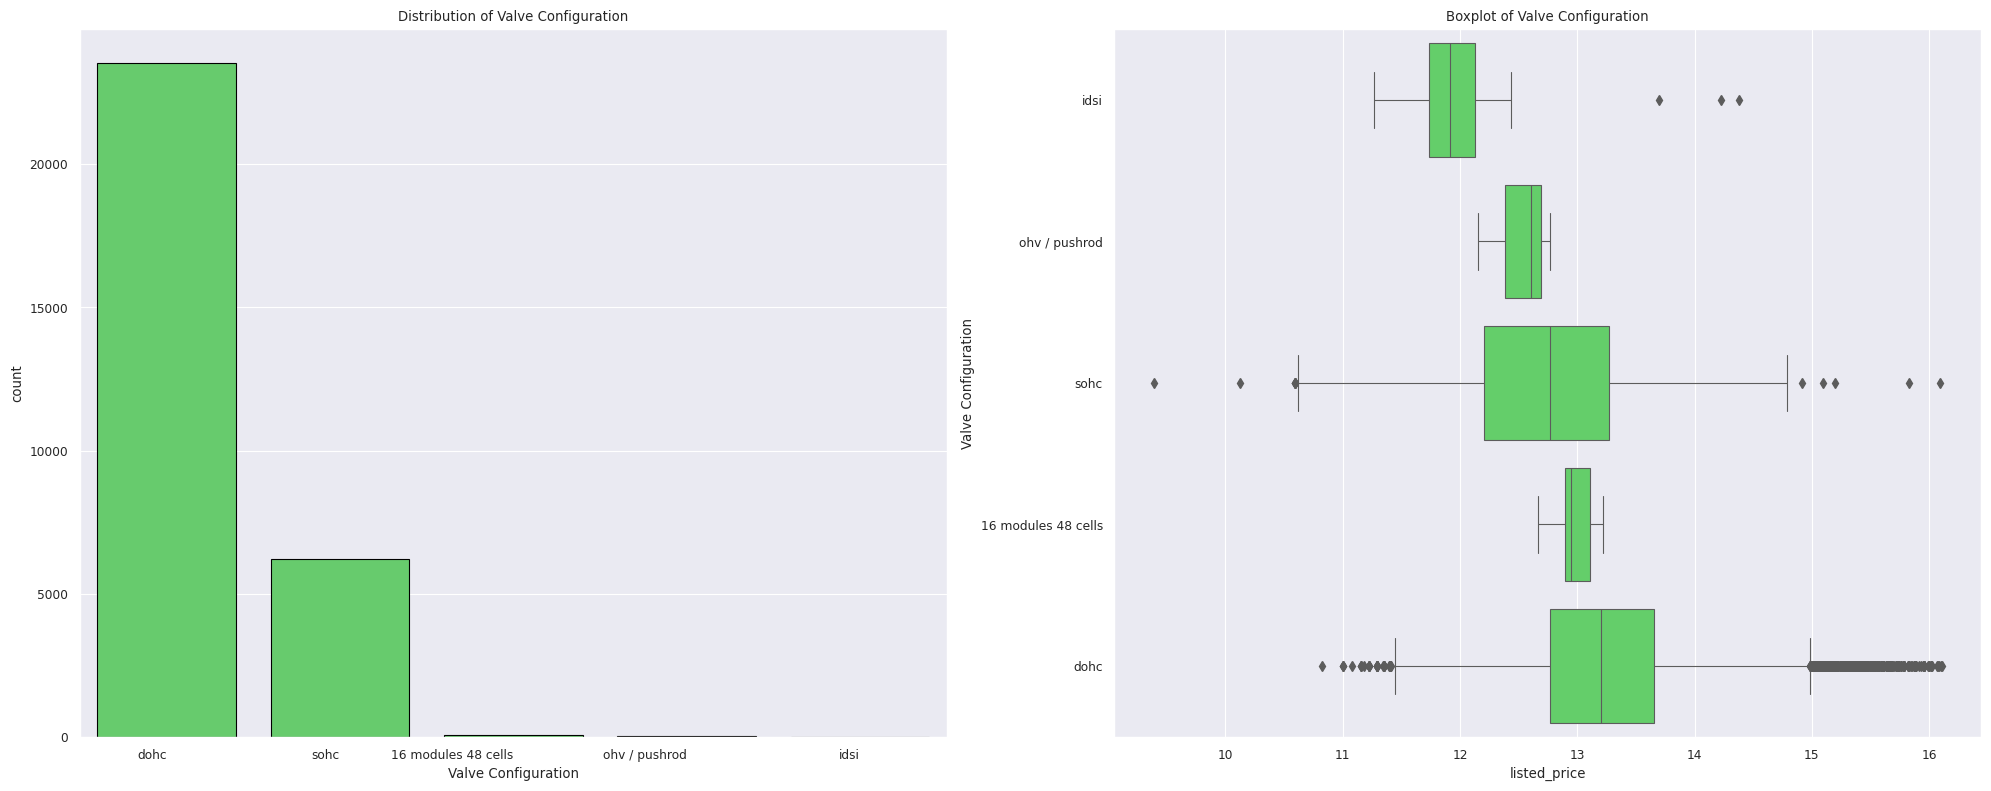

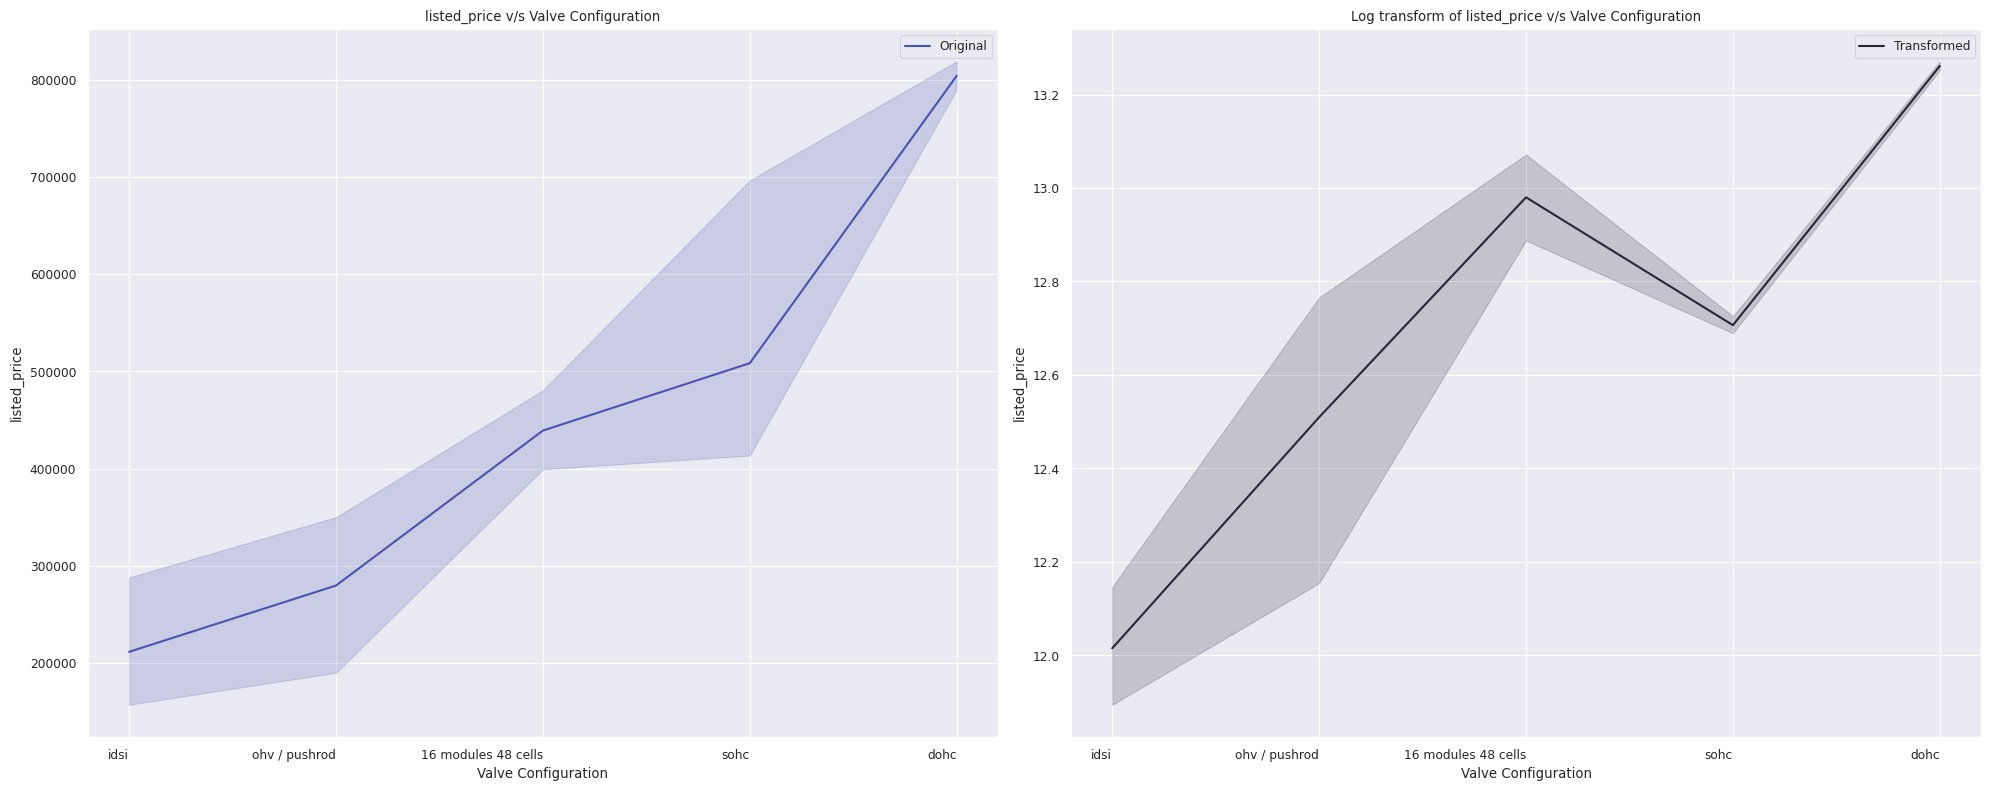

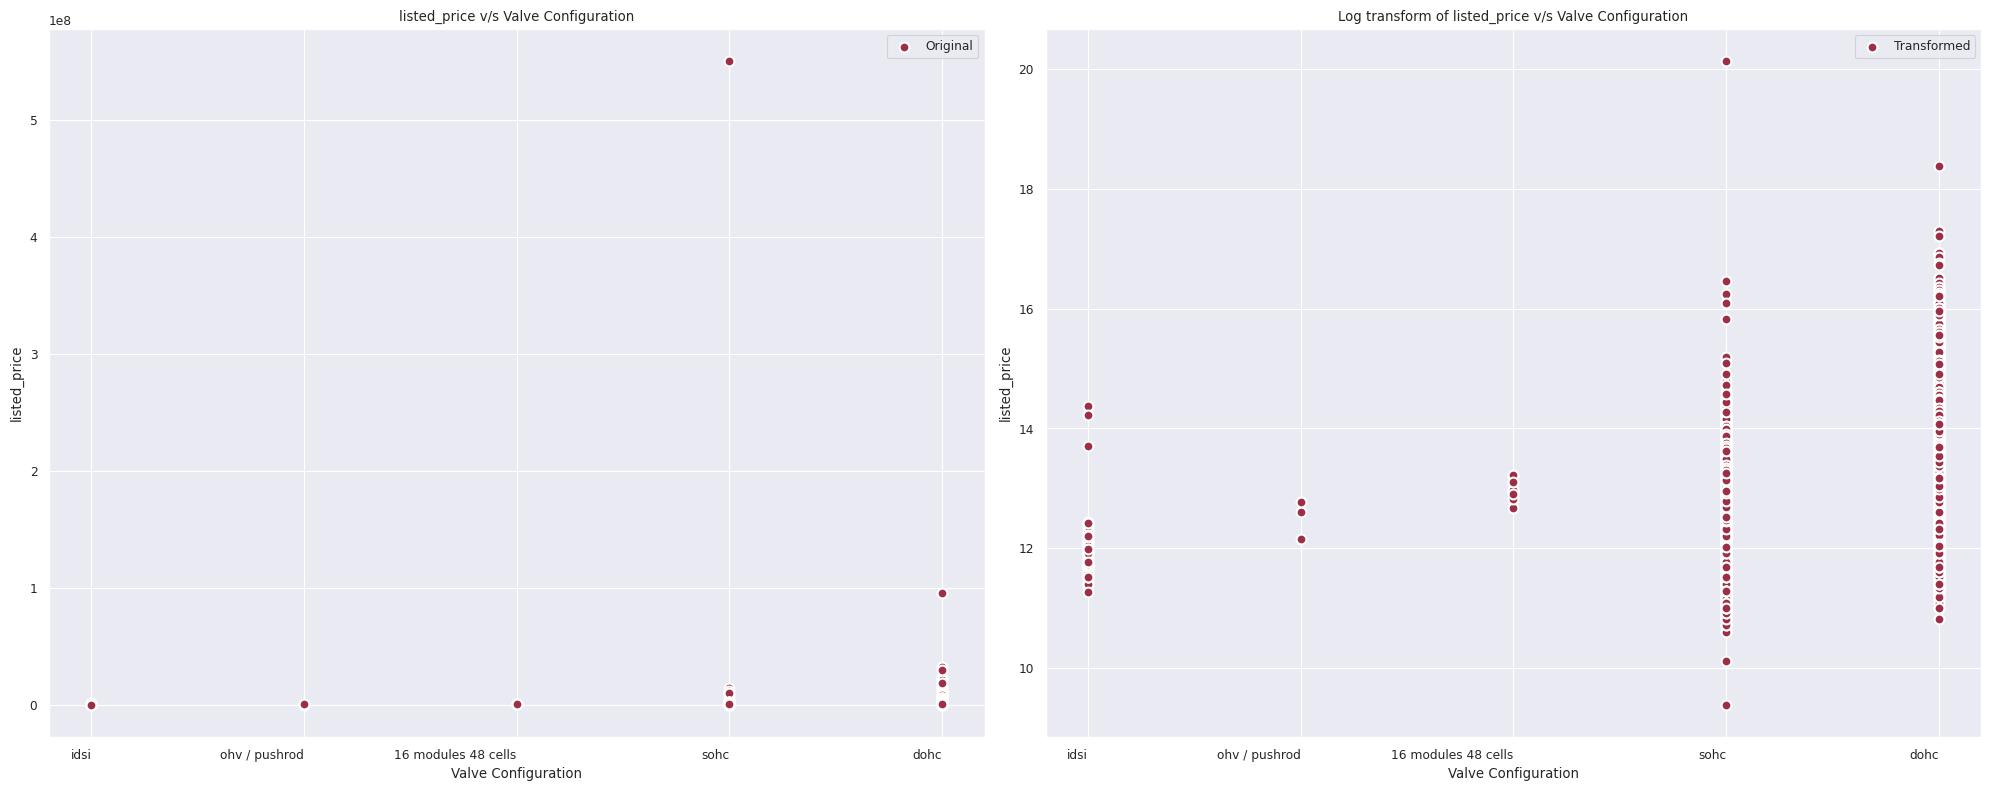

In [66]:
feature_dist_plots(df2, 'Valve Configuration', linewidth=0.8, sat=0.8, fontscale=1, rotation=0, transformation=np.log, sorted=True);
target_relation_plots(df, col='Valve Configuration', linewidth = 1.5, fontscale=1, rotation=0, sorted=True);
target_relation_plots(df, col='Valve Configuration', linewidth = 1.5, fontscale=1, rotation=0, sorted=True, plot='scatter', s=50);

---

### `Turbo Charger` and `Super Charger`

In [67]:
analyze_data(df2, 'Turbo Charger');

Overview of column "Turbo Charger"
+----------------+----------------------+
|    Measure     |        Value         |
+----------------+----------------------+
| Distinct Count |          2           |
|   Distinct %   | 0.005296329643557015 |
| Missing Count  |          0           |
|   Missing %    |         0.0          |
+----------------+----------------------+


Column Turbo Charger is not numeric
Common values for column "Turbo Charger"
+-------+-------+--------------------+--------------------+
| Value | Count |     Frequency      |   Mean of Target   |
+-------+-------+--------------------+--------------------+
| False | 20243 | 53.606800487262326 | 468039.4550708887  |
|  True | 17519 | 46.393199512737674 | 1105845.2625720645 |
+-------+-------+--------------------+--------------------+




In [68]:
analyze_data(df2, 'Super Charger');

Overview of column "Super Charger"
+----------------+----------------------+
|    Measure     |        Value         |
+----------------+----------------------+
| Distinct Count |          2           |
|   Distinct %   | 0.005296329643557015 |
| Missing Count  |          0           |
|   Missing %    |         0.0          |
+----------------+----------------------+


Column Super Charger is not numeric
Common values for column "Super Charger"
+-------+-------+--------------------+--------------------+
| Value | Count |     Frequency      |   Mean of Target   |
+-------+-------+--------------------+--------------------+
| False | 20243 | 53.606800487262326 | 468039.4550708887  |
|  True | 17519 | 46.393199512737674 | 1105845.2625720645 |
+-------+-------+--------------------+--------------------+




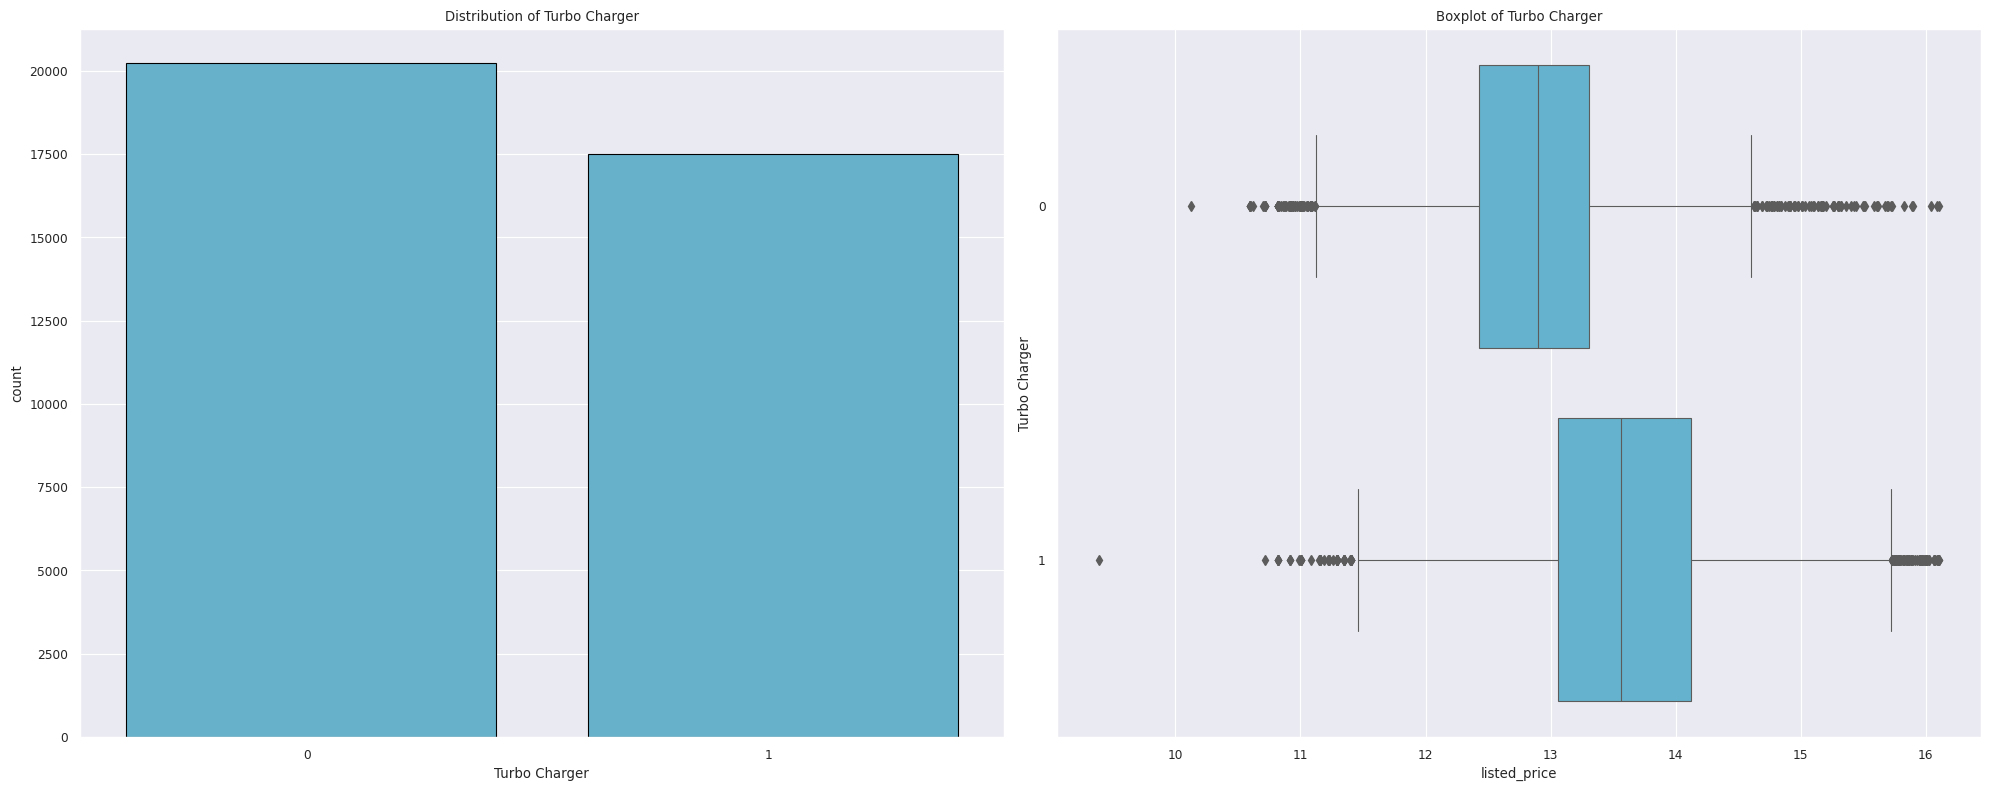

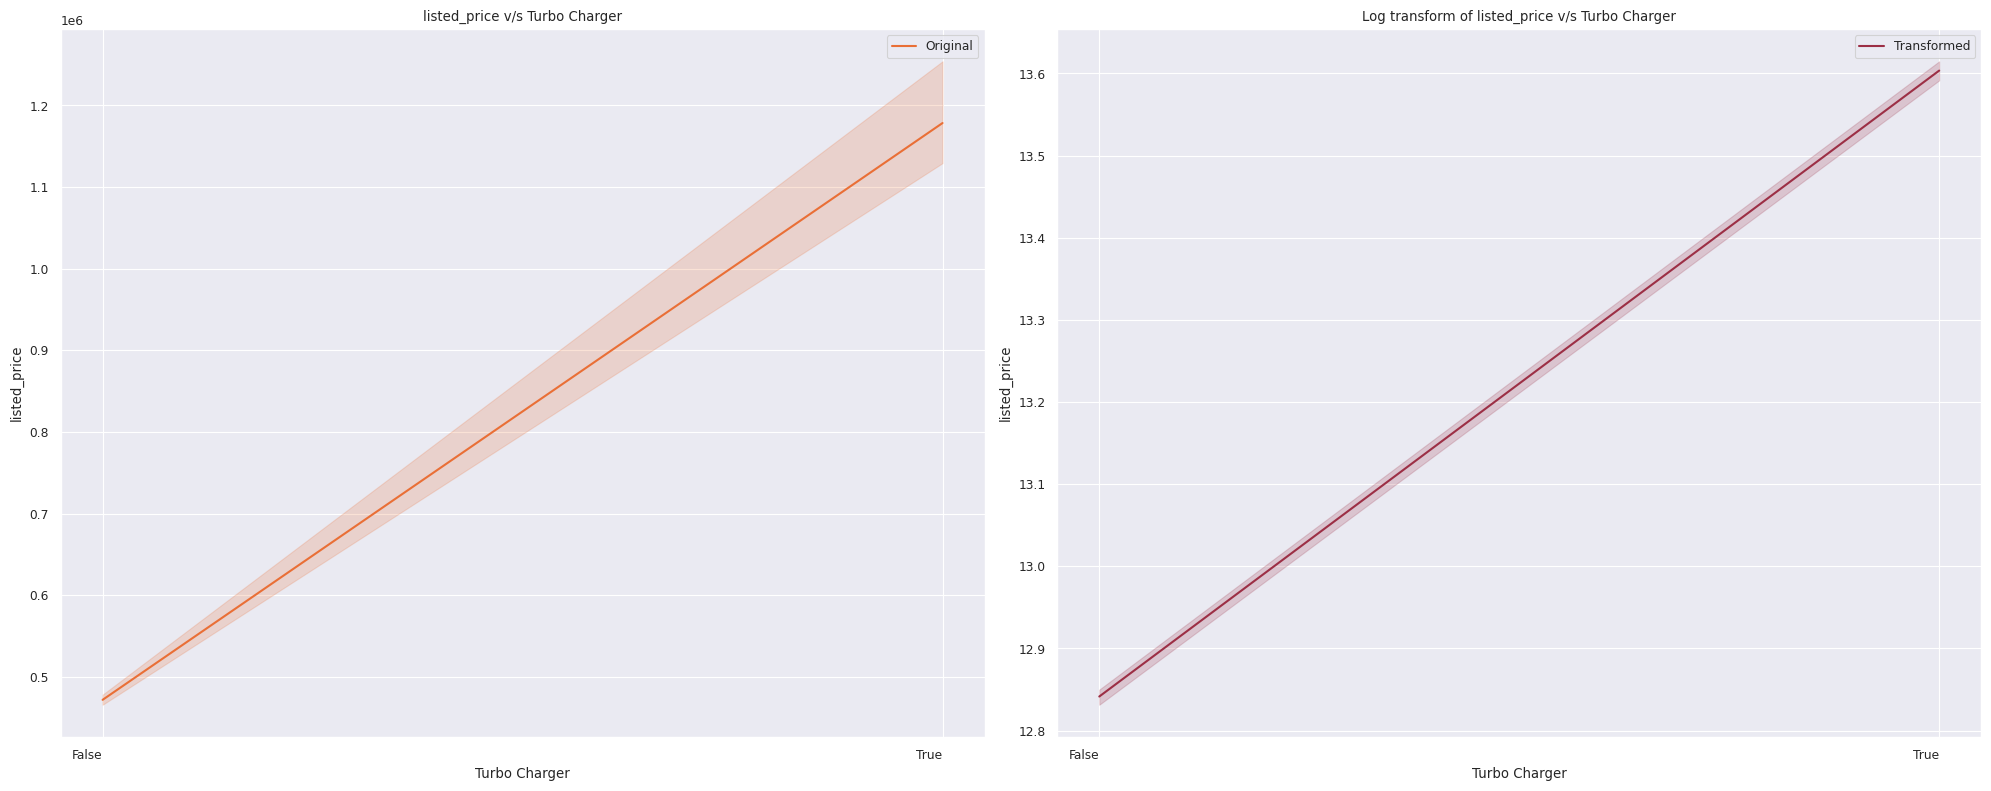

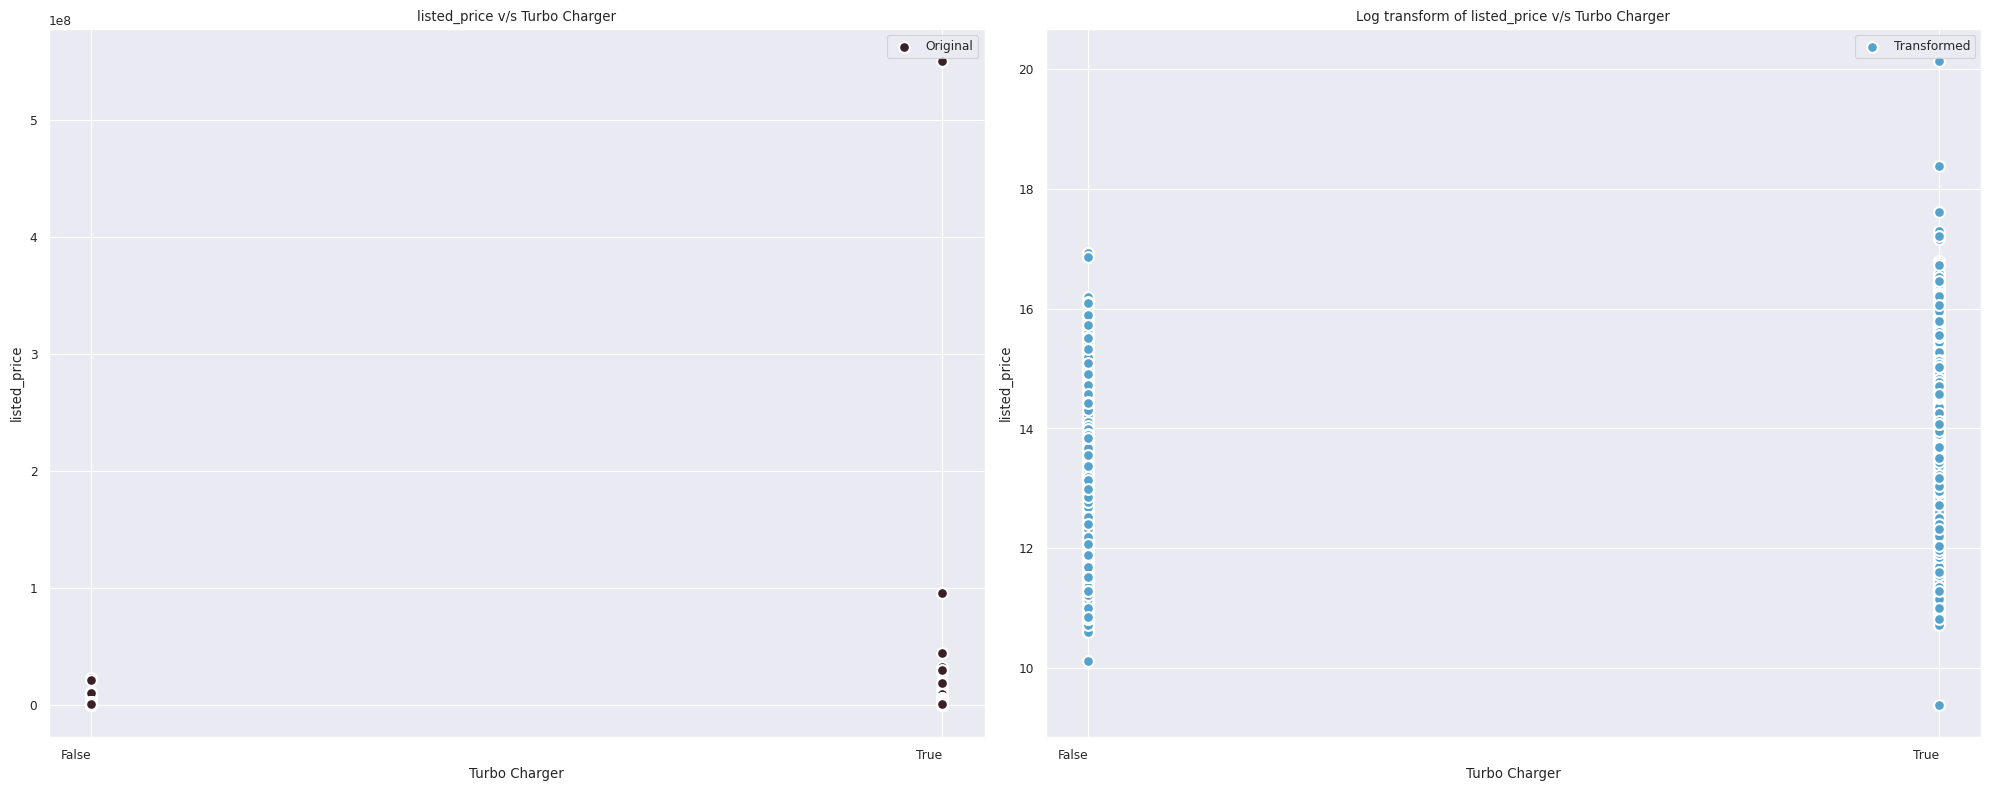

In [69]:
feature_dist_plots(df2, 'Turbo Charger', linewidth=0.8, sat=0.8, fontscale=1, rotation=0, category=True, transformation=np.log);
target_relation_plots(df, col='Turbo Charger', linewidth = 1.5, fontscale=1, rotation=0, sorted=True, plot='line');
target_relation_plots(df, col='Turbo Charger', linewidth = 1.5, fontscale=1, rotation=0, sorted=True, plot='scatter', s=60);

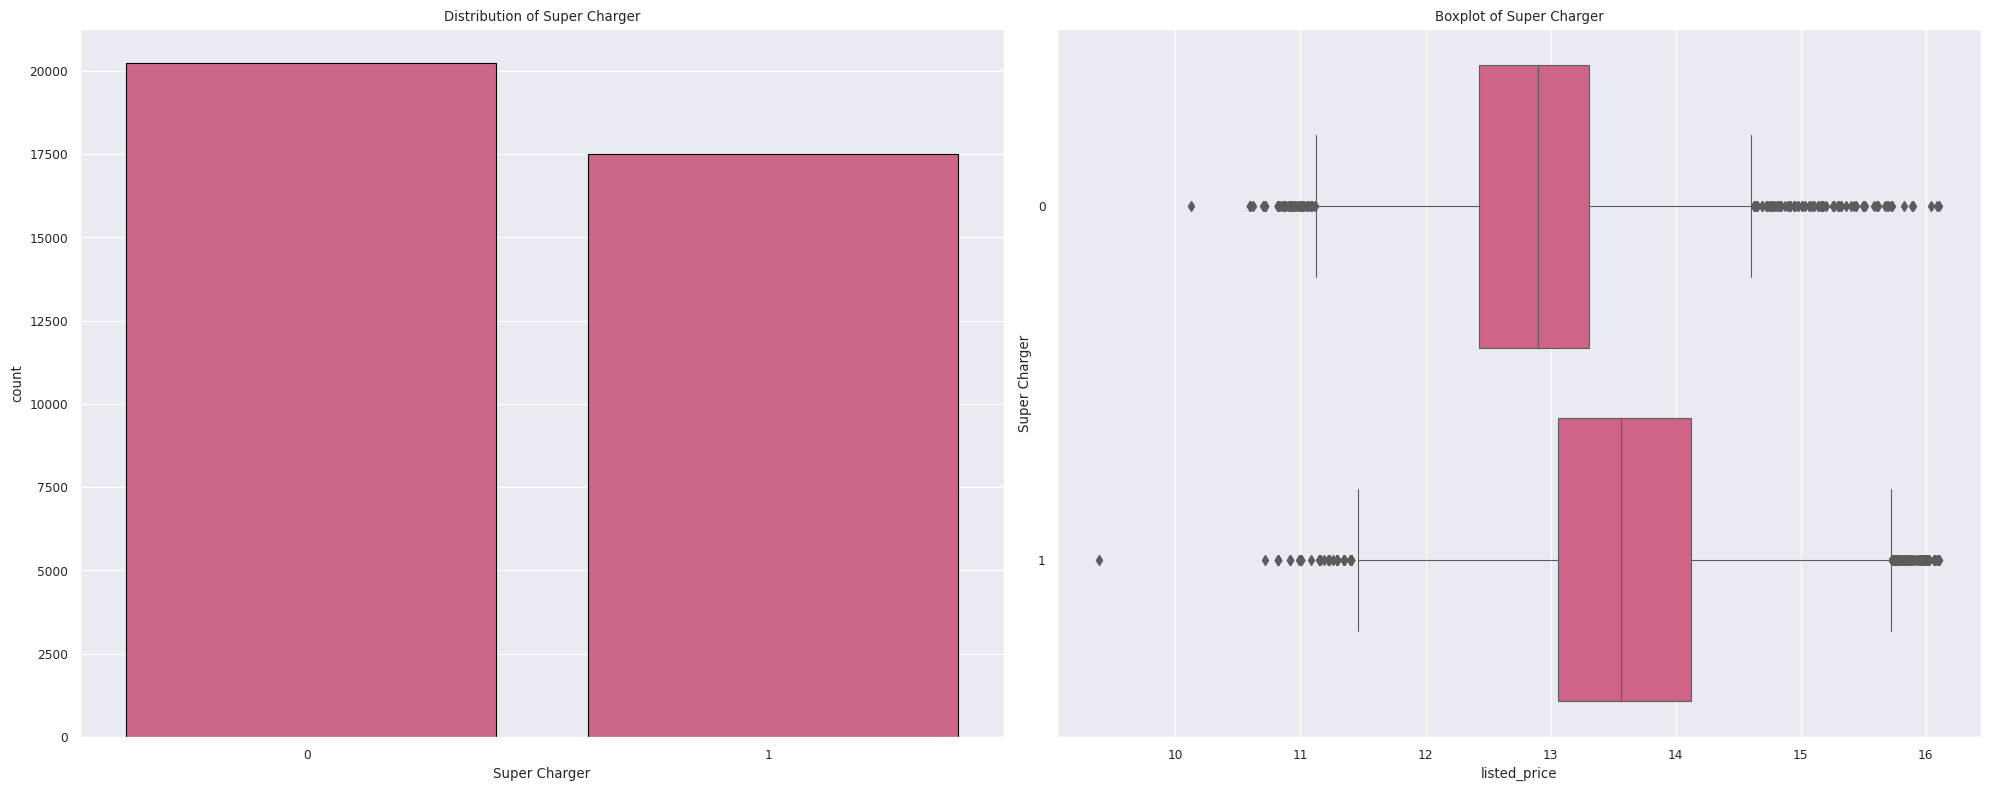

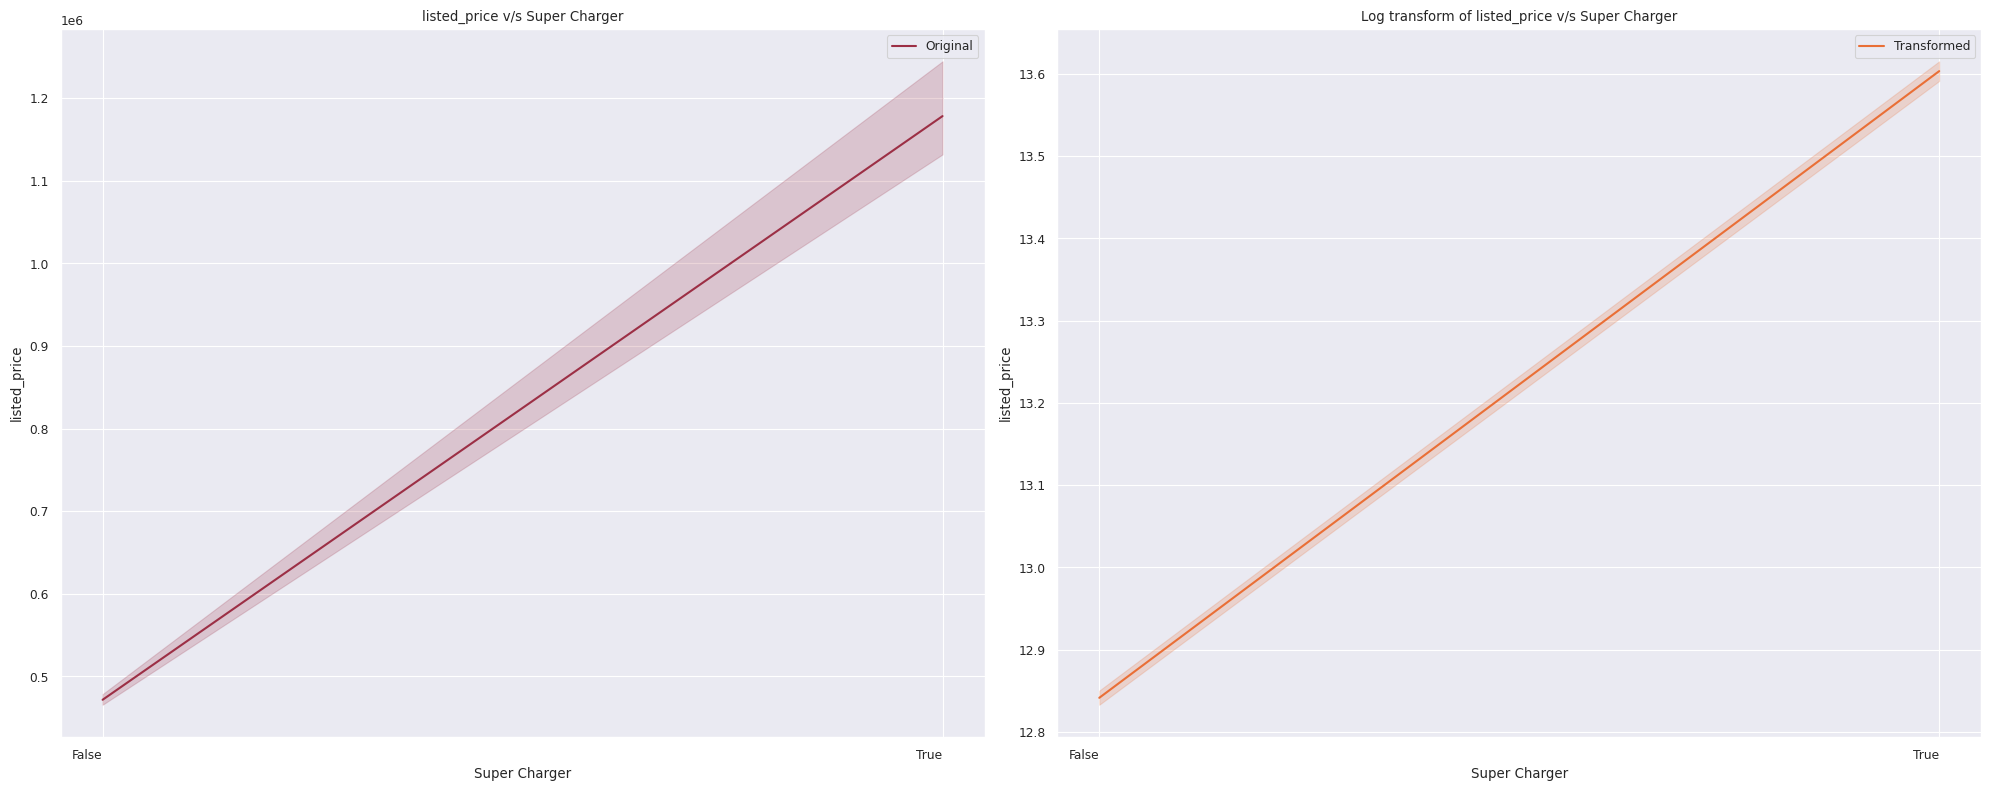

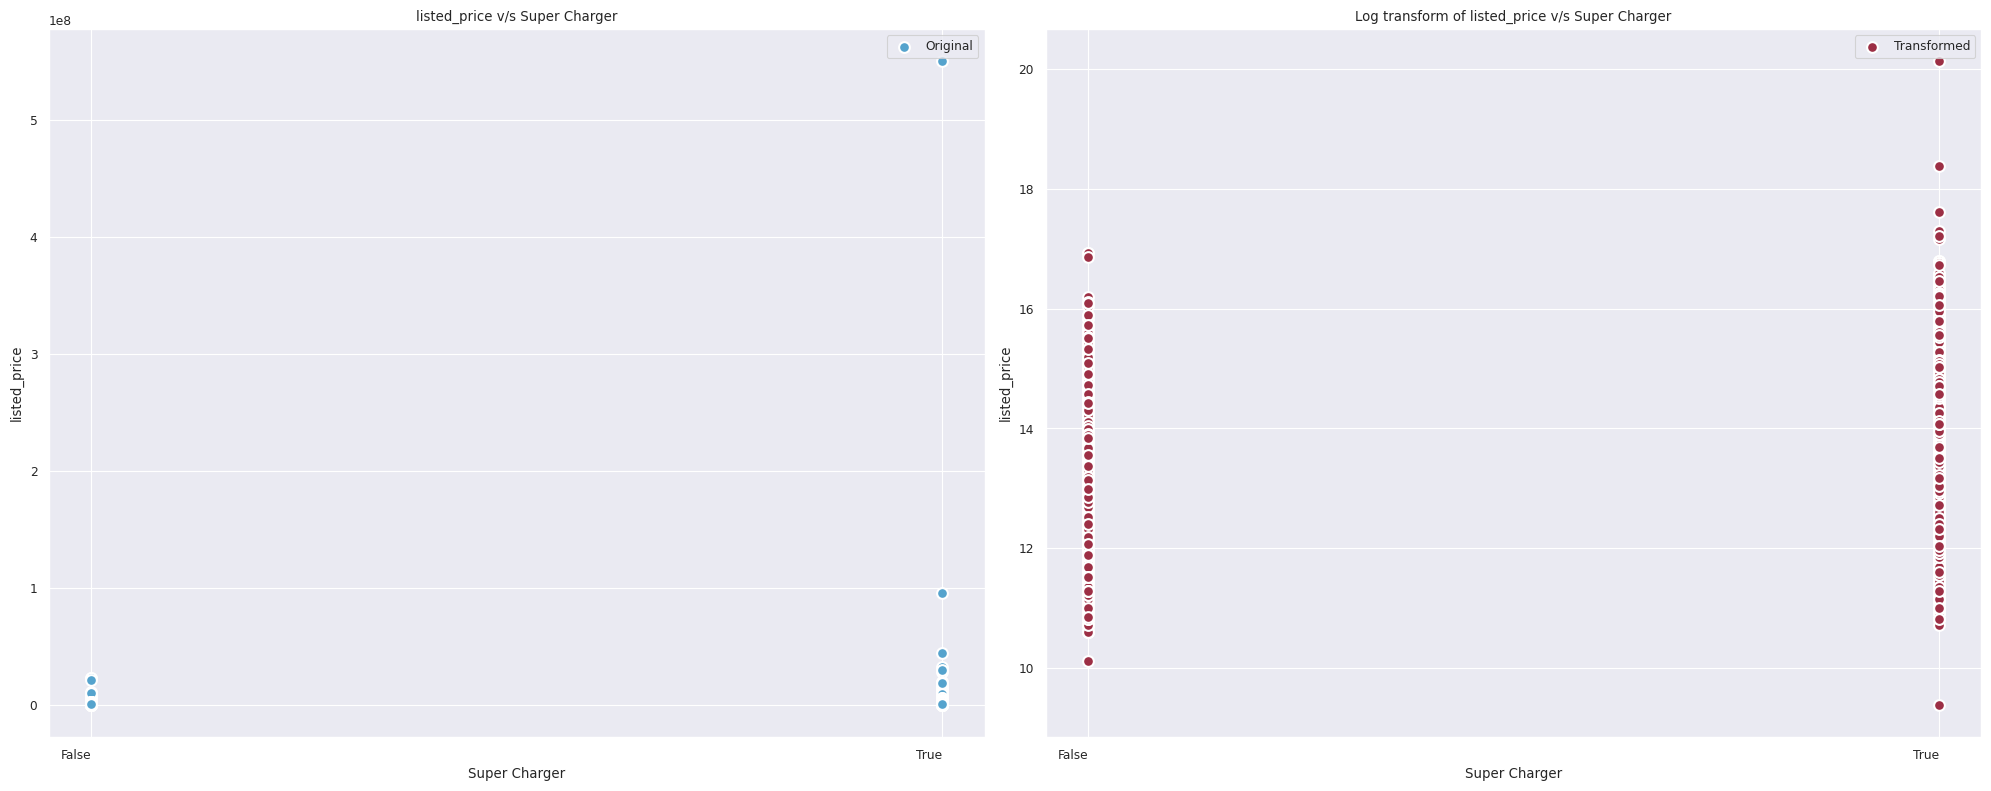

In [70]:
feature_dist_plots(df2, 'Super Charger', linewidth=0.8, sat=0.8, fontscale=1, rotation=0, category=True, transformation=np.log);
target_relation_plots(df, col='Super Charger', linewidth = 1.5, fontscale=1, rotation=0, sorted=True, plot='line');
target_relation_plots(df, col='Super Charger', linewidth = 1.5, fontscale=1, rotation=0, sorted=True, plot='scatter', s=60);

---

### `Length`, `Height` and `Width`

In [71]:
analyze_data(df2, 'Length', descriptive=True);

Overview of column "Length"
+----------------+--------------------+
|    Measure     |       Value        |
+----------------+--------------------+
| Distinct Count |        398         |
|   Distinct %   | 1.053969599067846  |
| Missing Count  |        362         |
|   Missing %    | 0.9586356654838196 |
|      Mean      | 4112.319652406417  |
|    Minimum     |       2752.0       |
|    Maximum     |       5350.0       |
+----------------+--------------------+


Quantile stats for column "Length"
+---------------------+--------+
|      Statistic      | Value  |
+---------------------+--------+
|       Minimum       | 2752.0 |
|    5th Percentile   | 3545.0 |
|  First Quartile, Q1 | 3795.0 |
|        Median       | 3995.0 |
|  Third Quartile, Q3 | 4440.0 |
|   95th Percentile   | 4780.0 |
|       Maximum       | 5350.0 |
|        Range        | 2598.0 |
| Interquartile Range | 645.0  |
+---------------------+--------+


Descriptive stats for column "Length"
+-------------------------

In [72]:
analyze_data(df2, 'Height', descriptive=True);

Overview of column "Height"
+----------------+--------------------+
|    Measure     |       Value        |
+----------------+--------------------+
| Distinct Count |        291         |
|   Distinct %   | 0.7706159631375457 |
| Missing Count  |        363         |
|   Missing %    | 0.9612838303055982 |
|      Mean      | 1577.476723976577  |
|    Minimum     |       1200.0       |
|    Maximum     |       2075.0       |
+----------------+--------------------+


Quantile stats for column "Height"
+---------------------+--------+
|      Statistic      | Value  |
+---------------------+--------+
|       Minimum       | 1200.0 |
|    5th Percentile   | 1460.0 |
|  First Quartile, Q1 | 1495.0 |
|        Median       | 1530.0 |
|  Third Quartile, Q3 | 1642.0 |
|   95th Percentile   | 1800.0 |
|       Maximum       | 2075.0 |
|        Range        | 875.0  |
| Interquartile Range | 147.0  |
+---------------------+--------+


Descriptive stats for column "Height"
+-------------------------

In [73]:
analyze_data(df2, 'Width', descriptive=True);

Overview of column "Width"
+----------------+--------------------+
|    Measure     |       Value        |
+----------------+--------------------+
| Distinct Count |        268         |
|   Distinct %   |  0.70970817223664  |
| Missing Count  |        370         |
|   Missing %    | 0.9798209840580477 |
|      Mean      | 1725.0784659820283 |
|    Minimum     |       1312.0       |
|    Maximum     |       2220.0       |
+----------------+--------------------+


Quantile stats for column "Width"
+---------------------+--------+
|      Statistic      | Value  |
+---------------------+--------+
|       Minimum       | 1312.0 |
|    5th Percentile   | 1495.0 |
|  First Quartile, Q1 | 1677.0 |
|        Median       | 1710.0 |
|  Third Quartile, Q3 | 1790.0 |
|   95th Percentile   | 1960.0 |
|       Maximum       | 2220.0 |
|        Range        | 908.0  |
| Interquartile Range | 113.0  |
+---------------------+--------+


Descriptive stats for column "Width"
+--------------------------+-

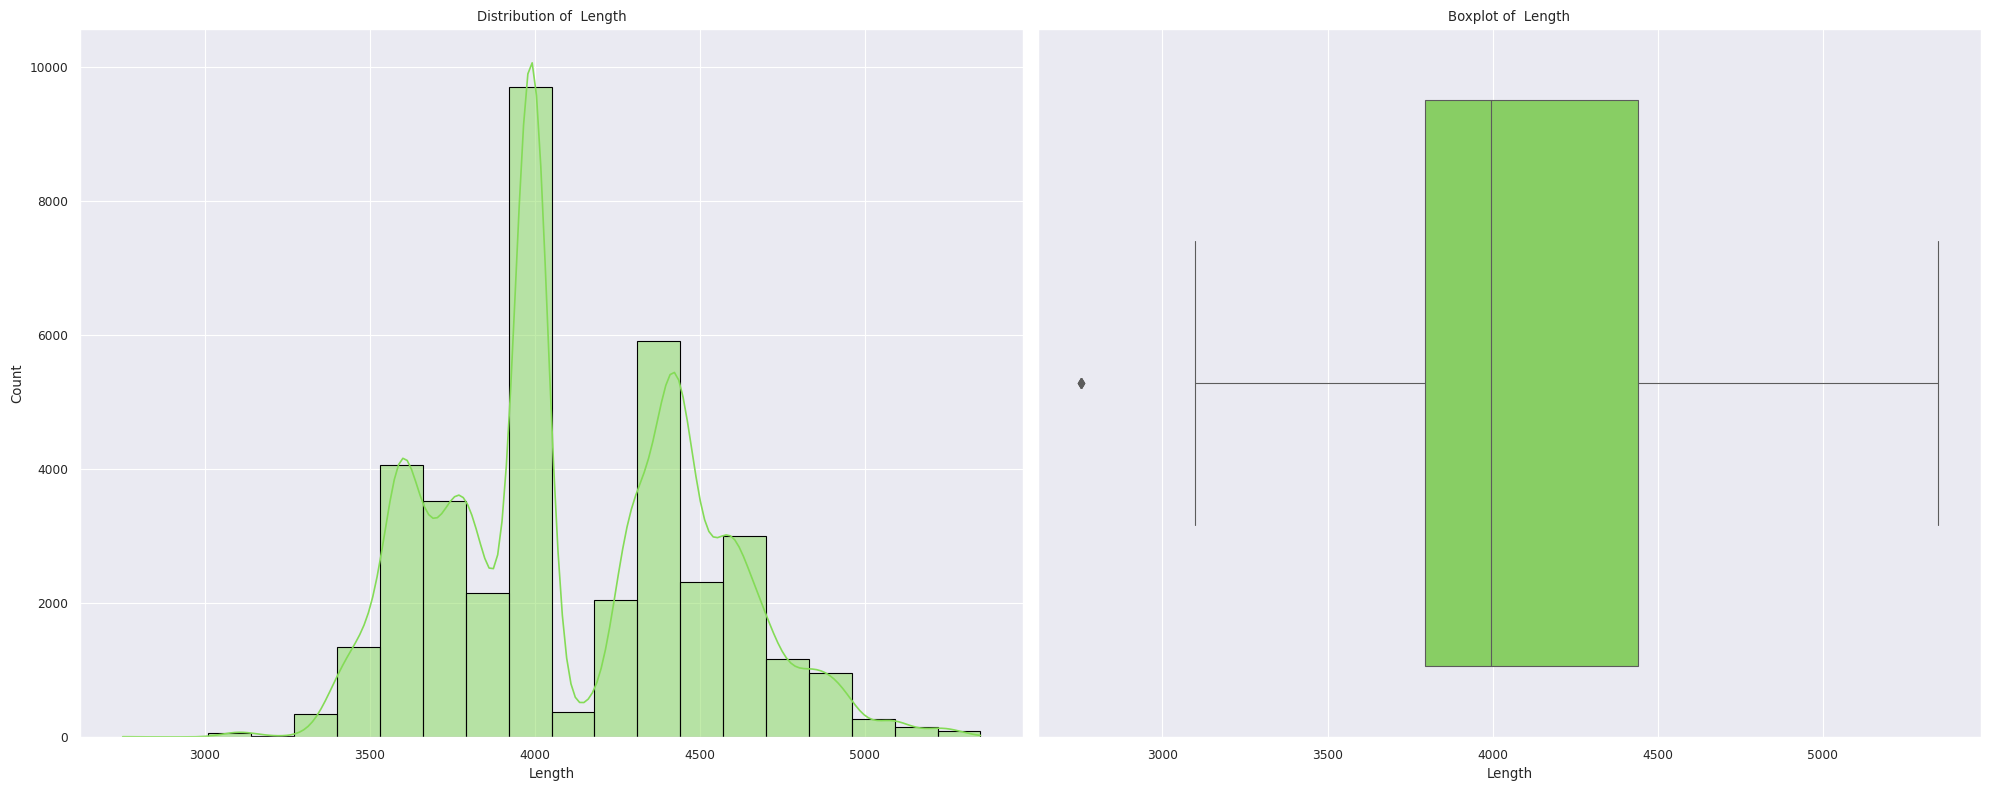

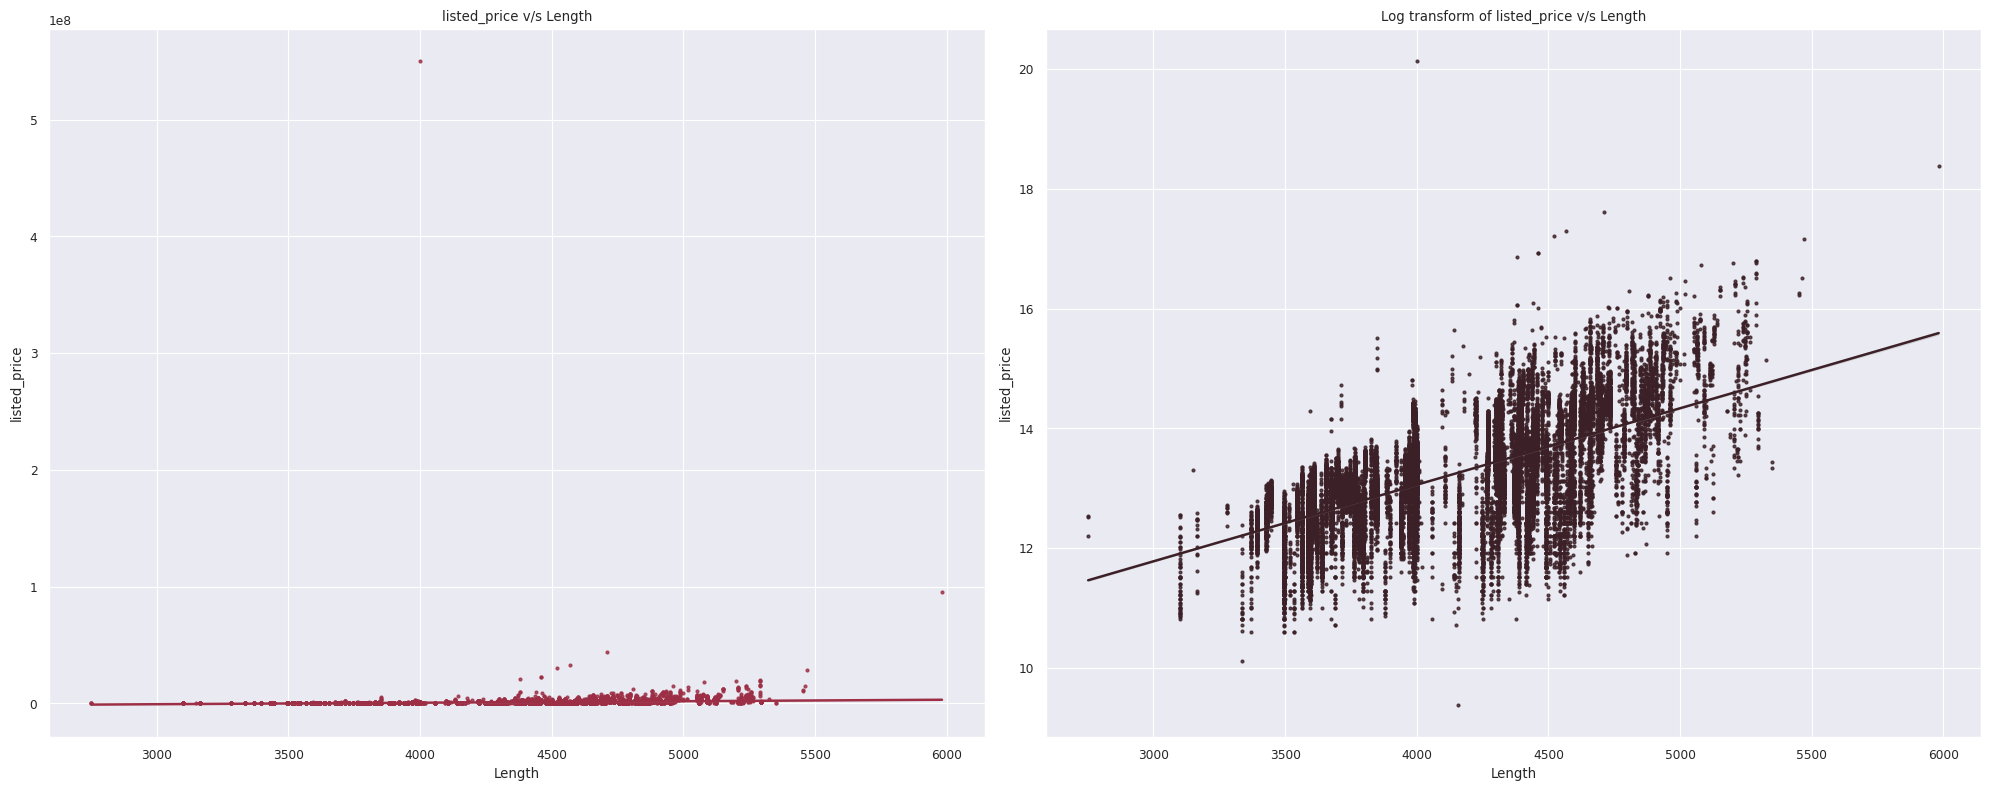

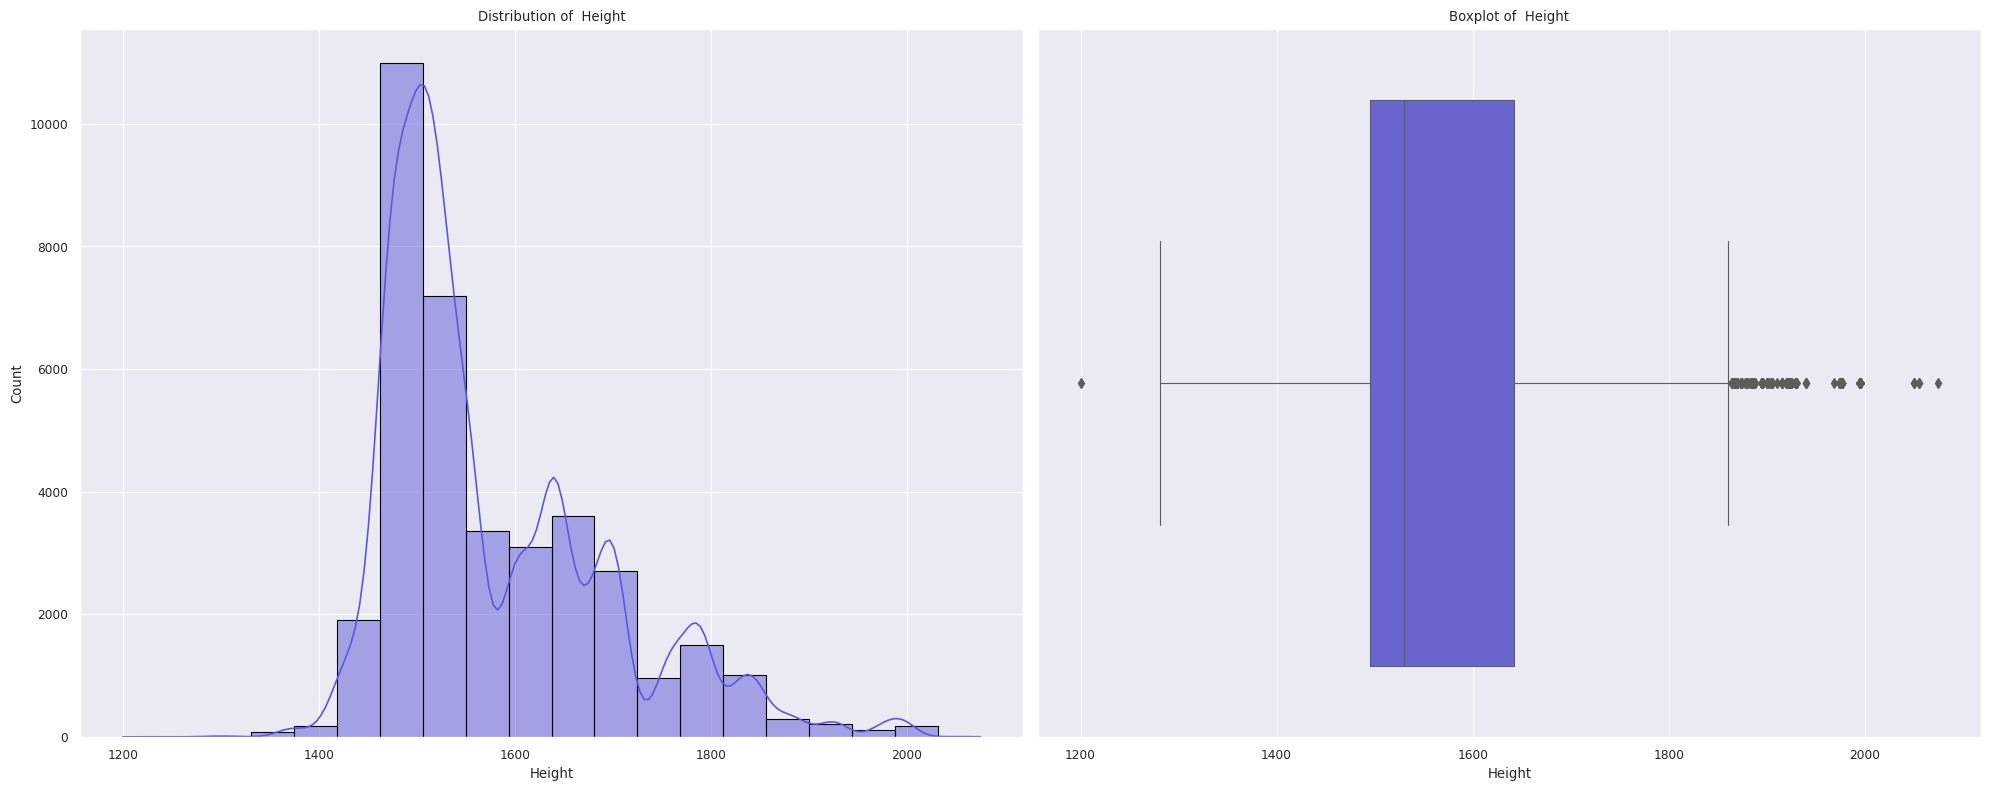

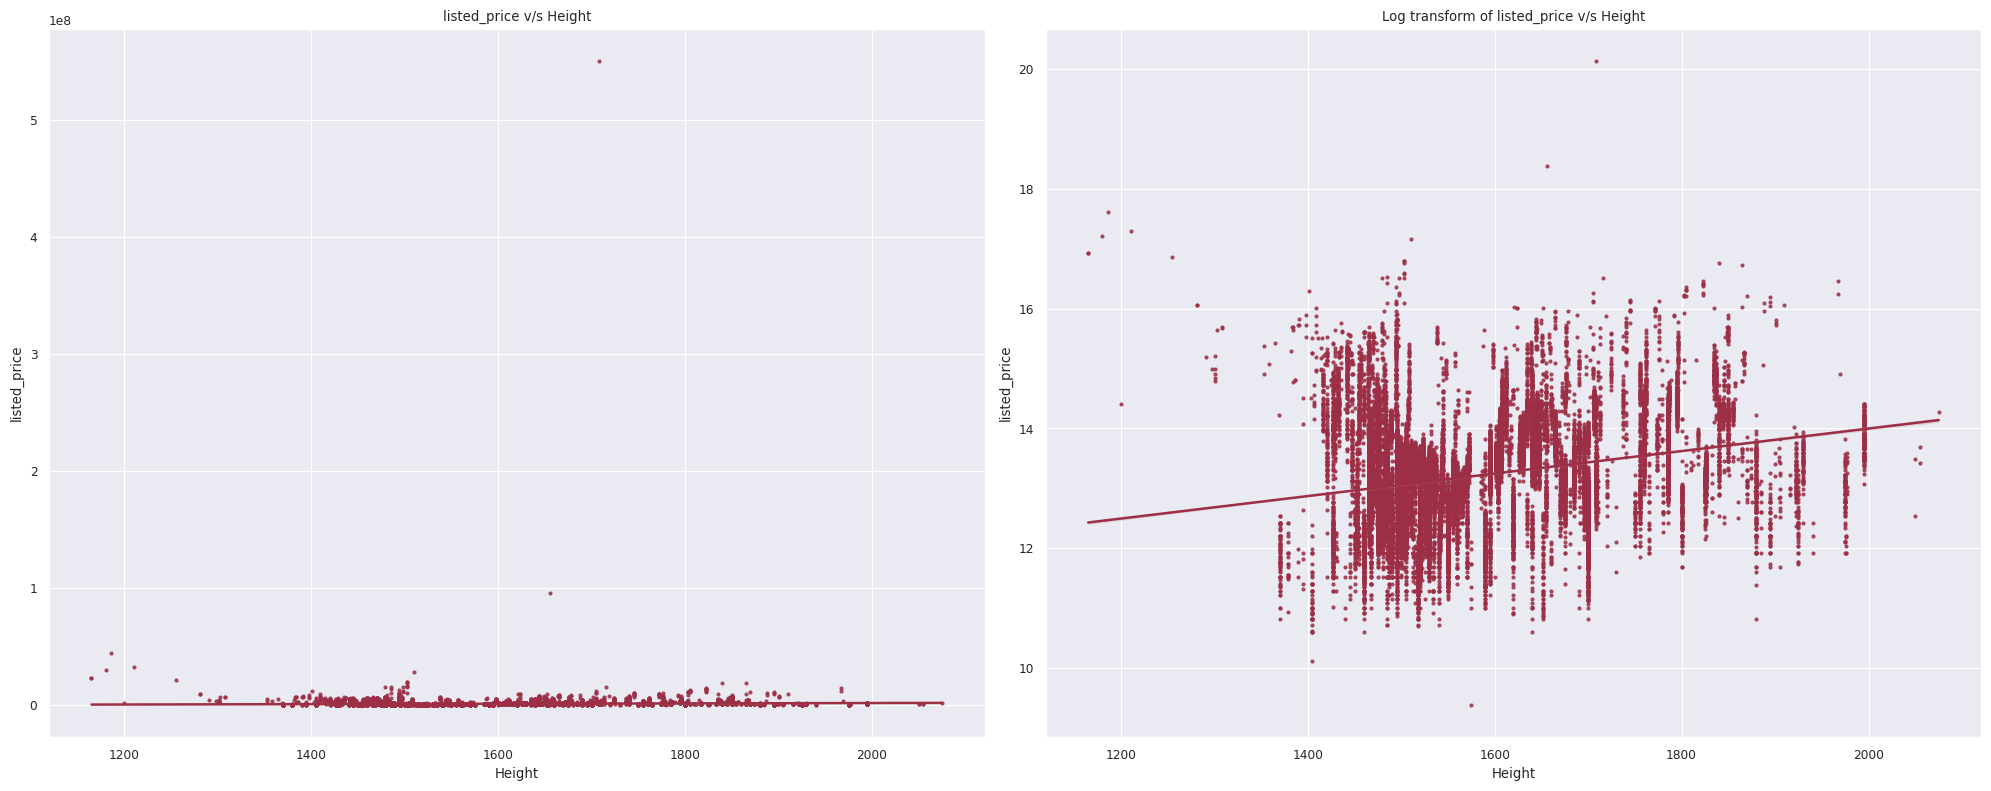

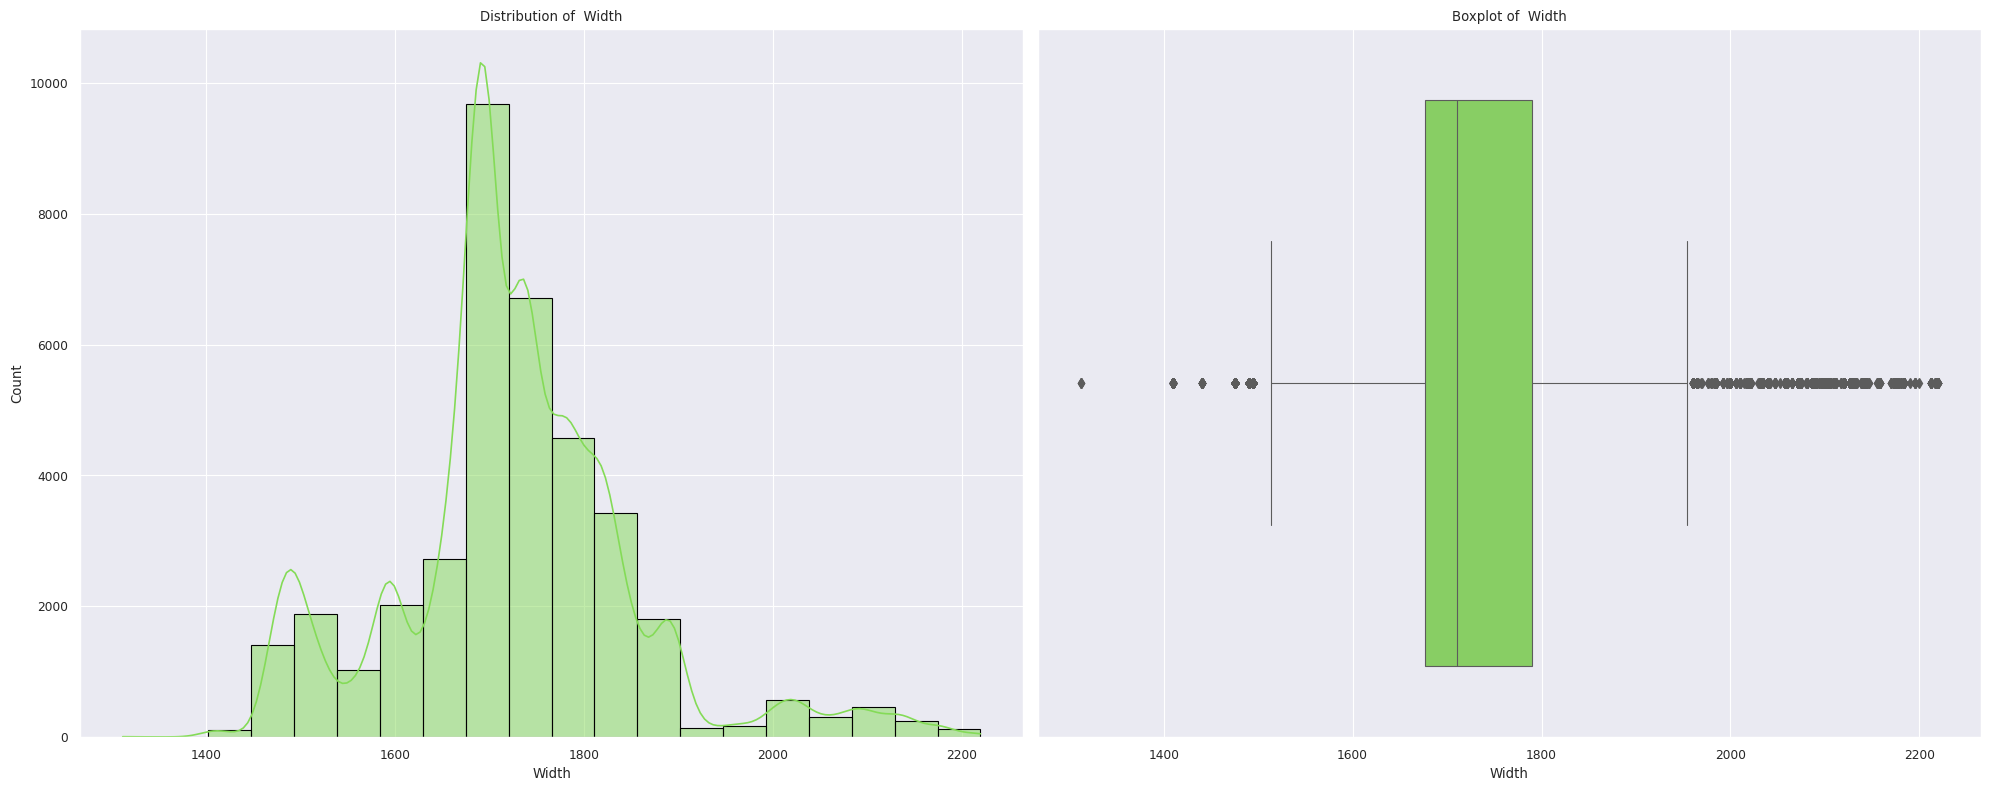

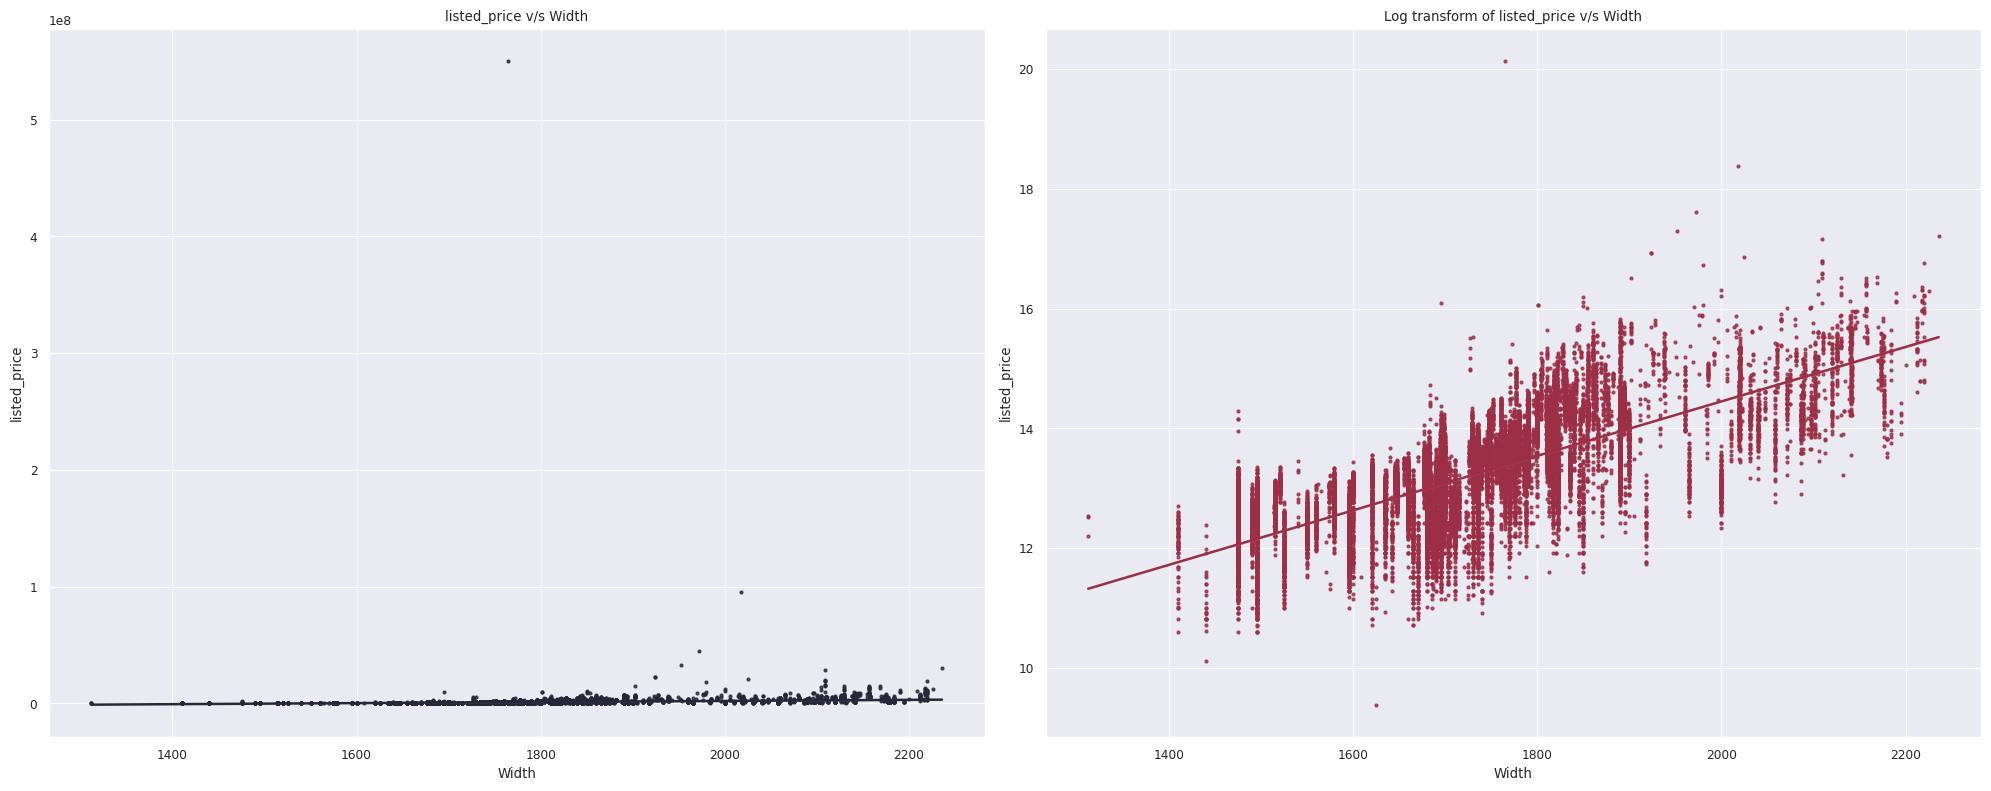

In [74]:
feature_dist_plots(df2, 'Length', linewidth=0.8, sat=0.8, fontscale=1, rotation=0);
target_relation_plots(df, col='Length', fontscale=1, rotation=0, sorted=True, plot='reg', scatter_kws={'s':4}, order=1);

feature_dist_plots(df2, 'Height', linewidth=0.8, sat=0.8, fontscale=1, rotation=0);
target_relation_plots(df, col='Height', fontscale=1, rotation=0, sorted=True, plot='reg', scatter_kws={'s':4}, order=1);

feature_dist_plots(df2, 'Width', linewidth=0.8, sat=0.8, fontscale=1, rotation=0);
target_relation_plots(df, col='Width', fontscale=1, rotation=0, sorted=True, plot='reg', scatter_kws={'s':4}, order=1);

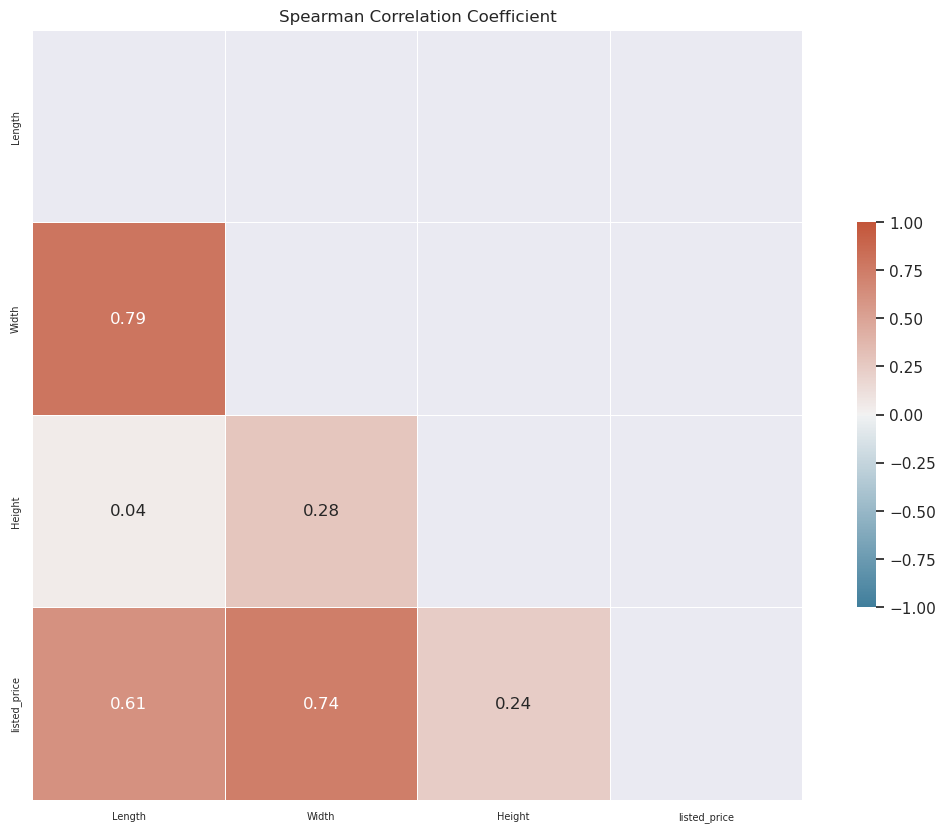

In [75]:
correlation_with_plot(df2, features=['Length', 'Width', 'Height', TARGET], target=False, annot=True, method='spearman', clip=True);

### Suggestions

1. `Height` is not very informative. **Drop this column**
2. `Length` is highly correlated with `Width`. If training a linear model, dropping one of them would be advisable

In [76]:
def Height_transformation(df: pd.DataFrame):
    """
    Drop the 'Height' column
    """
    df.drop('Height', axis=1, inplace=True)
    return

suggested_transformations.append(Height_transformation)

---

### `Wheel Base`

In [77]:
analyze_data(df2, 'Wheel Base', descriptive=True);

Overview of column "Wheel Base"
+----------------+--------------------+
|    Measure     |       Value        |
+----------------+--------------------+
| Distinct Count |        210         |
|   Distinct %   | 0.5561146125734866 |
| Missing Count  |        555         |
|   Missing %    | 1.4697314760870717 |
|      Mean      | 2545.137070981267  |
|    Minimum     |       1840.0       |
|    Maximum     |       3264.0       |
+----------------+--------------------+


Quantile stats for column "Wheel Base"
+---------------------+-------------------+
|      Statistic      |       Value       |
+---------------------+-------------------+
|       Minimum       |       1840.0      |
|    5th Percentile   |       2360.0      |
|  First Quartile, Q1 |       2425.0      |
|        Median       |       2520.0      |
|  Third Quartile, Q3 |       2642.0      |
|   95th Percentile   | 2831.999999999971 |
|       Maximum       |       3264.0      |
|        Range        |       1424.0      |
| I

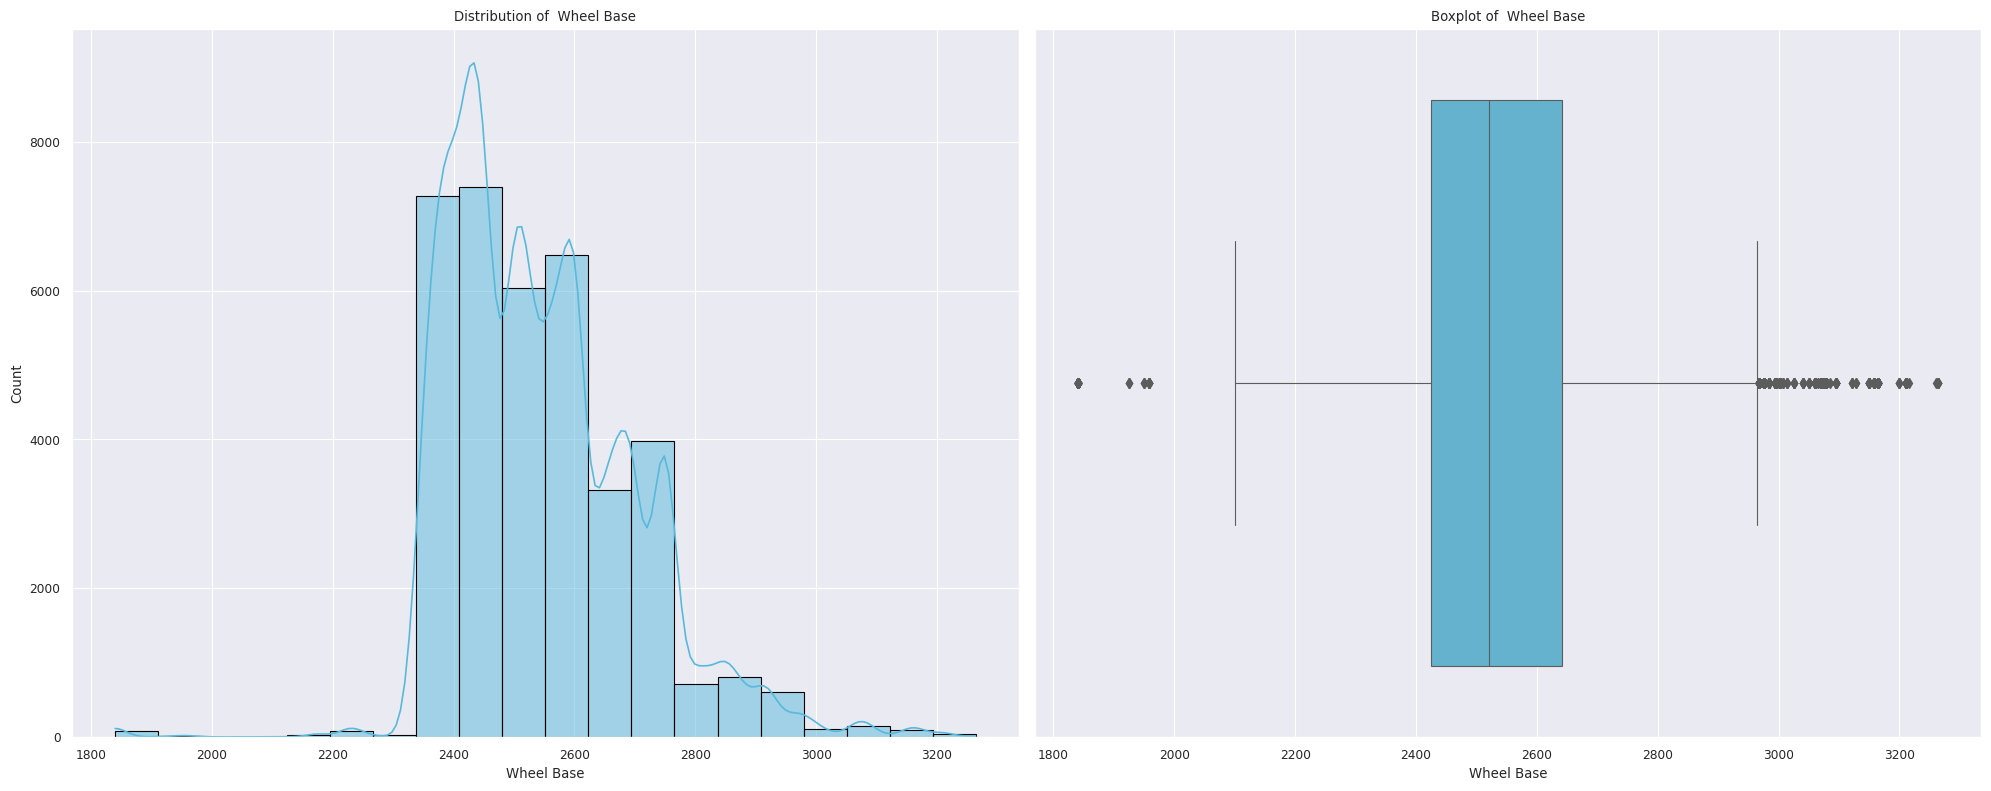

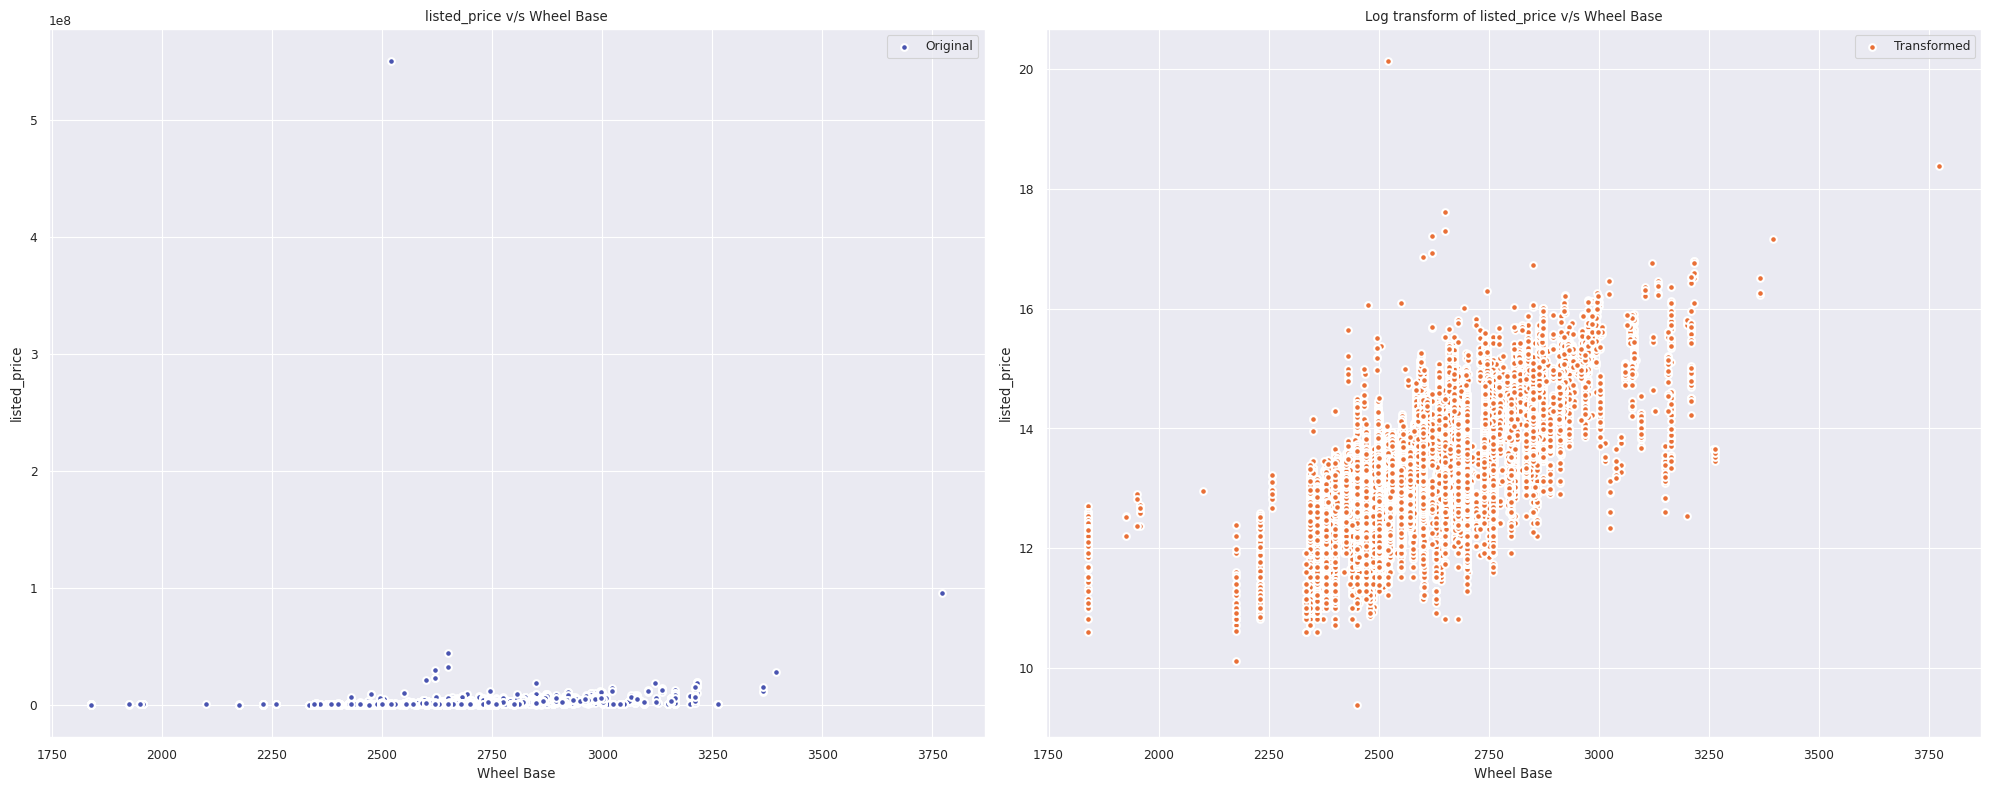

In [78]:
feature_dist_plots(df2, 'Wheel Base', linewidth=0.8, sat=0.8, fontscale=1, rotation=0);
target_relation_plots(df, col='Wheel Base', linewidth = 1.5, fontscale=1, rotation=0, sorted=True, plot='scatter');

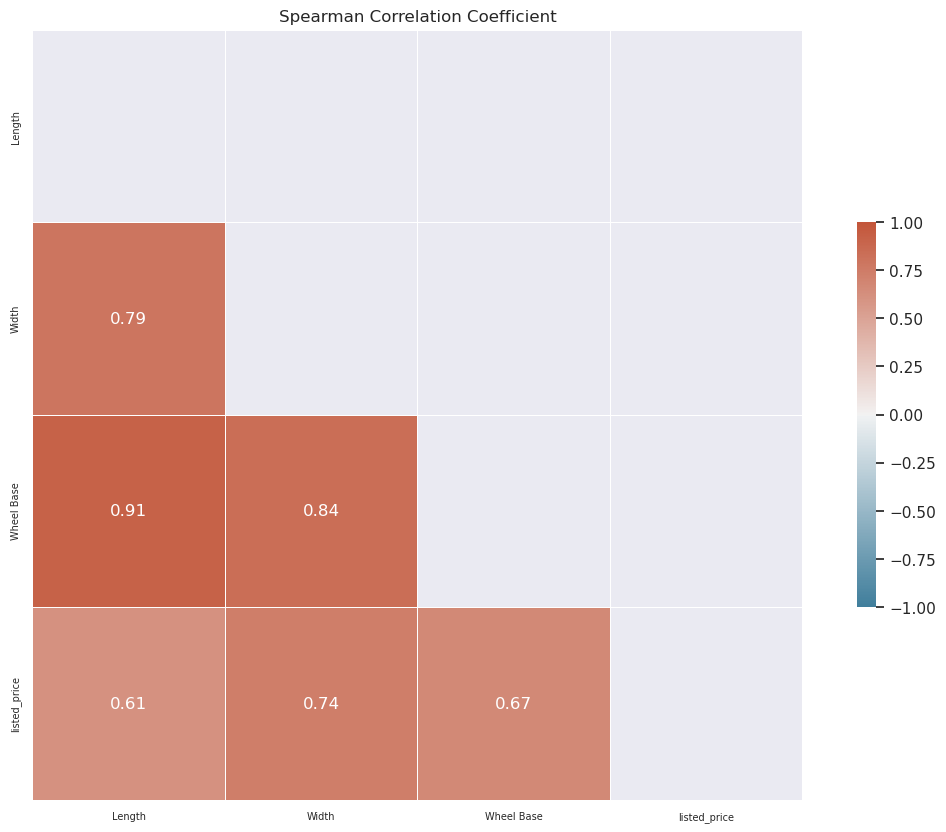

In [79]:
correlation_with_plot(df2, features=['Length', 'Width', 'Wheel Base', TARGET], target=False, annot=True, method='spearman', clip=True);

### Suggestions

`Wheel Base` is VERY HIGHLY correlated with `Length`. We should drop one of them, but the choice is not entirely clear - `Length` has a lower influence on price but is is less correlated with `Width`.

In [80]:
def Length_transformation(df: pd.DataFrame):
    """
    Drop the 'Length' column
    """
    df.drop('Length', axis=1, inplace=True)
    return

suggested_transformations.append(Length_transformation)

---

### `Front Tread` and `Rear Tread`

In [81]:
analyze_data(df2, 'Front Tread');

Overview of column "Front Tread"
+----------------+--------------------+
|    Measure     |       Value        |
+----------------+--------------------+
| Distinct Count |        153         |
|   Distinct %   | 0.4051692177321116 |
| Missing Count  |       15852        |
|   Missing %    |  41.9787087548329  |
|      Mean      | 1469.768023733455  |
|    Minimum     |       1143.0       |
|    Maximum     |       1690.0       |
+----------------+--------------------+


Quantile stats for column "Front Tread"
+---------------------+--------+
|      Statistic      | Value  |
+---------------------+--------+
|       Minimum       | 1143.0 |
|    5th Percentile   | 1295.0 |
|  First Quartile, Q1 | 1420.0 |
|        Median       | 1485.0 |
|  Third Quartile, Q3 | 1529.0 |
|   95th Percentile   | 1600.0 |
|       Maximum       | 1690.0 |
|        Range        | 547.0  |
| Interquartile Range | 109.0  |
+---------------------+--------+


Extremums for column "Front Tread"
Maximum 5 values
+-

In [82]:
analyze_data(df2, 'Rear Tread');

Overview of column "Rear Tread"
+----------------+---------------------+
|    Measure     |        Value        |
+----------------+---------------------+
| Distinct Count |         170         |
|   Distinct %   | 0.45018801970234623 |
| Missing Count  |        15852        |
|   Missing %    |   41.9787087548329  |
|      Mean      |  1469.0505431309903 |
|    Minimum     |         15.0        |
|    Maximum     |        1834.0       |
+----------------+---------------------+


Quantile stats for column "Rear Tread"
+---------------------+--------+
|      Statistic      | Value  |
+---------------------+--------+
|       Minimum       |  15.0  |
|    5th Percentile   | 1290.0 |
|  First Quartile, Q1 | 1420.0 |
|        Median       | 1493.0 |
|  Third Quartile, Q3 | 1525.0 |
|   95th Percentile   | 1605.0 |
|       Maximum       | 1834.0 |
|        Range        | 1819.0 |
| Interquartile Range | 105.0  |
+---------------------+--------+


Extremums for column "Rear Tread"
Maximum 5 v

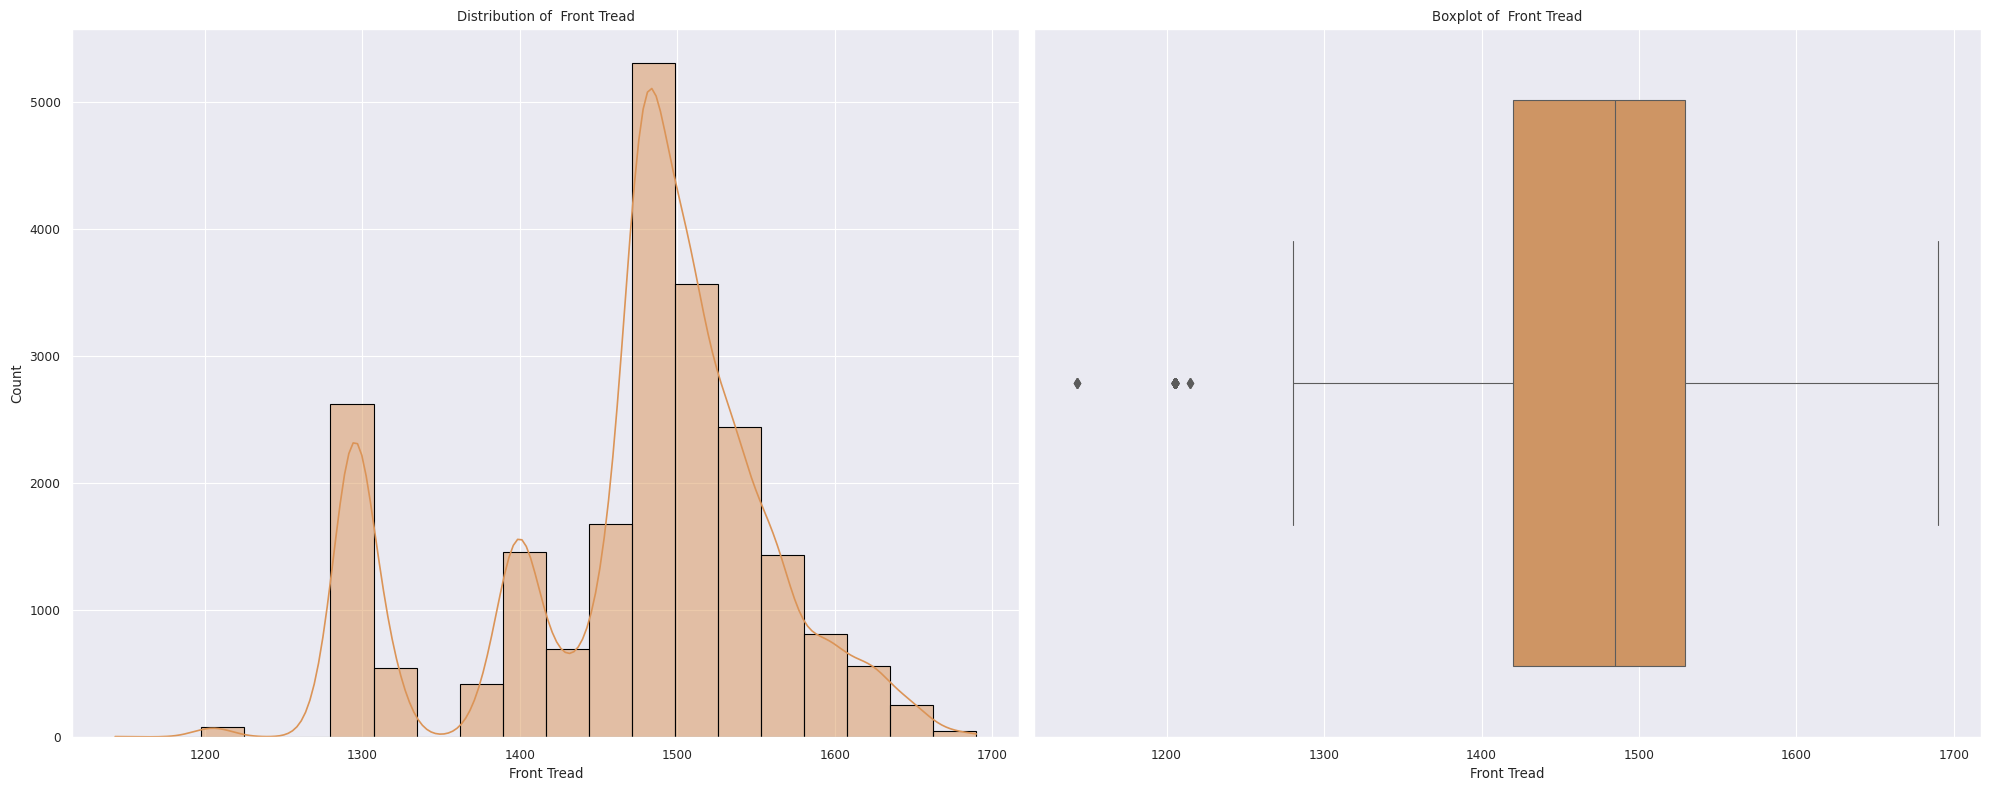

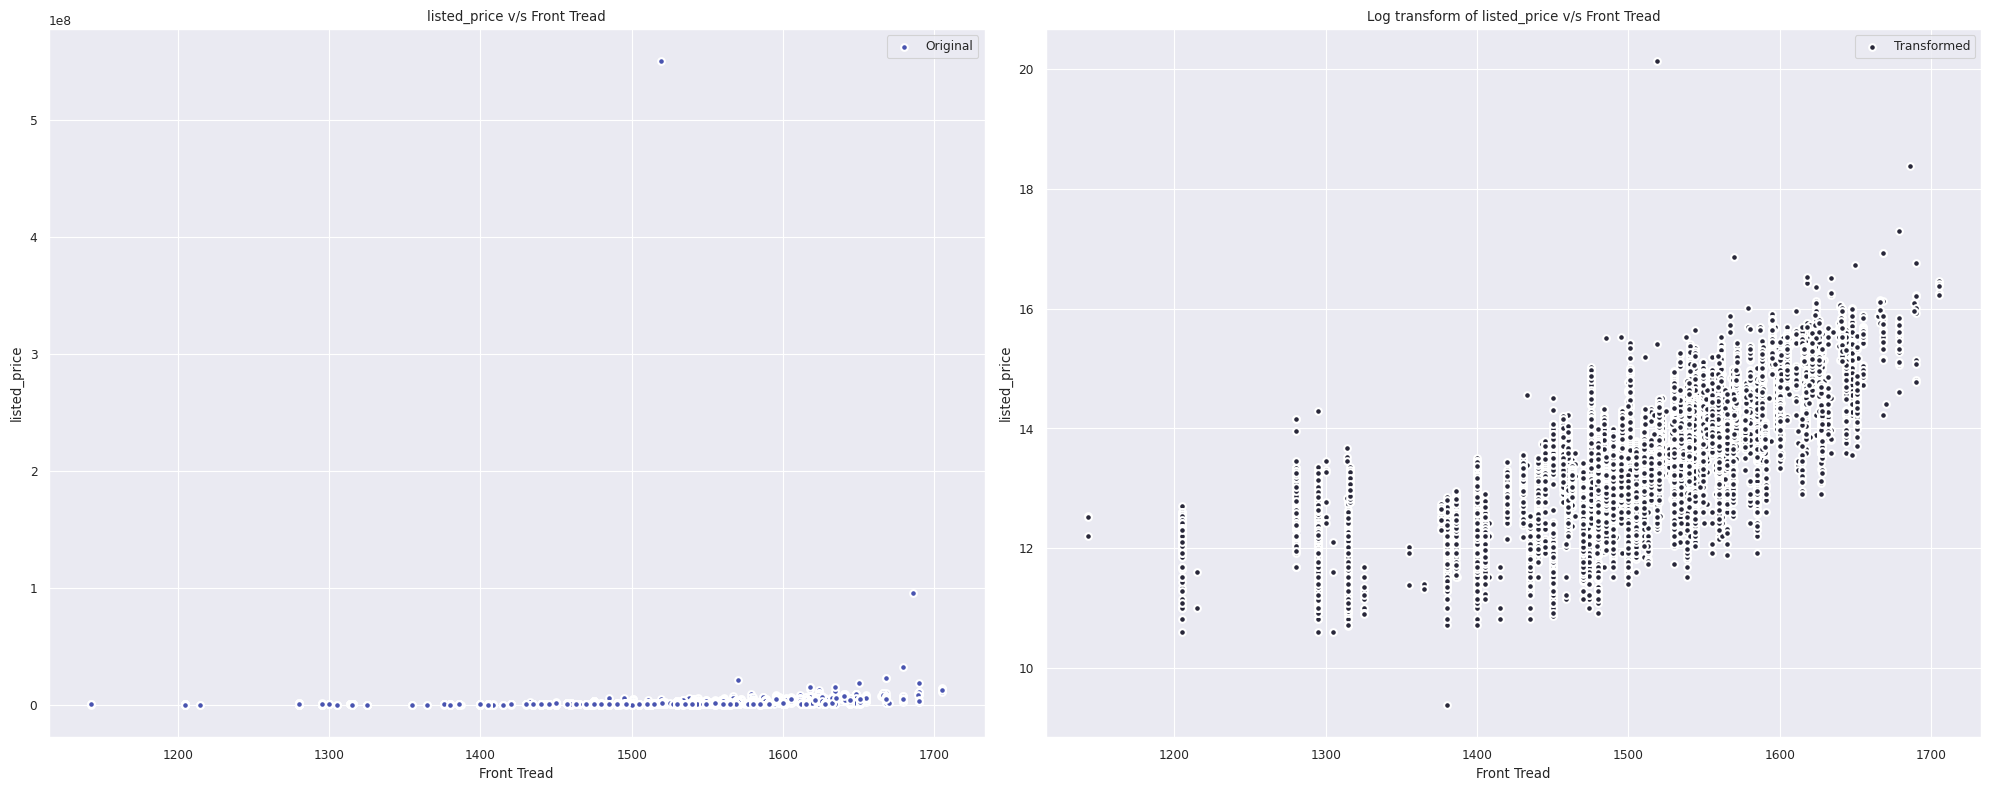

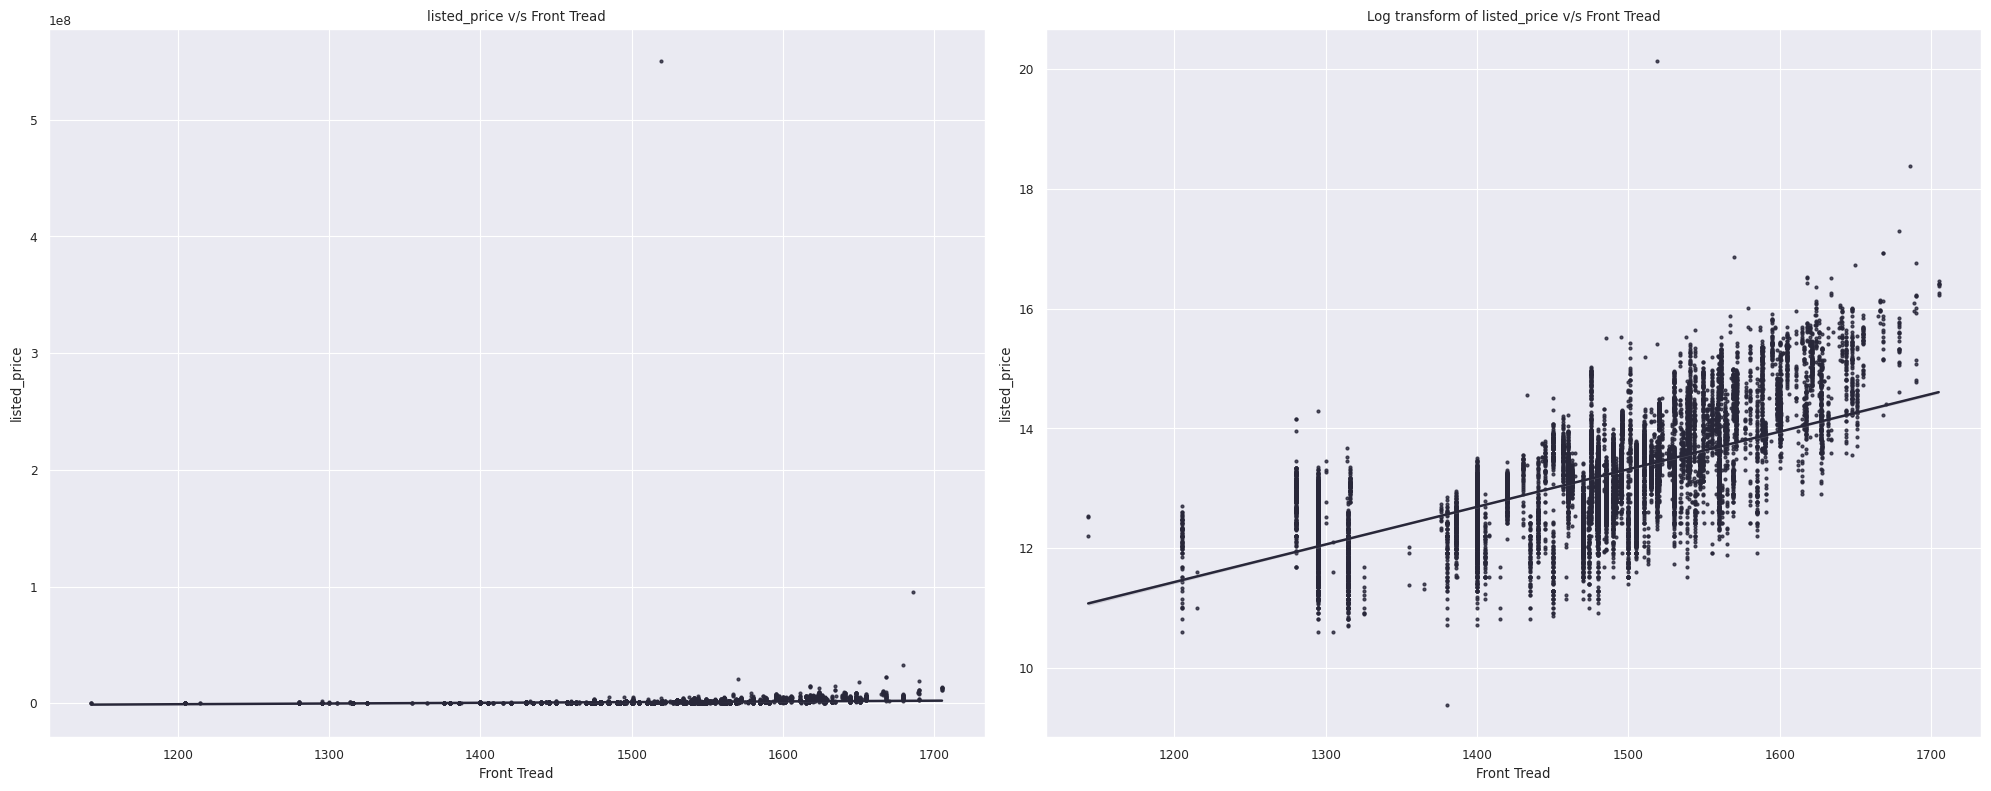

In [83]:
feature_dist_plots(df2, 'Front Tread', linewidth=0.8, sat=0.8, fontscale=1, rotation=0);
target_relation_plots(df, col='Front Tread', linewidth = 1.5, fontscale=1, rotation=0, sorted=True, plot='scatter');
target_relation_plots(df, col='Front Tread', fontscale=1, rotation=0, sorted=True, plot='reg', scatter_kws={'s':4}, order=1);

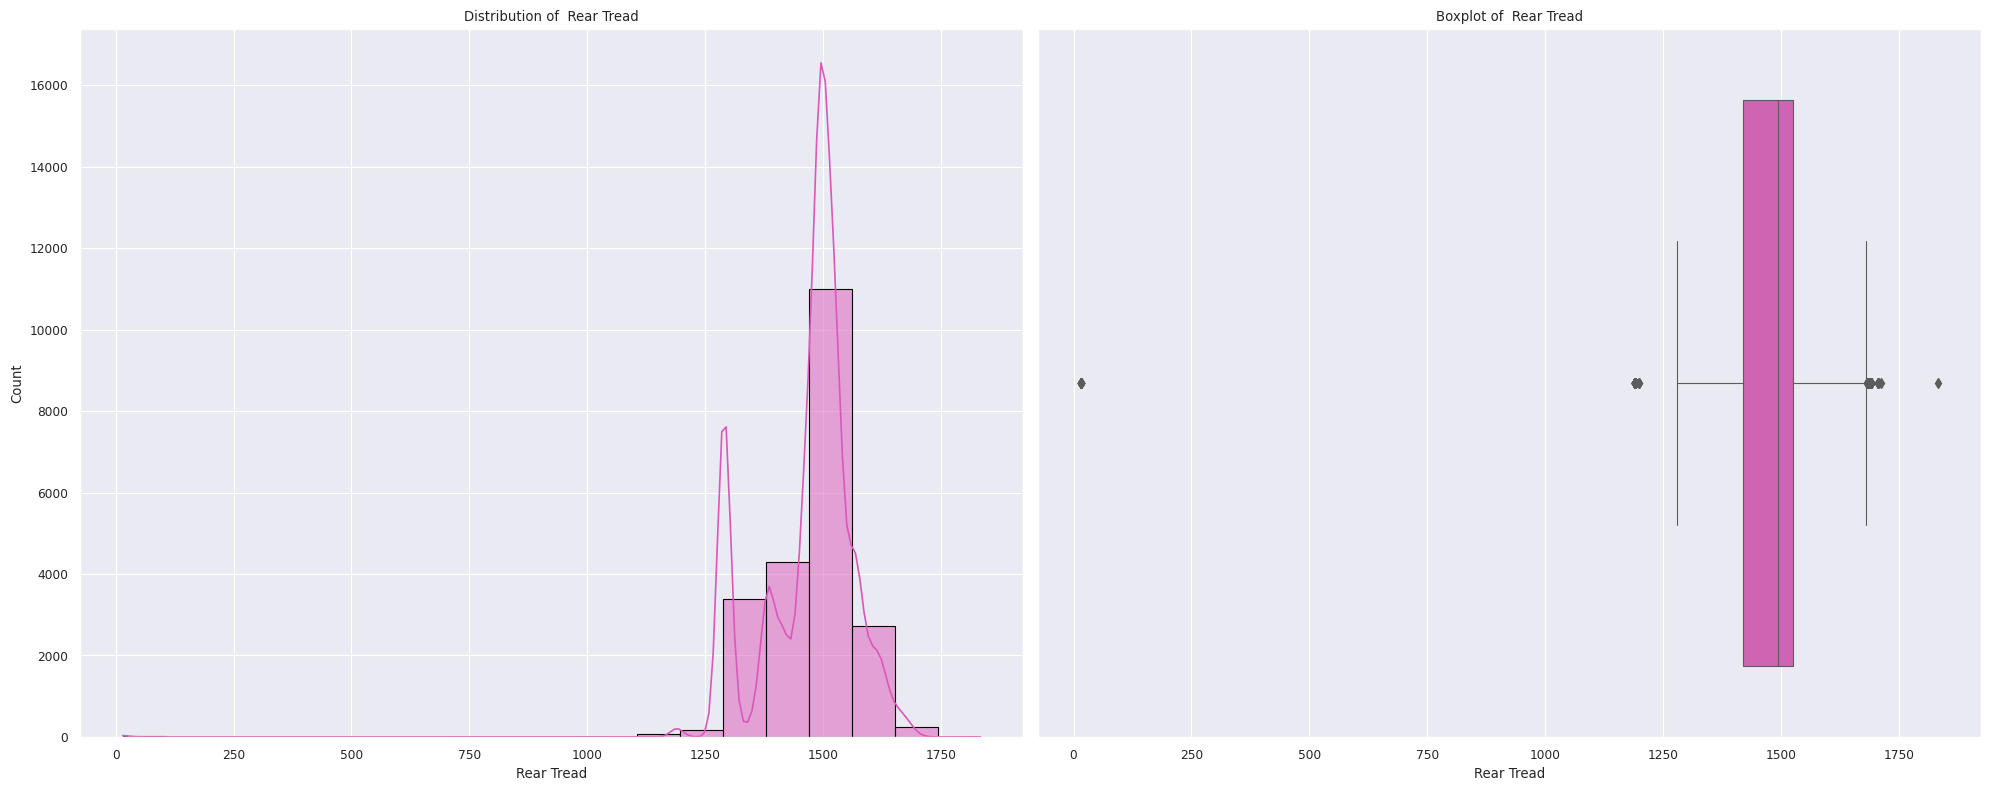

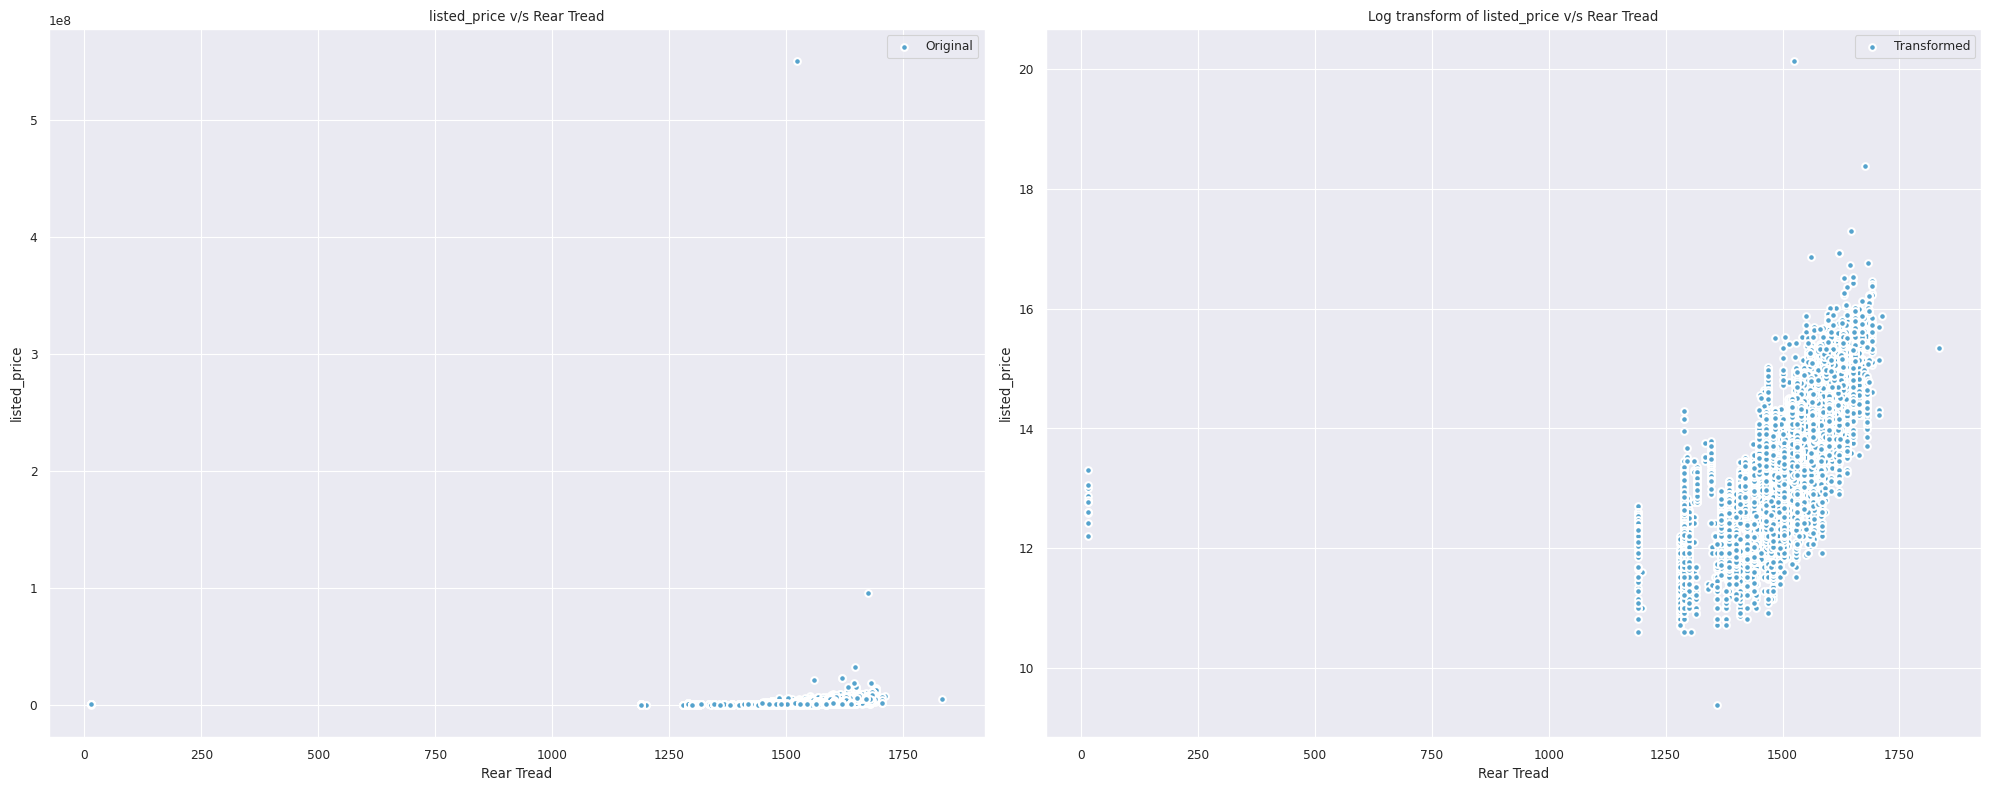

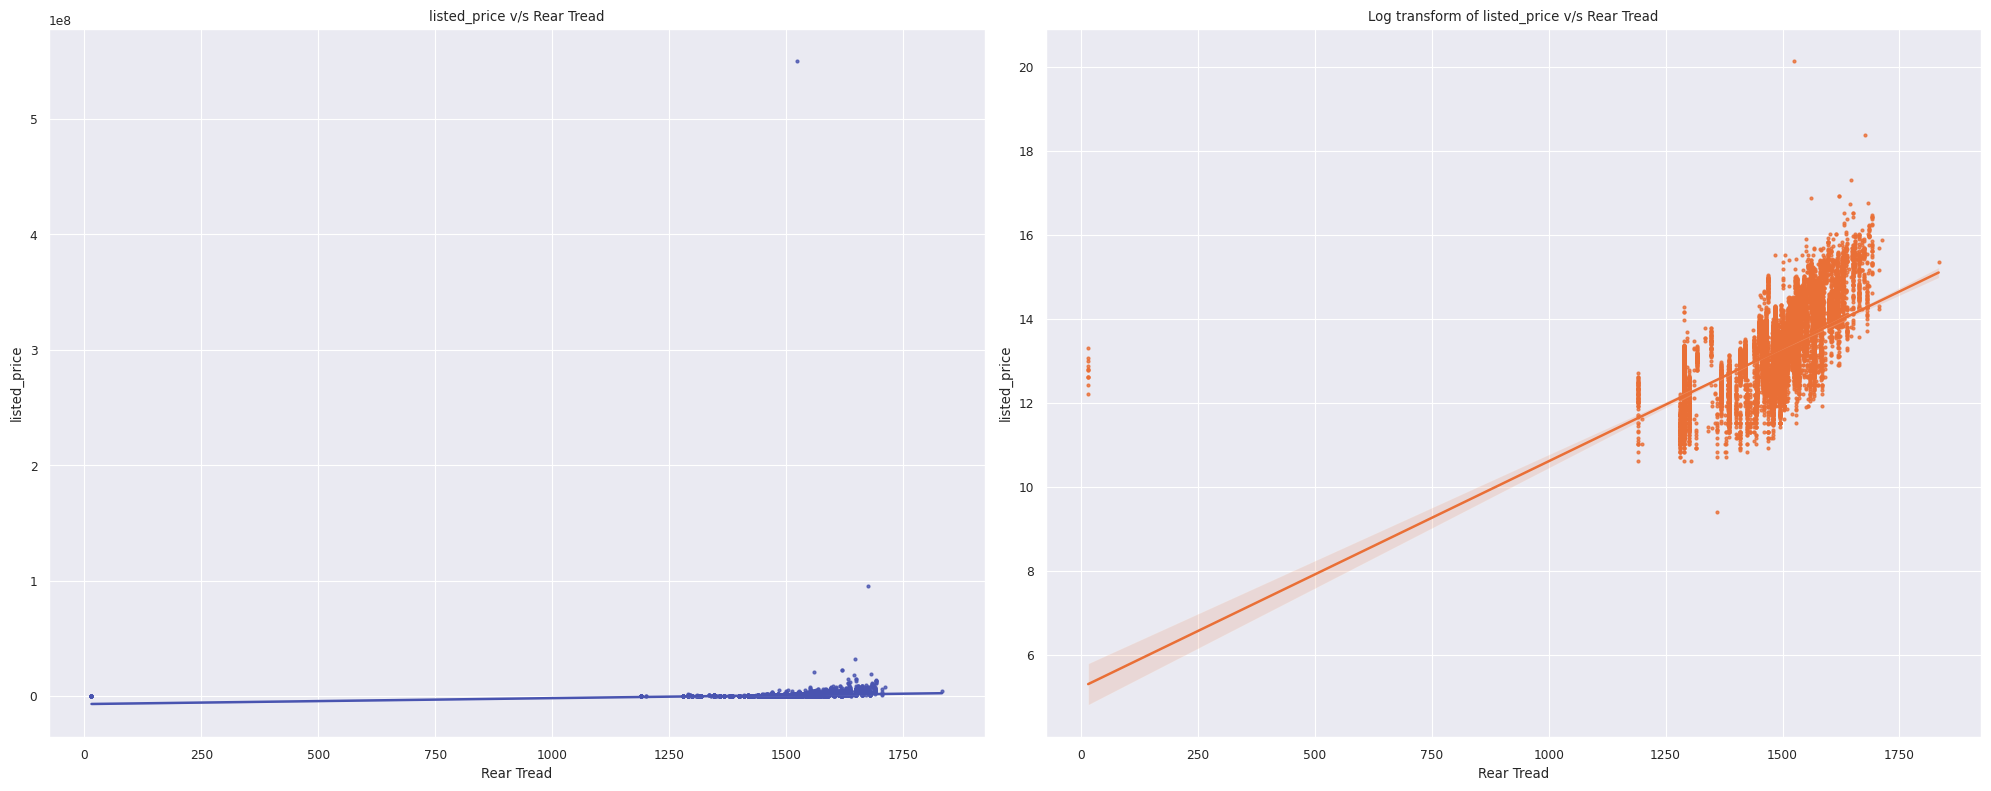

In [84]:
feature_dist_plots(df2, 'Rear Tread', linewidth=0.8, sat=0.8, fontscale=1, rotation=0);
target_relation_plots(df, col='Rear Tread', linewidth = 1.5, fontscale=1, rotation=0, sorted=True, plot='scatter');
target_relation_plots(df, col='Rear Tread', fontscale=1, rotation=0, sorted=True, plot='reg', scatter_kws={'s':4}, order=1);

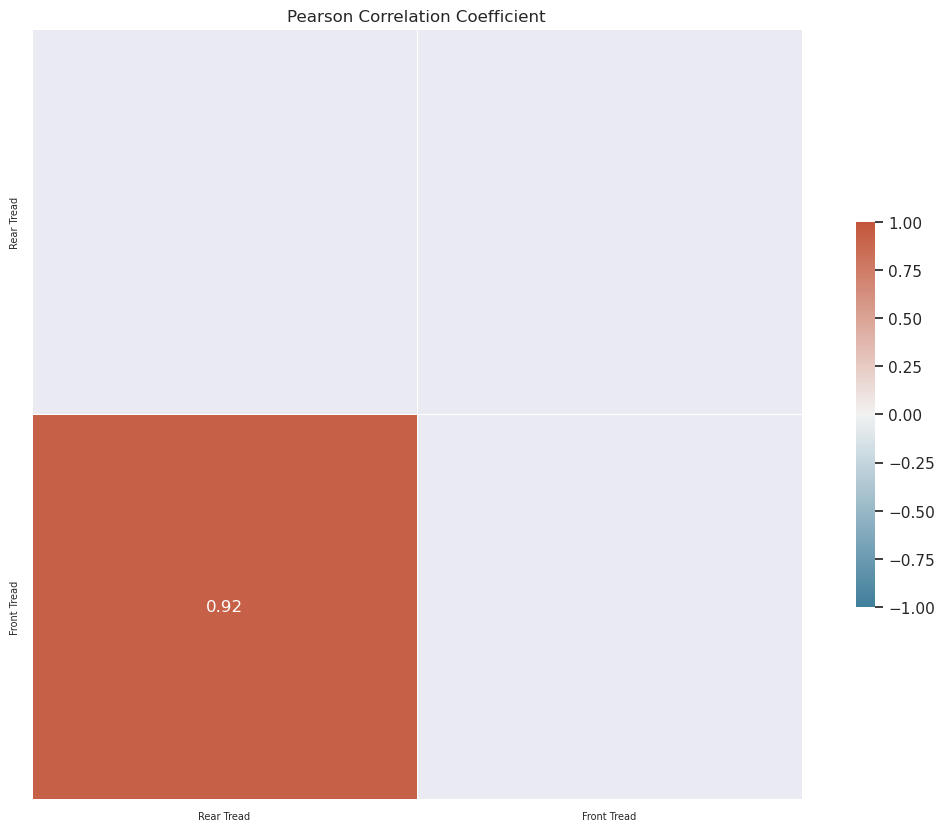

In [85]:
correlation_with_plot(df2, features=['Rear Tread', 'Front Tread'], target=False, annot=True, method='pearson');

### Suggestions and Observations

1. The minimum value of the column `Rear Tread` is '15' which is not realistic and most probably were reported wrongly.
2. The columns `Rear Tread` and `Front Tread` are VERY HIGHLY correlated. So just **drop the column `Rear Tread`**. It will solve the collinearity of variables problem as well as help us avoid the wrongly reported values in the column.

In [86]:
def RearTread_transformation(df: pd.DataFrame):
    """
    Drop the 'Rear Tread' column
    """
    df.drop('Rear Tread', axis=1, inplace=True)
    return

suggested_transformations.append(RearTread_transformation)

---

### `Kerb Weight` and `Gross Weight`

In [87]:
analyze_data(df2, 'Kerb Weight');

Overview of column "Kerb Weight"
+----------------+--------------------+
|    Measure     |       Value        |
+----------------+--------------------+
| Distinct Count |        533         |
|   Distinct %   | 1.4114718500079444 |
| Missing Count  |       13114        |
|   Missing %    | 34.72803347280335  |
|      Mean      | 1145.3083008763388 |
|    Minimum     |       451.0        |
|    Maximum     |       2962.0       |
+----------------+--------------------+


Quantile stats for column "Kerb Weight"
+---------------------+--------+
|      Statistic      | Value  |
+---------------------+--------+
|       Minimum       | 451.0  |
|    5th Percentile   | 784.0  |
|  First Quartile, Q1 | 935.0  |
|        Median       | 1066.0 |
|  Third Quartile, Q3 | 1230.0 |
|   95th Percentile   | 1825.0 |
|       Maximum       | 2962.0 |
|        Range        | 2511.0 |
| Interquartile Range | 295.0  |
+---------------------+--------+


Extremums for column "Kerb Weight"
Maximum 5 values
+-

In [88]:
analyze_data(df2, 'Gross Weight');

Overview of column "Gross Weight"
+----------------+--------------------+
|    Measure     |       Value        |
+----------------+--------------------+
| Distinct Count |        284         |
|   Distinct %   | 0.7520788093850961 |
| Missing Count  |       20861        |
|   Missing %    | 55.243366347121444 |
|      Mean      | 1707.3278504230518 |
|    Minimum     |       785.0        |
|    Maximum     |       3490.0       |
+----------------+--------------------+


Quantile stats for column "Gross Weight"
+---------------------+--------+
|      Statistic      | Value  |
+---------------------+--------+
|       Minimum       | 785.0  |
|    5th Percentile   | 1185.0 |
|  First Quartile, Q1 | 1350.0 |
|        Median       | 1590.0 |
|  Third Quartile, Q3 | 1965.0 |
|   95th Percentile   | 2510.0 |
|       Maximum       | 3490.0 |
|        Range        | 2705.0 |
| Interquartile Range | 615.0  |
+---------------------+--------+


Extremums for column "Gross Weight"
Maximum 5 values

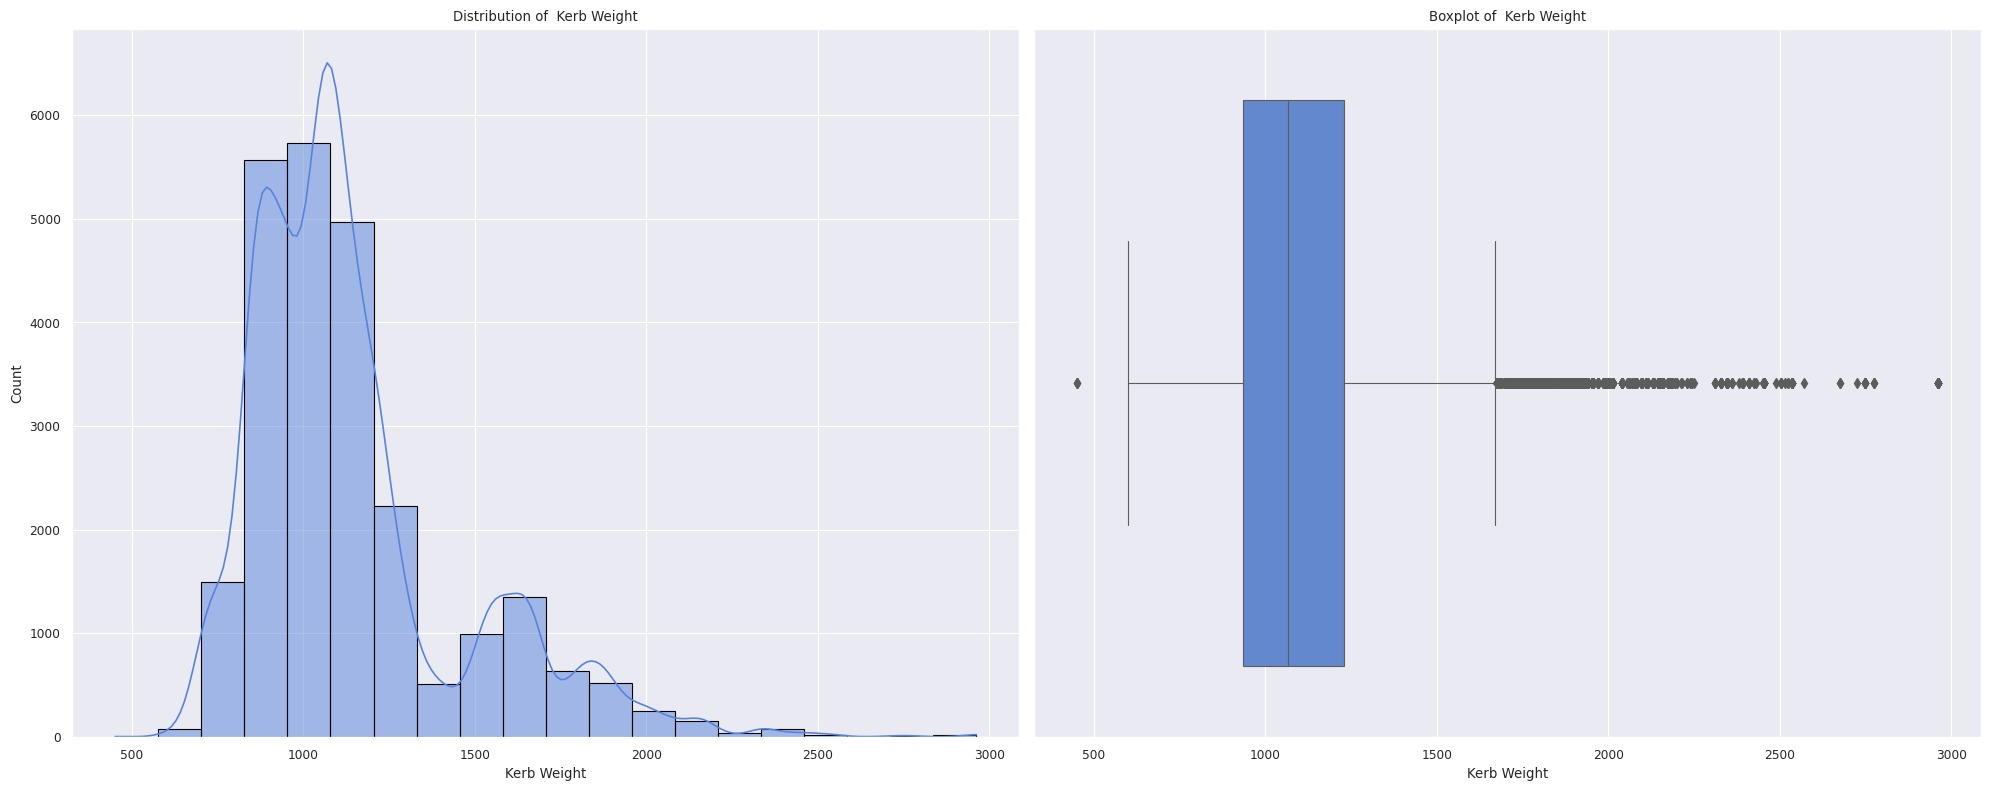

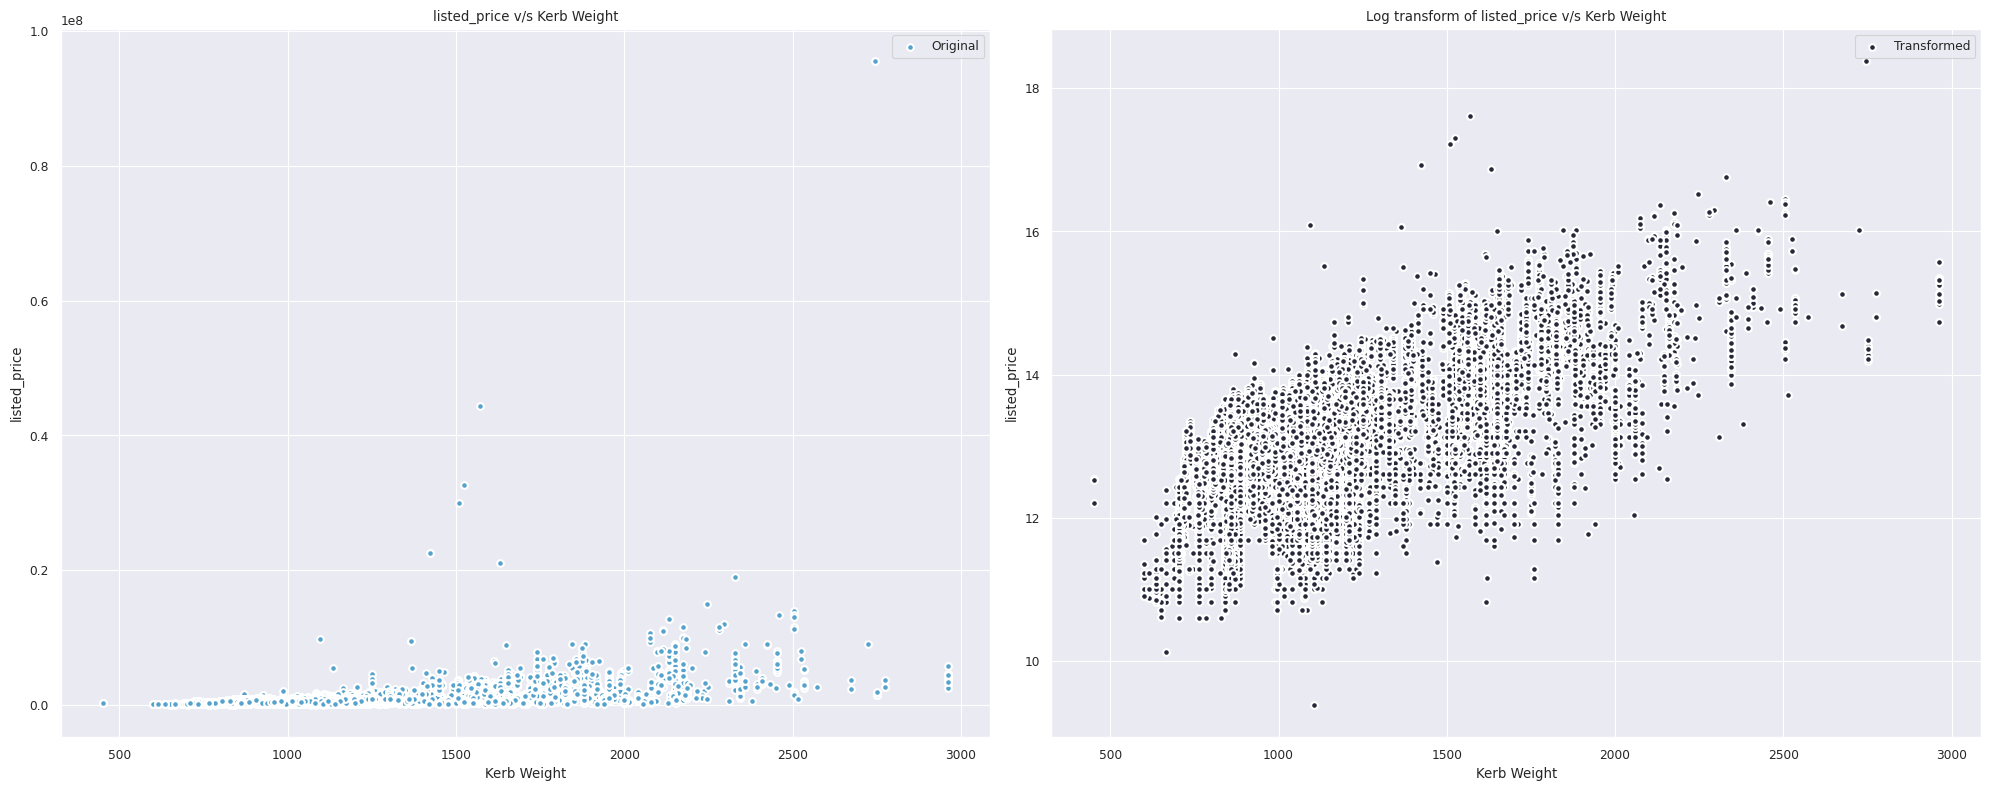

In [89]:
feature_dist_plots(df2, 'Kerb Weight', linewidth=0.8, sat=0.8, fontscale=1, rotation=0);
target_relation_plots(df, col='Kerb Weight', linewidth = 1.5, fontscale=1, rotation=0, sorted=True, plot='scatter');

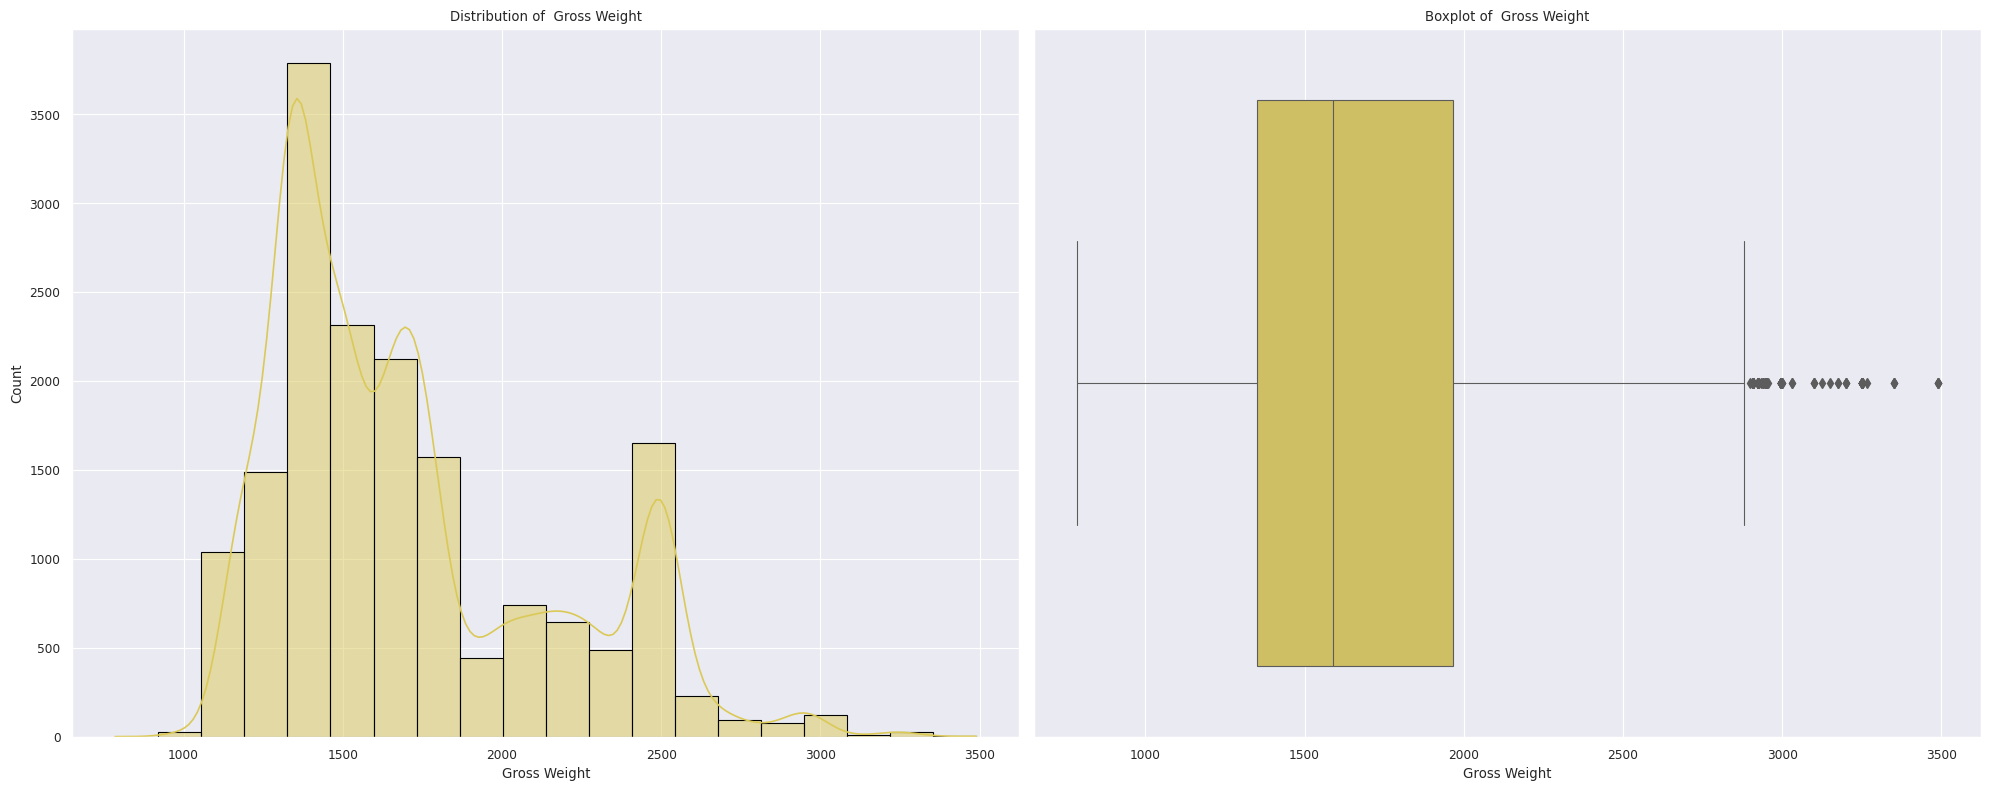

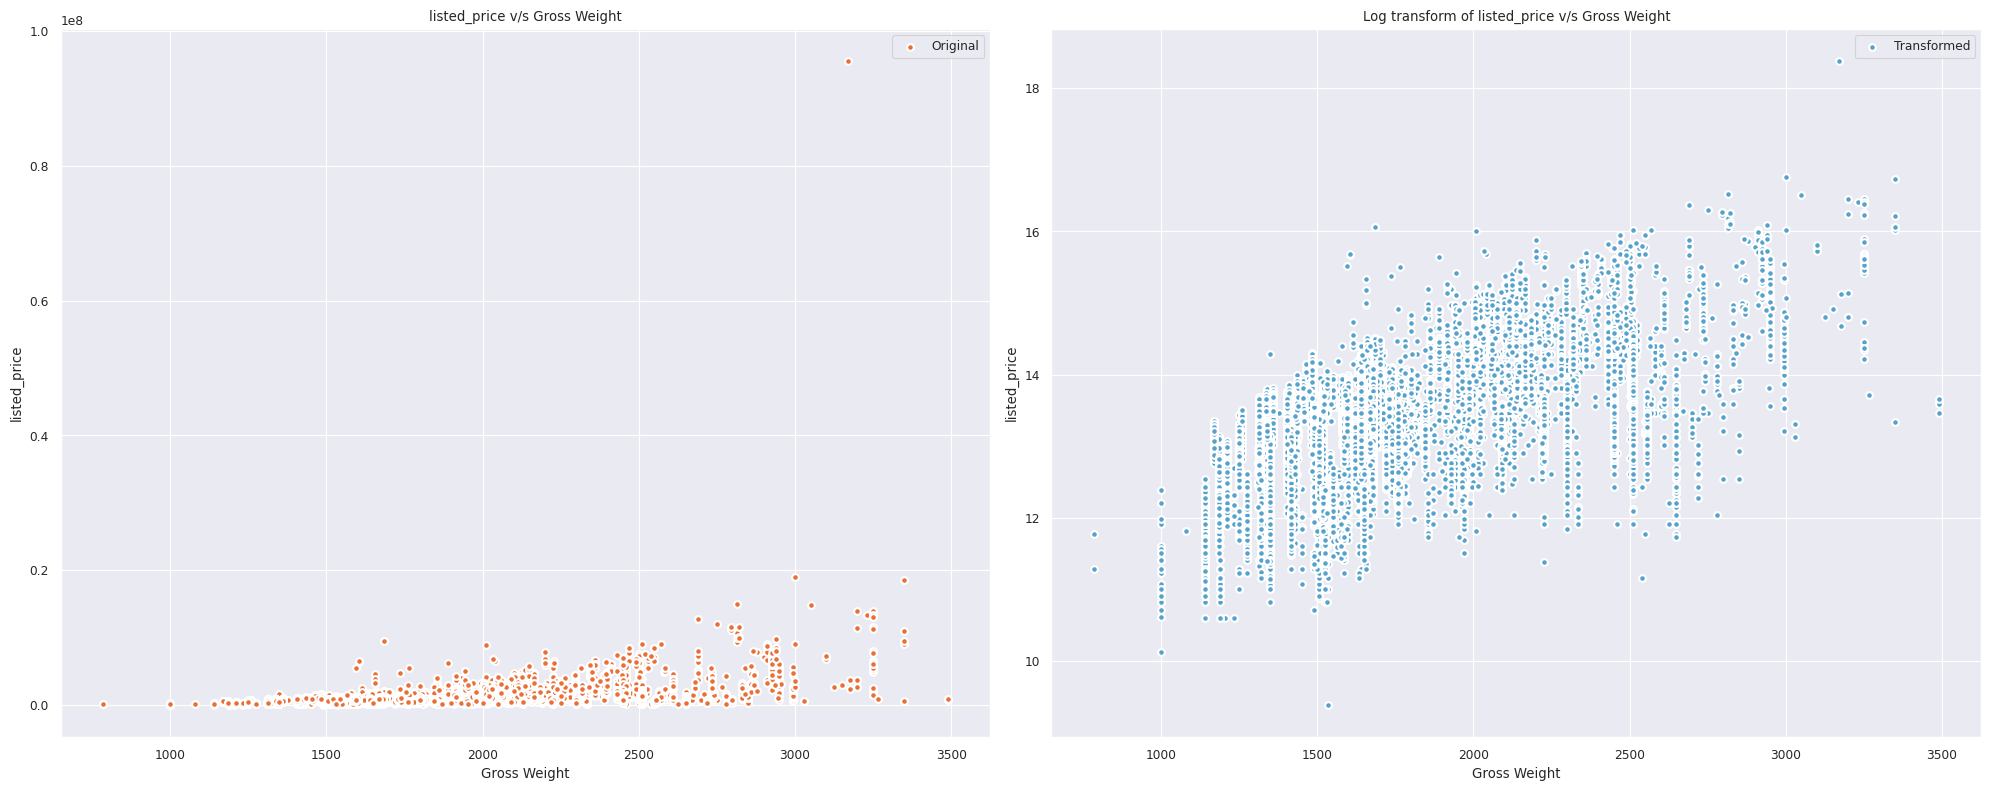

In [90]:
feature_dist_plots(df2, 'Gross Weight', linewidth=0.8, sat=0.8, fontscale=1, rotation=0);
target_relation_plots(df, col='Gross Weight', linewidth = 1.5, fontscale=1, rotation=0, sorted=True, plot='scatter');

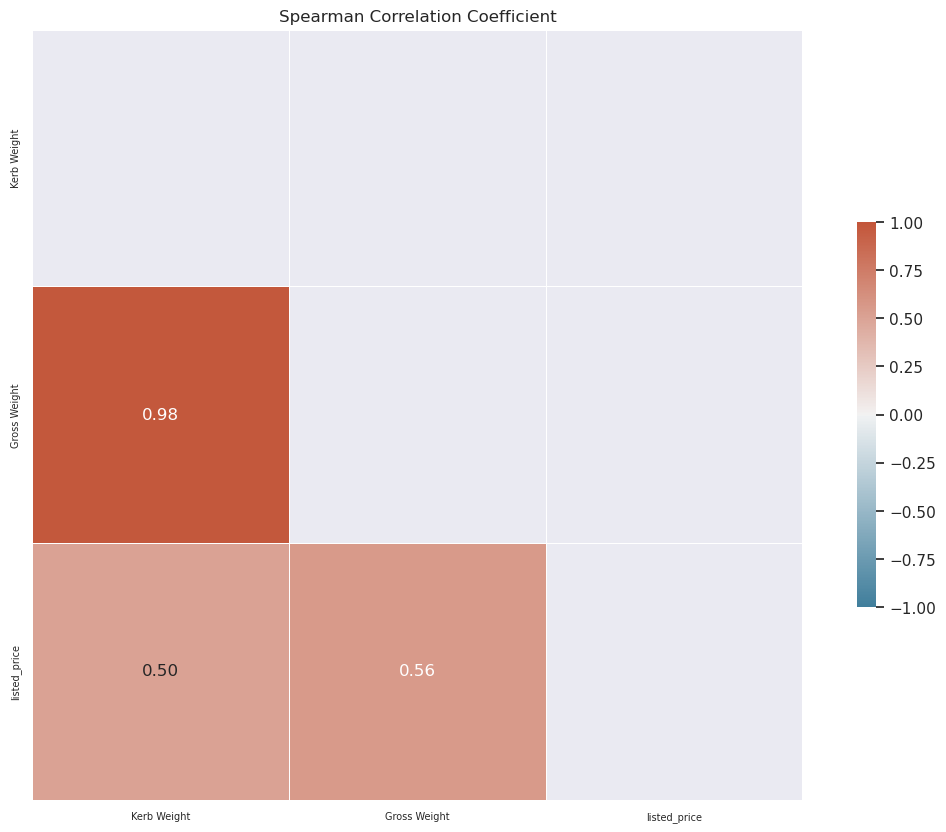

In [91]:
correlation_with_plot(df2, features=['Kerb Weight', 'Gross Weight', TARGET], target=True, annot=True, method='spearman', clip=True);

### Suggestions
**Drop** the `Gross Weight` column, since it's highly correlated with `Kerb Weight`, and it also has over 50% of the data missing


In [92]:
def GrossWeight_transformation(df: pd.DataFrame):
    """
    Drop the 'Gross Weight' column
    """
    df.drop('Gross Weight', axis=1, inplace=True)
    return

suggested_transformations.append(GrossWeight_transformation)

---

### `Gear Box`

In [93]:
analyze_data(df2, 'Gear Box');

Overview of column "Gear Box"
+----------------+---------------------+
|    Measure     |        Value        |
+----------------+---------------------+
| Distinct Count |          11         |
|   Distinct %   | 0.02912981303956358 |
| Missing Count  |         463         |
|   Missing %    |  1.2261003124834489 |
+----------------+---------------------+


Column Gear Box is not numeric
Common values for column "Gear Box"
+---------+-------+--------------------+--------------------+
|  Value  | Count |     Frequency      |   Mean of Target   |
+---------+-------+--------------------+--------------------+
| 5 speed | 25202 | 67.56749510710743  | 454970.9171494326  |
| 6 speed |  7457 | 19.99249309632966  | 1097789.9557462786 |
| 7 speed |  1837 | 4.925065015147859  | 1686276.7980402831 |
| 8 speed |  1128 | 3.0242097643368453 | 2857558.3129432625 |
| 4 speed |  760  | 2.037588139092201  | 496728.69736842107 |
+---------+-------+--------------------+--------------------+




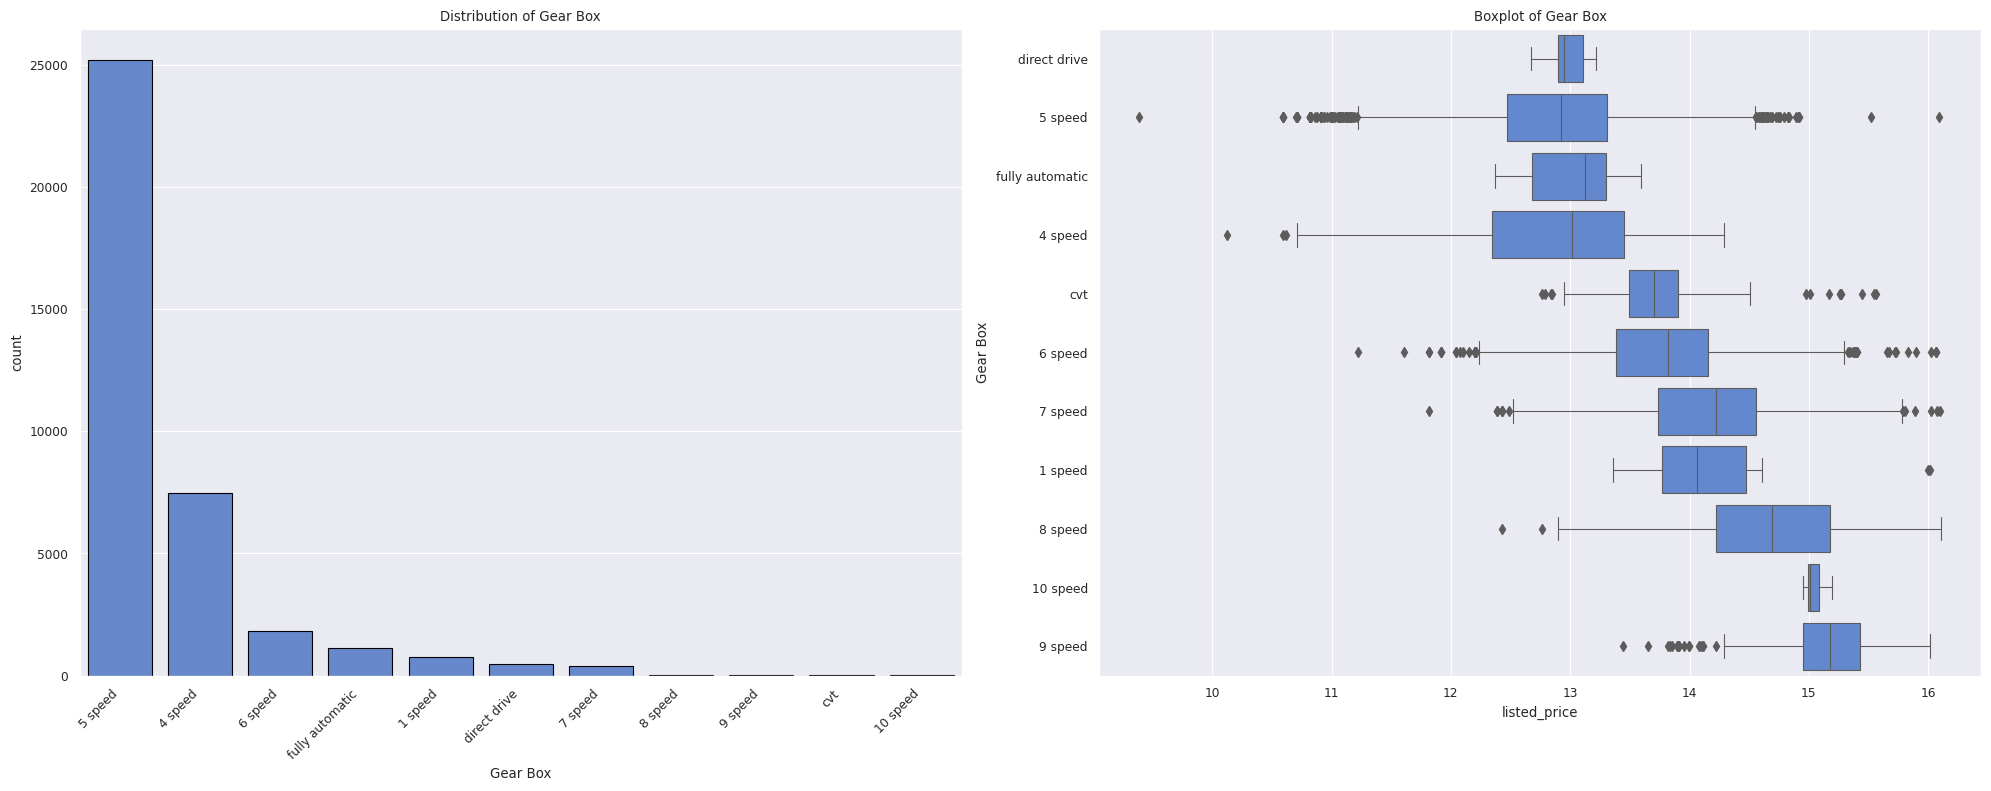

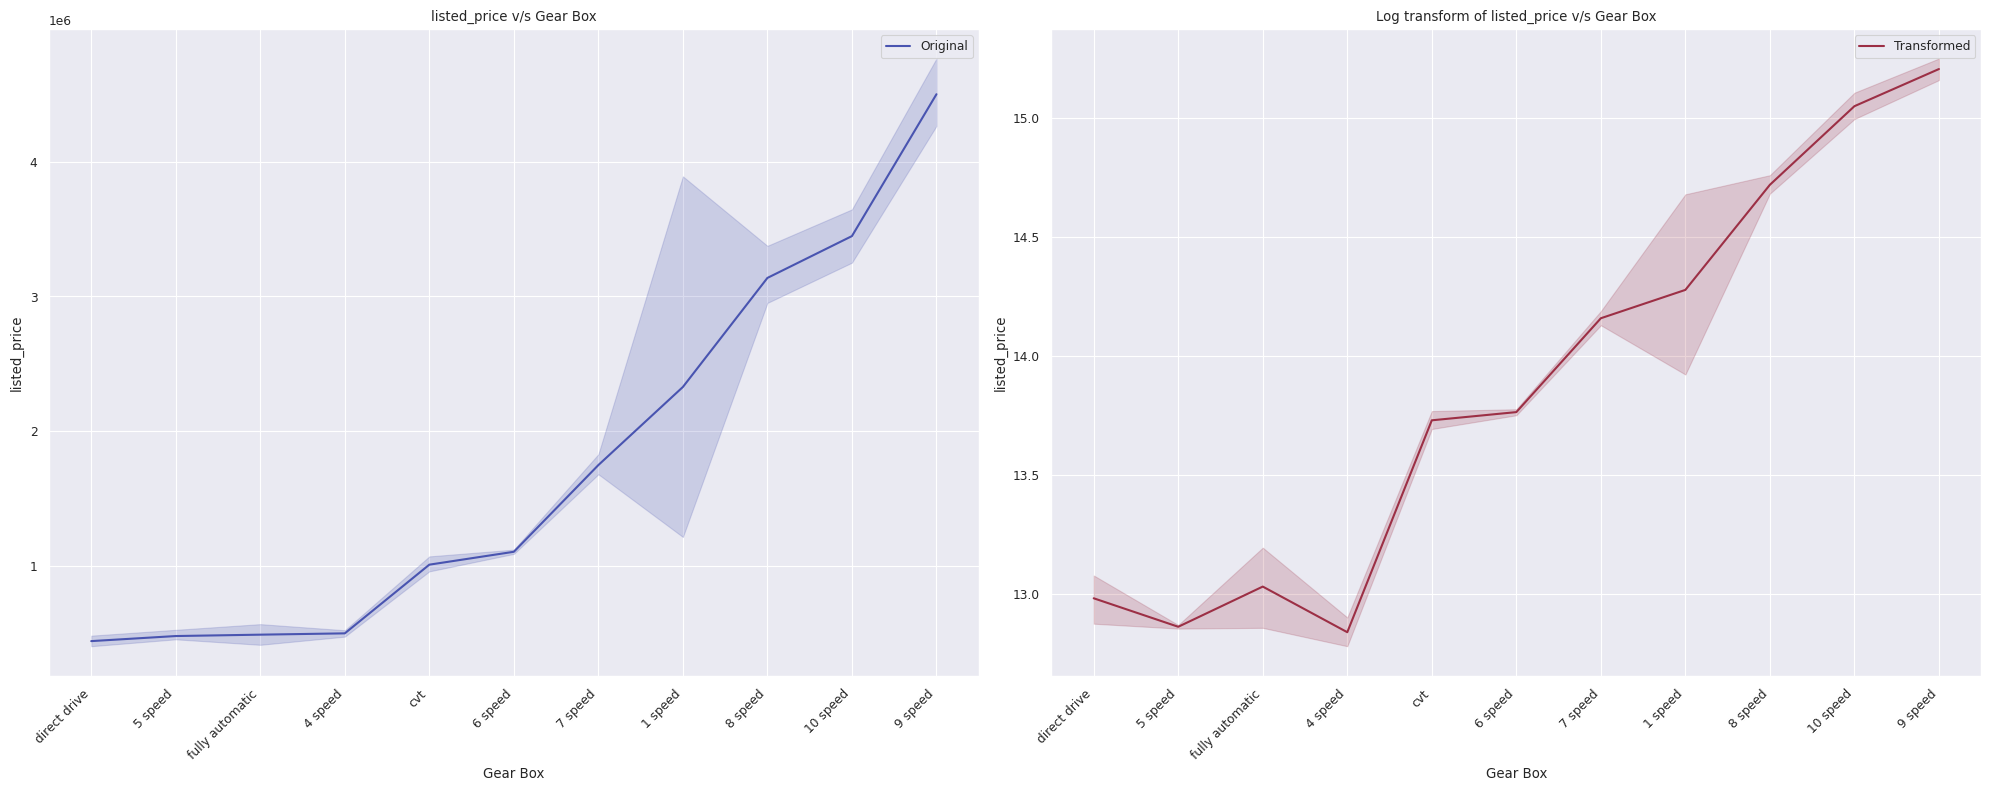

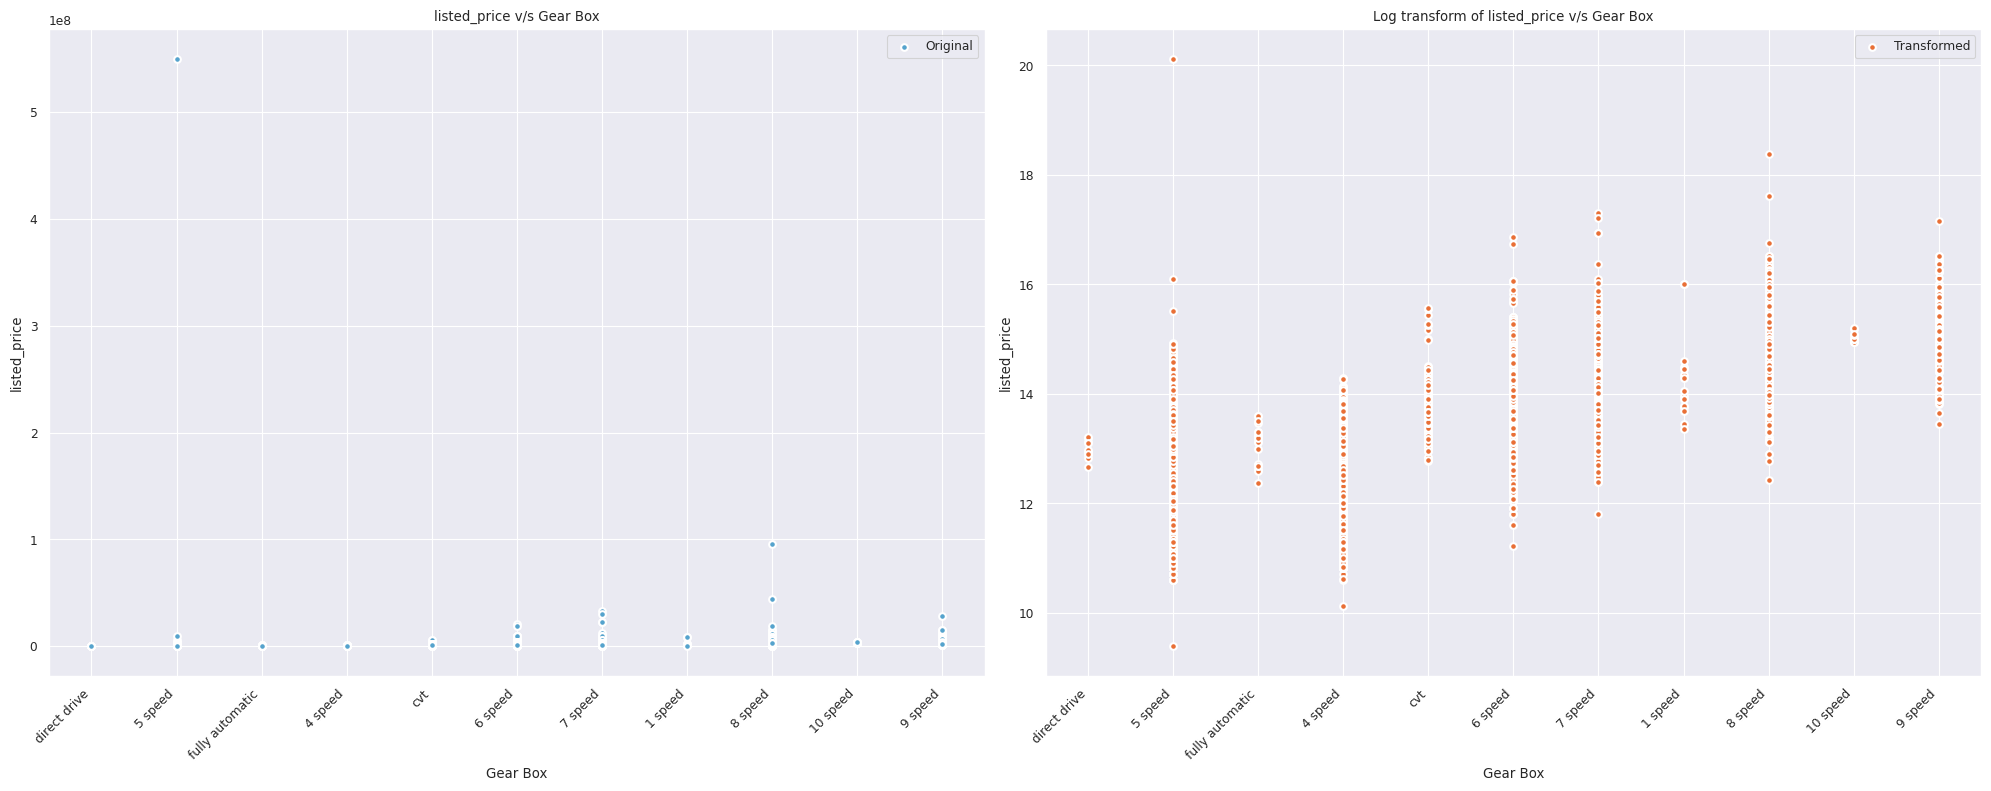

In [94]:
feature_dist_plots(df2, 'Gear Box', linewidth=0.8, sat=0.8, fontscale=1, rotation=45, transformation=np.log, sorted=True);
target_relation_plots(df, col='Gear Box', linewidth = 1.5, fontscale=1, rotation=45, sorted=True, plot='line');
target_relation_plots(df, col='Gear Box', linewidth = 1.5, fontscale=1, rotation=45, sorted=True, plot='scatter');

---

### `Drive Type`

In [95]:
analyze_data(df2, 'Drive Type');

Overview of column "Drive Type"
+----------------+----------------------+
|    Measure     |        Value         |
+----------------+----------------------+
| Distinct Count |          6           |
|   Distinct %   | 0.015888988930671043 |
| Missing Count  |         4496         |
|   Missing %    |  11.906149038716169  |
+----------------+----------------------+


Column Drive Type is not numeric
Common values for column "Drive Type"
+-------+-------+--------------------+--------------------+
| Value | Count |     Frequency      |   Mean of Target   |
+-------+-------+--------------------+--------------------+
|  fwd  | 27631 | 83.06078278121807  | 587298.8579855959  |
|  rwd  |  2290 | 6.883905489087958  | 1579962.5240174672 |
|  2wd  |  1141 | 3.4299284554800695 | 640130.2936021034  |
|  awd  |  1105 | 3.321709853904888  | 2400344.6606334844 |
|  4wd  |  802  | 2.410869957313774  | 2021904.7655860349 |
+-------+-------+--------------------+--------------------+




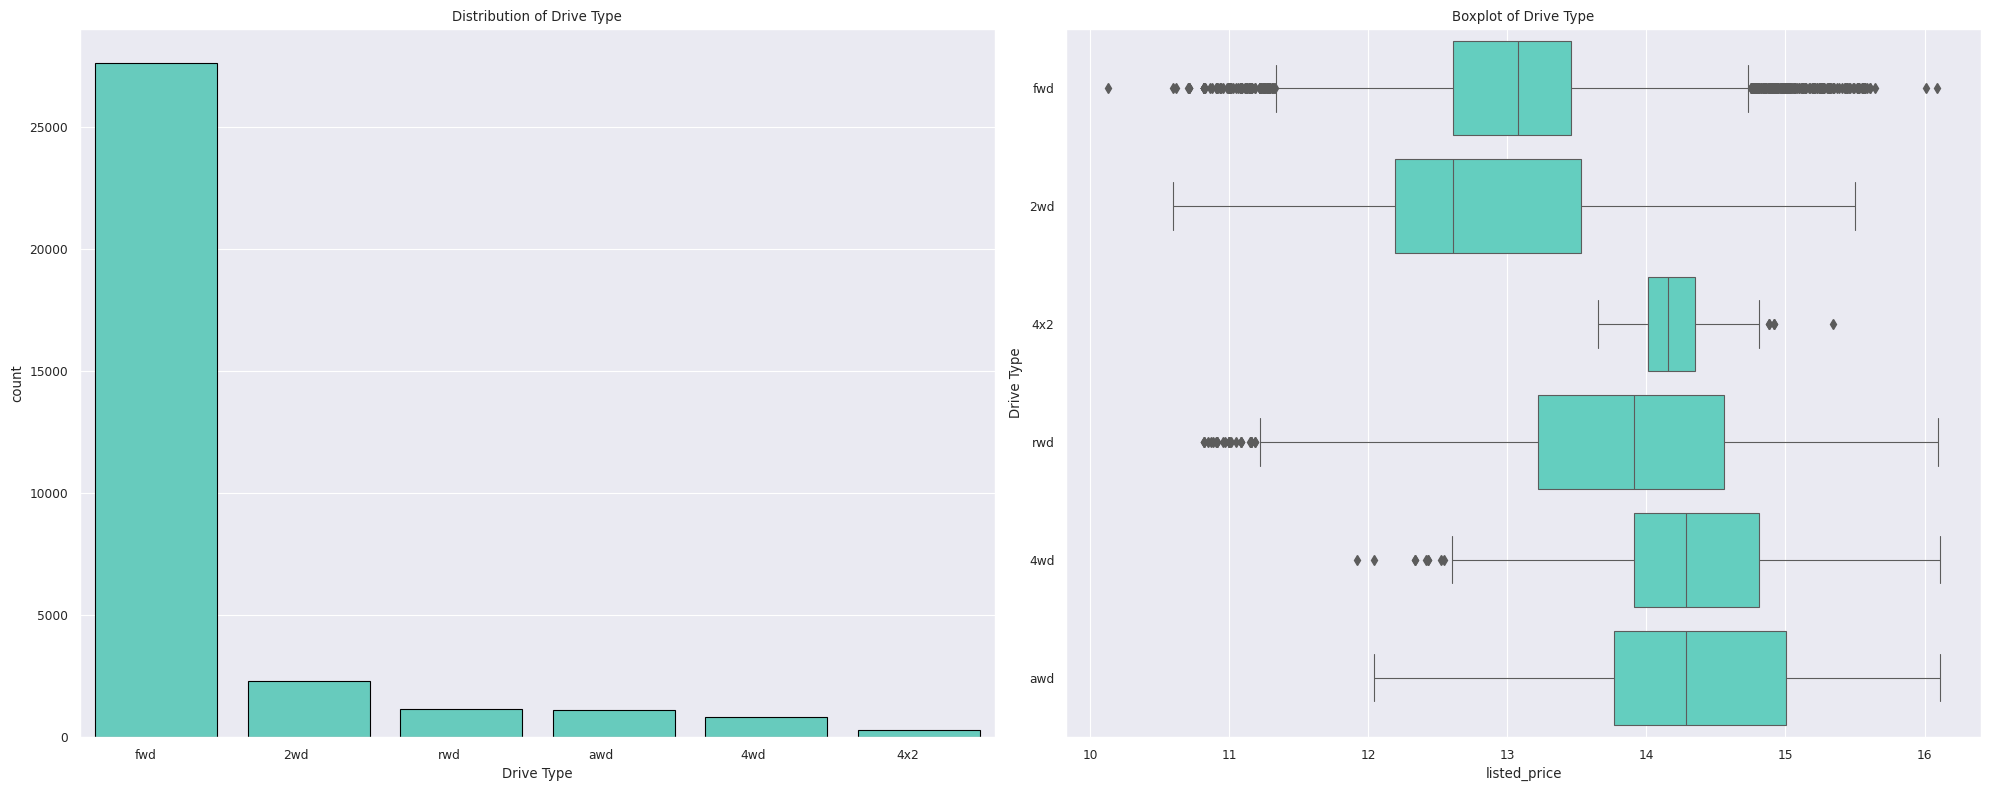

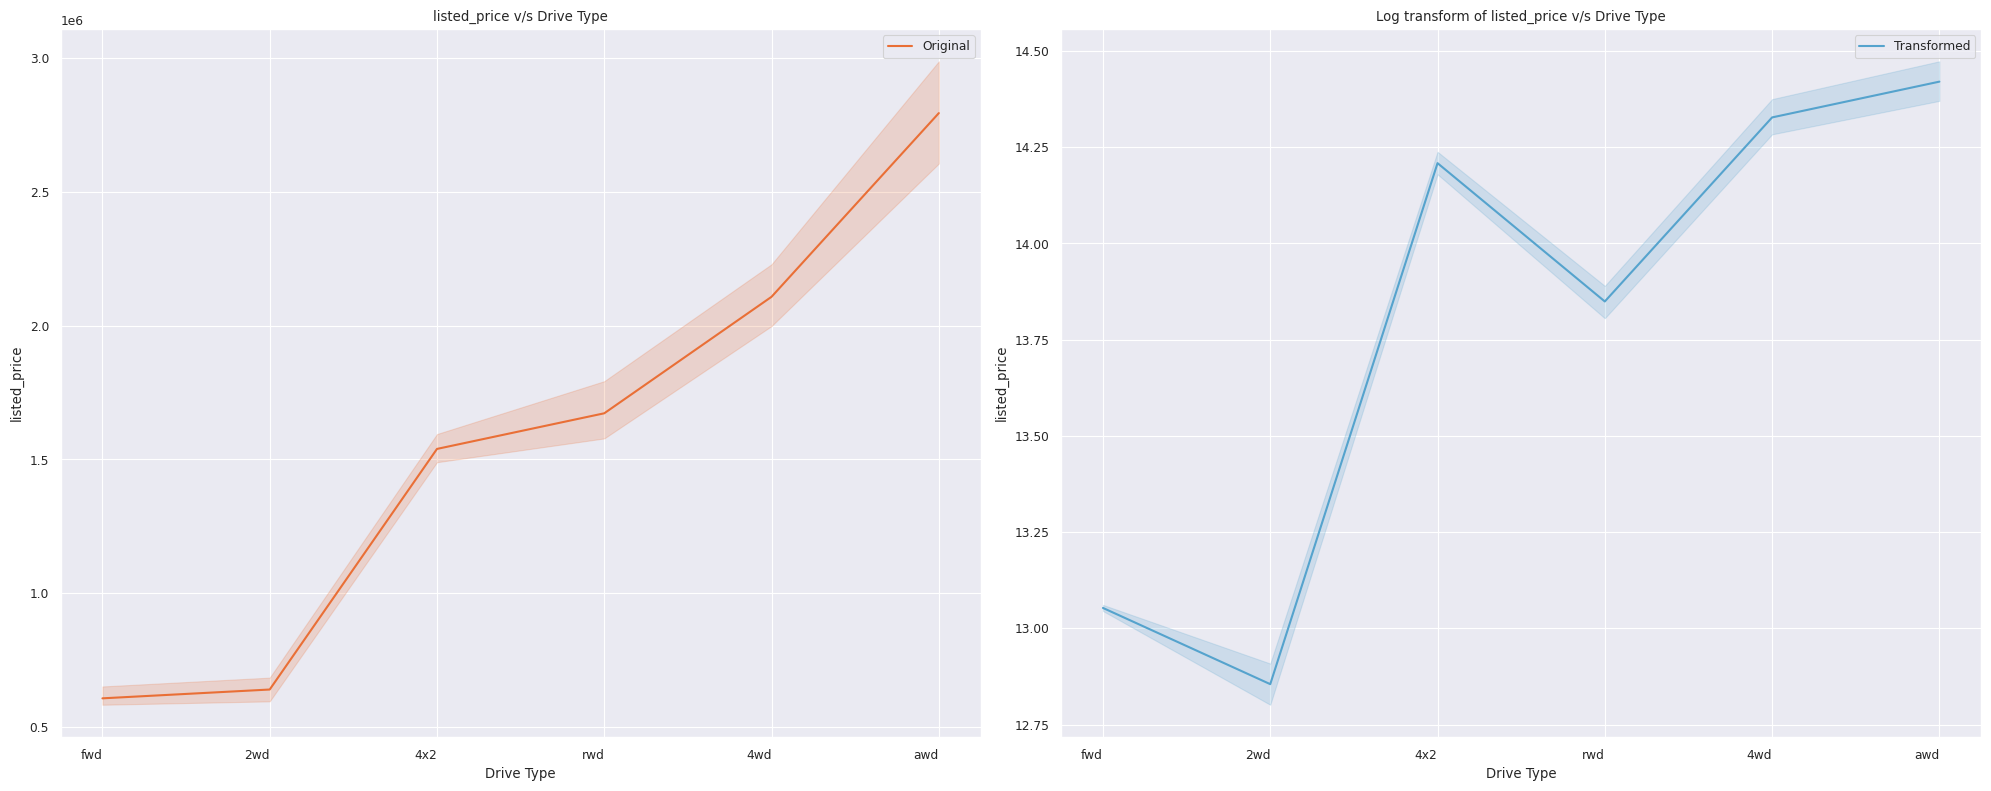

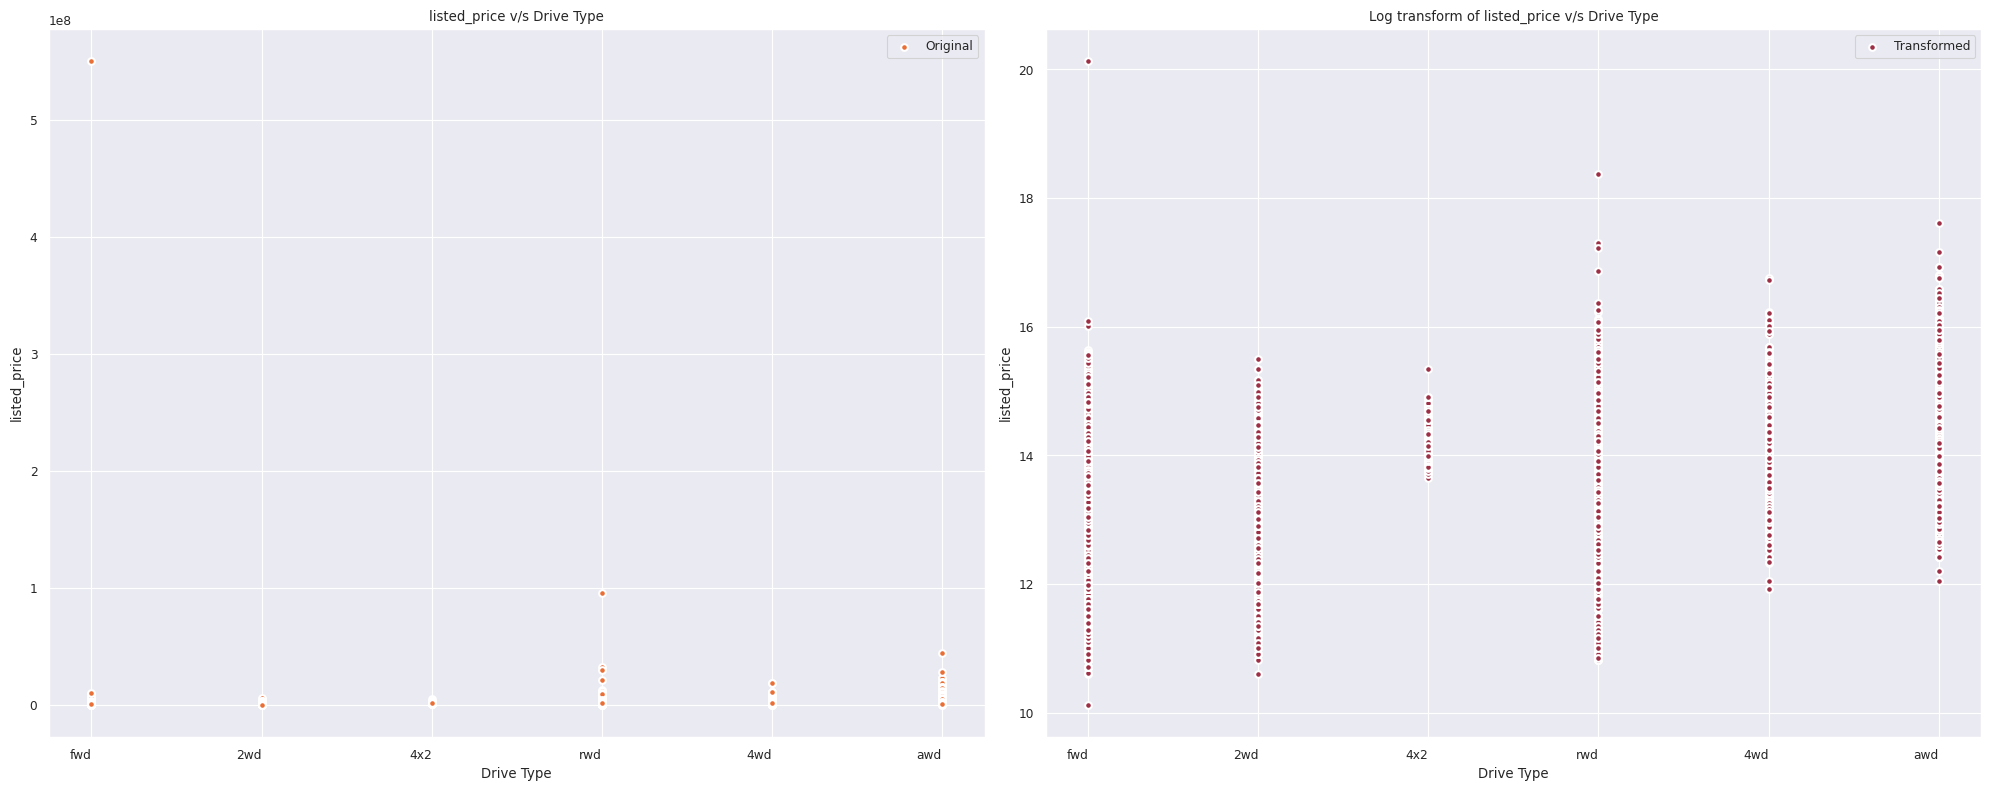

In [96]:
feature_dist_plots(df2, 'Drive Type', linewidth=0.8, sat=0.8, fontscale=1, rotation=0, transformation=np.log, sorted=True);
target_relation_plots(df, col='Drive Type', linewidth = 1.5, fontscale=1, rotation=0, sorted=True, plot='line');
target_relation_plots(df, col='Drive Type', linewidth = 1.5, fontscale=1, rotation=0, sorted=True, plot='scatter');

---

## End of Notebook I

We will continue to explore the rest of the columns in the [second part of the notebook](https://www.kaggle.com/code/sukritchatterjee/data-exploration-ii). 

Let's conclude here and take a look at suggested transformations in this notebook

In [97]:
suggested_transformations

[<function __main__.myear_transformation(df: pandas.core.frame.DataFrame)>,
 <function __main__.images_transformation(df: pandas.core.frame.DataFrame)>,
 <function __main__.imgCount_transformation(df: pandas.core.frame.DataFrame)>,
 <function __main__.threesixty_transformation(df: pandas.core.frame.DataFrame)>,
 <function __main__.dvn_transformation(df: pandas.core.frame.DataFrame)>,
 <function __main__.discountValue_transformation(df: pandas.core.frame.DataFrame)>,
 <function __main__.carType_transformation(df: pandas.core.frame.DataFrame)>,
 <function __main__.NumOfCylinder_transformation(df: pandas.core.frame.DataFrame)>,
 <function __main__.Height_transformation(df: pandas.core.frame.DataFrame)>,
 <function __main__.Length_transformation(df: pandas.core.frame.DataFrame)>,
 <function __main__.RearTread_transformation(df: pandas.core.frame.DataFrame)>,
 <function __main__.GrossWeight_transformation(df: pandas.core.frame.DataFrame)>]

In [98]:
for trans_func in suggested_transformations:
    print(trans_func.__doc__)

None

    Drop the column 'images' from the dataframe
    

    Drop the column 'imgCount' from the dataframe
    

    Drop the column 'threesixty' from the dataframe
    

    Drop the column 'dvn' from the dataframe
    

    Drop the column 'discountValue' from the dataframe
    

    Drop the column 'carType' from the dataframe
    

    Replace the value of No of Cylinder with null if the car is electric
    

    Drop the 'Height' column
    

    Drop the 'Length' column
    

    Drop the 'Rear Tread' column
    

    Drop the 'Gross Weight' column
    
